# Transcription Factor Project - Functional Enrichment Analysis
**Robin Anwyl, UCSD Subramaniam Lab**

**Project Goal:** Analyze the hiPSC Perturb-seq dataset from the Mali lab (Nourreddine et al preprint) to investigate the effects of transcription factor knockouts (TF KOs)

**Notebook Description:** 
-  Data: TF KO clusters from minimum distortion embedding (MDE) with DEGs or HVGs as features
-  Analysis: overrepresentation analysis (ORA) using 1) known gene targets of TFs and 2) DEGs of TF KOs in a cluster; pre-ranked gene set enrichment analysis (GSEA) using differential gene expression results for TF KOs in a cluster
***

In [1]:
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import gseapy as gp
import networkx as nx
import decoupler as dc
#from gprofiler import GProfiler
from tqdm import tqdm

# ORA with known TF targets

-  Perform ORA with known TF targets for the TF KOs in each cluster
-  Use MDE generated with DEGs with p-adj < 0.0005 as features
-  We will first perform ORA using unsigned TF-target gene interactions (i.e. without information on if a TF is an activator or repressor of a gene), using gProfiler
-  After that, we will perform ORA using signed TF-target gene interactions 
    -  A TF KO is repression of a TF
    -  TF activates gene A --> TF KO leads to downregulation of gene A
    -  TF represses gene B --> TF KO leads to upregulation of gene B

In [2]:
de_results = pd.read_pickle("/home/ranwyl/results_tf_project/TF_KO_NTC_DE_results.pkl")
de_results

DMRT2_baseMean  DMRT2_log2FoldChange  DMRT2_lfcSE  DMRT2_stat  \
A1BG             5.285500              0.609960     0.619478    1.250948   
A2ML1            2.606644              0.100952     0.769812    0.197628   
A2ML1-AS1        8.352237              0.077233     0.476058    0.189240   
AAAS             7.516582              0.150004     0.507604    0.353576   
AACS            13.652746             -0.607225     0.388791   -1.720363   
...                   ...                   ...          ...         ...   
ZYG11A           1.936280              0.399434     0.914994    0.746997   
ZYG11B          18.247310              0.038689     0.334166    0.123994   
ZYX             22.916347              0.018090     0.297322    0.063336   
ZZEF1            5.599009             -0.137232     0.571315   -0.304019   
ZZZ3            25.307732             -0.080898     0.291180   -0.296541   

           DMRT2_pvalue  DMRT2_padj  OSR2_baseMean  OSR2_log2FoldChange  \
A1BG           0.210953         NaN       3.123957            -0.372431   
A2ML1          0.843336         NaN       1.550960            -0.509398   
A2ML1-AS1      0.849904         NaN       4.474111            -0.086464   
AAAS           0.723657         NaN       6.140222            -0.182040   
AACS           0.085366         NaN      11.690521             0.006217   
...                 ...         ...            ...                  ...   
ZYG11A         0.455065         NaN       0.847039            -1.352335   
ZYG11B         0.901320         NaN      12.379707            -0.510436   
ZYX            0.949499         NaN      15.218808             0.244391   
ZZEF1          0.761113         NaN       6.190842             0.929886   
ZZZ3           0.766817         NaN      15.362206            -0.050057   

           OSR2_lfcSE  OSR2_stat  ...  ZBED6_lfcSE  ZBED6_stat  ZBED6_pvalue  \
A1BG         0.747259  -0.721735  ...     0.991264   -0.500306      0.616860   
A2ML1        0.982173  -0.941713  ...     1.138998   -0.221171      0.824959   
A2ML1-AS1    0.641921  -0.181294  ...     0.902441   -1.561968      0.118296   
AAAS         0.560998  -0.406698  ...     0.736081    0.548093      0.583628   
AACS         0.417831   0.015168  ...     0.694740    0.985767      0.324247   
...               ...        ...  ...          ...         ...           ...   
ZYG11A       1.868836  -1.441918  ...     1.138496    0.365796      0.714517   
ZYG11B       0.415147  -1.377508  ...     0.500329   -0.321024      0.748192   
ZYX          0.373242   0.721548  ...     0.688878    0.004616      0.996317   
ZZEF1        0.618079   1.848373  ...     0.814633   -0.411803      0.680484   
ZZZ3         0.373907  -0.149499  ...     0.426299    0.282433      0.777612   

           ZBED6_padj  FAM200B_baseMean  FAM200B_log2FoldChange  \
A1BG              NaN          2.614595               -0.388893   
A2ML1             NaN          2.470636               -0.309124   
A2ML1-AS1         NaN         11.032901                0.407476   
AAAS              NaN          6.569917               -0.557903   
AACS              NaN          9.678652               -0.525741   
...               ...               ...                     ...   
ZYG11A            NaN          0.821237               -0.151334   
ZYG11B            NaN         15.932747               -0.174367   
ZYX               NaN         16.135930                0.426690   
ZZEF1             NaN          5.908567               -0.227841   
ZZZ3              NaN         27.742781                0.377662   

           FAM200B_lfcSE  FAM200B_stat  FAM200B_pvalue  FAM200B_padj  
A1BG            0.816637     -0.736728        0.461288      0.937480  
A2ML1           0.809974     -0.593803        0.552644      0.950115  
A2ML1-AS1       0.450120      1.039717        0.298471      0.916599  
AAAS            0.565281     -1.206801        0.227509      0.894912  
AACS            0.473100     -1.283670        0.199258      0.893908  
...  

## Generate background gene list

In [100]:
adata_full = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_TF_KO_Batch_Normalized.h5ad")
adata_full.shape

(31808, 37567)

In [101]:
bkgd_genes = adata_full.var.index.tolist()
bkgd_genes.sort()
print(len(bkgd_genes))

37567


In [102]:
with open("/home/ranwyl/results_tf_project/ora_background_genes.txt", "w") as f:
    for g in bkgd_genes:
        f.write(f"{g}\n")

## Get TF-target gene interactions

In [57]:
def print_dict(dct, n_to_print=3, sub_n_to_print=10):
    """
    Helper function to print first few items/subitems in a dictionary
    """
    lst = list(dct.keys())
    if n_to_print == -1:
        n_to_print = len(dct)
    for i in range(n_to_print):
        if len(dct[lst[i]]) < sub_n_to_print or sub_n_to_print == -1:
            print(f"{lst[i]}: {dct[lst[i]]}")
        else:
            if type(dct[lst[i]]) == list:
                print(f"{lst[i]}: {dct[lst[i]][:sub_n_to_print]}...")
            else:
                print(f"{lst[i]}: {list(dct[lst[i]])[:sub_n_to_print]}...")

def display_counts(all_tf_targets_dict, signed):
    """
    Display the number of TFs, gene targets, and TF-target interactions in
    a dict {TFs: target genes}.
    """
    n_interactions = 0
    all_genes = set()
    if signed:
        for k1 in all_tf_targets_dict.keys():
            for k2 in all_tf_targets_dict[k1].keys():
                n_interactions += len(all_tf_targets_dict[k1][k2])
                all_genes.update(all_tf_targets_dict[k1][k2])
    if not signed:
        for k in all_tf_targets_dict.keys():
            n_interactions += len(all_tf_targets_dict[k])
            all_genes.update(all_tf_targets_dict[k])
    print(f"Number of unique TFs: {len(all_tf_targets_dict)}")
    print(f"Number of unique gene targets: {len(all_genes)}")
    print(f"Number of unique TF-target interactions: {n_interactions}")

First, we will create an unsigned TF-target gene interaction dictionary that does not account for mode of regulation. We will use the following TF-target interaction gene sets:
-  ChEA_2022 Enrichr library: curated from published ChIP-chip, ChIP-seq, and other TF binding site profiling studies
-  ENCODE_TF_ChIP-seq_2015 Enrichr library: ChIP-seq experimental data
-  TF_Perturbations_Followed_by_Expression: TF perturbation (knockout or knockdown) experiment data from GEO
-  TF-LOF_Expression_from_GEO: TF loss-of-function experiment data from GEO 
-  TRRUST (external file): curated by text-mining
-  DoRothEA: signed gene regulatory network (we will use the two highest confidence levels A and B)
-  CollecTRI: signed gene regulatory network, aggregated resource

We will use gseapy to access the Enrichr gene set libraries, decoupler to access CollecTRI and DoRothEA, and an external file for TRRUST.

Number of interactions per library:
-  ChEA_2022: 917047
-  ENCODE 2015: 1651393
-  CollecTRI: 42990
-  TRRUST: 9396

In [7]:
def build_tf_target_dict_unsigned(source_list, trrust_filepath=None, tfs_to_rename_dict=None):
    """
    Build dict {TF: list of target genes} using gseapy (for Enrichr libraries), 
    decoupler (for collecTRI and DoRothEA), and an external file for TRRUST.
    """
    all_dicts = list()
    if "ChEA_2022" in source_list:
        chea_lib = gp.get_library(name="ChEA_2022")
        chea_dict = {tf_label.split(" ")[0]: set(genes) for tf_label, genes in chea_lib.items() if "Human" in tf_label}
        all_dicts.append(chea_dict)
    if "ENCODE_TF_ChIP-seq_2015" in source_list:
        encode_lib = gp.get_library(name="ENCODE_TF_ChIP-seq_2015")
        encode_dict = {tf_label.split(" ")[0]: set(genes) for tf_label, genes in encode_lib.items() if "hg19" in tf_label}
        all_dicts.append(encode_dict)
    if "TRRUST" in source_list and trrust_filepath is not None:
        trrust_df = pd.read_csv(trrust_filepath, sep="\t", header=None)
        trrust_tf_list = trrust_df.iloc[:,0].unique().tolist()
        trrust_dict = {tf: set() for tf in trrust_tf_list}
        for tf, gene in trrust_df.iloc[:,:2].itertuples(index=False, name=None):
            trrust_dict[tf].add(gene)
        all_dicts.append(trrust_dict)
    if "CollecTRI" in source_list:
        collectri_df = dc.op.collectri(organism='human')
        collectri_dict = dict()
        for tf, gene in collectri_df.iloc[:,:2].itertuples(index=False, name=None):
            if tf not in collectri_dict:
                collectri_dict[tf] = set()
            collectri_dict[tf].add(gene)
        all_dicts.append(collectri_dict)
    if "DoRothEA" in source_list:
        dorothea_df = dc.op.dorothea(organism="human", levels=["A", "B"])
        dorothea_dict = dict()
        for tf, gene in dorothea_df.iloc[:,:2].itertuples(index=False, name=None):
            if tf not in dorothea_dict:
                dorothea_dict[tf] = set()
            dorothea_dict[tf].add(gene)
        all_dicts.append(dorothea_dict)  
    
    ko_lof_lib_list = list()
    if "TF_Perturbations_Followed_by_Expression" in source_list:
        pert_lib = gp.get_library(name="TF_Perturbations_Followed_by_Expression")
        ko_lof_lib_list.append(pert_lib)
    if "TF-LOF_Expression_from_GEO" in source_list:
        lof_lib = gp.get_library("TF-LOF_Expression_from_GEO")
        ko_lof_lib_list.append(lof_lib)
    if ko_lof_lib_list:
        ko_lof_dict = dict()
        for lib in ko_lof_lib_list:
            for tf_label, genes in lib.items():
                tf_label = tf_label.upper()
                if "HUMAN" in tf_label:
                    tf_label = tf_label.split(" ")
                    tf, _ = tf_label[0], tf_label[-1]
                    if tf not in ko_lof_dict:
                        ko_lof_dict[tf] = set()
                    ko_lof_dict[tf].update(set(genes))
        if tfs_to_rename_dict:
            for old_name, new_name in tfs_to_rename_dict.items():
                if new_name == "":
                    ko_lof_dict.pop(old_name)
                else:
                    ko_lof_dict[new_name] = ko_lof_dict.pop(old_name)
        all_dicts.append(ko_lof_dict)
    
    all_tf_targets_dict = dict()
    all_tfs = {tf for target_dict in all_dicts for tf in target_dict.keys()}
    for tf in all_tfs:
        genes = {g for target_dict in all_dicts if tf in target_dict for g in target_dict[tf]}
        all_tf_targets_dict[tf] = genes
    return all_tf_targets_dict

In [8]:
trrust_filepath = "/home/ranwyl/data_tf_project/trrust_tf_targets.tsv"
tfs_to_rename = {"NCOA":"", "RENT1":"UPF1", "HIF2A":"EPAS1"}
full_tf_target_dict_unsigned = build_tf_target_dict_unsigned(
    ["ChEA_2022", "ENCODE_TF_ChIP-seq_2015", "TRRUST", "CollecTRI", "DoRothEA",
     "TF_Perturbations_Followed_by_Expression", "TF-LOF_Expression_from_GEO"],
    trrust_filepath=trrust_filepath, tfs_to_rename_dict=tfs_to_rename)

2025-06-08 20:25:00 | [INFO] Downloading and generating Enrichr library gene sets...
2025-06-08 20:25:27 | [INFO] 0073 gene_sets have been filtered out when max_size=2000 and min_size=0
2025-06-08 20:25:28 | [INFO] Downloading and generating Enrichr library gene sets...
2025-06-08 20:25:57 | [INFO] 0143 gene_sets have been filtered out when max_size=2000 and min_size=0
2025-06-08 20:26:01 | [INFO] Downloading and generating Enrichr library gene sets...
2025-06-08 20:26:10 | [INFO] Downloading and generating Enrichr library gene sets...
2025-06-08 20:26:27 | [INFO] 0017 gene_sets have been filtered out when max_size=2000 and min_size=0


In [5]:
display_counts(full_tf_target_dict_unsigned, signed=False)

Number of unique TFs: 1445
Number of unique gene targets: 27531
Number of unique TF-target interactions: 704376


Now we will combine all signed interactions (general and KO/LOF) into one dictionary with two confidence levels, high and medium.
-  High: DoRothEA (A, B), TRRUST, TF_Perturbations_Followed_by_Expression, TF-LOF_Expression_from_GEO
-  Medium: CollecTRI, DoRothEA (A, B), TRRUST, TF_Perturbations_Followed_by_Expression, TF-LOF_Expression_from_GEO
**After examining the number of annotated TFs per cluster, we will use the medium-confidence interactions.**

In [24]:
def build_tf_target_dict_signed(source_list, trrust_filepath=None, 
                                tfs_to_rename_dict=None, dorothea_levels=["A", "B"]):
    """
    Build dict {TF: {"UP": list of upreg genes, "DOWN": list of downreg genes}}
    using decoupler, gseapy, and external file for TRRUST.
    """
    all_dicts = list()

    if "CollecTRI" in source_list:
        collectri_df = dc.op.collectri(organism='human')
        collectri_dict = dict()
        for tf, gene, weight in collectri_df.iloc[:,:3].itertuples(index=False, name=None):
            if tf not in collectri_dict:
                collectri_dict[tf] = {"UP":set(), "DOWN":set()}
            if weight > 0: # TF is activator --> gene is downregulated
                collectri_dict[tf]["DOWN"].add(gene)
            else: # TF is repressor --> gene is upregulated
                collectri_dict[tf]["UP"].add(gene)
        all_dicts.append(collectri_dict)
    
    if "DoRothEA" in source_list:
        dorothea_df = dc.op.dorothea(organism='human', levels=dorothea_levels)
        dorothea_dict = dict()
        for tf, gene, weight in dorothea_df.iloc[:,:3].itertuples(index=False, name=None):
            if tf not in dorothea_dict:
                dorothea_dict[tf] = {"UP":set(), "DOWN":set()}
            if weight > 0:
                dorothea_dict[tf]["DOWN"].add(gene)
            else:
                dorothea_dict[tf]["UP"].add(gene)
        all_dicts.append(dorothea_dict)
    
    if "TRRUST" in source_list and trrust_filepath:
        trrust_df = pd.read_csv("/home/ranwyl/data_tf_project/trrust_tf_targets.tsv", sep="\t", header=None)
        trrust_dict = dict()
        for tf, gene, reg in trrust_df.iloc[:,:3].itertuples(index=False, name=None):
            if tf not in trrust_dict:
                trrust_dict[tf] = {"UP":set(), "DOWN":set()}
            if reg == "Activation":
                trrust_dict[tf]["DOWN"].add(gene)
            elif reg == "Repression":
                trrust_dict[tf]["UP"].add(gene)
        all_dicts.append(trrust_dict)

    # KO and LOF Enrichr libraries
    ko_lof_lib_list = list()
    if "TF_Perturbations_Followed_by_Expression" in source_list:
        pert_lib = gp.get_library(name="TF_Perturbations_Followed_by_Expression")
        ko_lof_lib_list.append(pert_lib)
    if "TF-LOF_Expression_from_GEO" in source_list:
        lof_lib = gp.get_library("TF-LOF_Expression_from_GEO")
        ko_lof_lib_list.append(lof_lib)
    if ko_lof_lib_list:
        ko_lof_dict = dict()
        for lib in ko_lof_lib_list:
            for tf_label, genes in lib.items():
                tf_label = tf_label.upper()
                if "HUMAN" in tf_label:
                    tf_label = tf_label.split(" ")
                    tf, reg = tf_label[0], tf_label[-1]
                    if tf not in ko_lof_dict:
                        ko_lof_dict[tf] = {"UP":set(), "DOWN":set()}
                    if reg == "UP":
                        ko_lof_dict[tf]["UP"].update(set(genes))
                    elif reg == "DOWN":
                        ko_lof_dict[tf]["DOWN"].update(set(genes))
        if tfs_to_rename_dict:
            for old_name, new_name in tfs_to_rename_dict.items():
                if new_name == "":
                    ko_lof_dict.pop(old_name)
                else:
                    ko_lof_dict[new_name] = ko_lof_dict.pop(old_name)
        all_dicts.append(ko_lof_dict)

    # Combine
    if len(all_dicts) == 1:
        return all_dicts[0]
    all_tfs = {tf for target_dict in all_dicts for tf in target_dict.keys()}
    all_tf_targets_dict = {tf: {"UP": set(), "DOWN": set()} for tf in all_tfs}
    for tf in all_tfs:
        genes_up = {g for target_dict in all_dicts if tf in target_dict for g in target_dict[tf]["UP"]}
        genes_down = {g for target_dict in all_dicts if tf in target_dict for g in target_dict[tf]["DOWN"]}
        all_tf_targets_dict[tf]["UP"].update(genes_up)
        all_tf_targets_dict[tf]["DOWN"].update(genes_down)
    return all_tf_targets_dict

In [ ]:
# trrust_filepath = "/home/ranwyl/data_tf_project/trrust_tf_targets.tsv"
# tfs_rename_dict = {"NCOA":"", "RENT1":"UPF1", "HIF2A":"EPAS1"} # old name : new name
# signed_tf_target_dict_hi_conf = build_tf_target_dict_signed(
#     ["DoRothEA", "TRRUST", "TF_Perturbations_Followed_by_Expression", "TF-LOF_Expression_from_GEO"], 
#     trrust_filepath=trrust_filepath,
#     tfs_to_rename_dict=tfs_rename_dict)

2025-05-28 01:04:28 | [INFO] Downloading and generating Enrichr library gene sets...
2025-05-28 01:04:34 | [INFO] Downloading and generating Enrichr library gene sets...
2025-05-28 01:04:41 | [INFO] 0017 gene_sets have been filtered out when max_size=2000 and min_size=0


In [ ]:
# display_counts(signed_tf_target_dict_hi_conf, signed=True)

Number of unique TFs: 886
Number of unique gene targets: 23389
Number of unique TF-target interactions: 269390


Based on the number of TFs per cluster represented in the dictionary, we will use the "medium confidence" dictionary below as our signed TF-target interaction dictionary.

In [25]:
trrust_filepath = "/home/ranwyl/data_tf_project/trrust_tf_targets.tsv"
tfs_rename_dict = {"NCOA":"", "RENT1":"UPF1", "HIF2A":"EPAS1"} # old name : new name
signed_tf_target_dict_med_conf = build_tf_target_dict_signed(
    ["DoRothEA", "CollecTRI", "TRRUST", "TF_Perturbations_Followed_by_Expression", "TF-LOF_Expression_from_GEO"], 
    trrust_filepath=trrust_filepath,
    tfs_to_rename_dict=tfs_rename_dict)
# We will use this dict as the signed dict
signed_tf_target_dict = signed_tf_target_dict_med_conf

2025-06-08 20:36:30 | [INFO] Downloading and generating Enrichr library gene sets...
2025-06-08 20:36:57 | [INFO] Downloading and generating Enrichr library gene sets...
2025-06-08 20:37:17 | [INFO] 0017 gene_sets have been filtered out when max_size=2000 and min_size=0


In [16]:
display_counts(signed_tf_target_dict, signed=True)

Number of unique TFs: 1356
Number of unique gene targets: 23639
Number of unique TF-target interactions: 303208


We will also create a dictionary with only the TF-target interactions from KO, KD, and LOF experiments.

In [ ]:
# tfs_rename_dict = {"NCOA":"", "RENT1":"UPF1", "HIF2A":"EPAS1"} # old name : new name
# signed_ko_lof_target_dict = build_tf_target_dict_signed(
#     ["TF_Perturbations_Followed_by_Expression", "TF-LOF_Expression_from_GEO"], 
#     tfs_to_rename_dict=tfs_rename_dict)
# display_counts(signed_ko_lof_target_dict, signed=True)

2025-05-28 01:17:16 | [INFO] Downloading and generating Enrichr library gene sets...
2025-05-28 01:17:40 | [INFO] Downloading and generating Enrichr library gene sets...
2025-05-28 01:18:00 | [INFO] 0017 gene_sets have been filtered out when max_size=2000 and min_size=0


Number of unique TFs: 232
Number of unique gene targets: 23204
Number of unique TF-target interactions: 252480


And one with only DoRothEA levels A and B:

In [ ]:
# signed_dorothea_dict = build_tf_target_dict_signed(["DoRothEA"])

And one with only DoRothEA A/B and KO/KD/LOF experiments.

In [ ]:
# tfs_rename_dict = {"NCOA":"", "RENT1":"UPF1", "HIF2A":"EPAS1"} # old name : new name
# signed_dor_pert_dict = build_tf_target_dict_signed(
#     ["DoRothEA", "TF_Perturbations_Followed_by_Expression", "TF-LOF_Expression_from_GEO"], 
#     tfs_to_rename_dict=tfs_rename_dict)

2025-05-30 01:30:44 | [INFO] Downloading and generating Enrichr library gene sets...
2025-05-30 01:31:01 | [INFO] Downloading and generating Enrichr library gene sets...
2025-05-30 01:31:21 | [INFO] 0017 gene_sets have been filtered out when max_size=2000 and min_size=0


### Code testing - accessing TF-target databases

**Build TF-target dict from Enrichr libraries**

In [96]:
chea_lib = gp.get_library(name='ChEA_2022')

In [550]:
print_dict(chea_lib, 1, 10)

BP1 19119308 ChIP-ChIP Hs578T Human: ['CBR1', 'OR1A1', 'HTR1B', 'LAPTM5', 'ADAM21', 'HPSE2', 'SELE', 'CSF2RB', 'VEGFA', 'PTPRE']...


In [115]:
encode_lib = gp.get_library(name="ENCODE_TF_ChIP-seq_2015")

In [552]:
print_dict(encode_lib, 2)

POLR2AphosphoS2 MEL cell line mm9: ['TEX30', 'HEXIM1', 'FNBP1', 'RC3H1', 'OPTC', 'LNPEP', 'LAS1L', 'B230219D22RIK', 'ORAI3', 'ORAI1']...
STAT1 HeLa-S3 hg19: ['SND1', 'CACNA2D1', 'DEK', 'LNPEP', 'HSPE1', 'RPL17-C18ORF32', 'LARP4', 'C20ORF24', 'COL1A2', 'ETHE1']...


In [122]:
trrust_lib = gp.get_library(name="TRRUST_Transcription_Factors_2019")

In [557]:
print_dict(trrust_lib, 3)

AATF mouse: ['BBC3', 'CDKN1A', 'TRP53', 'BAX', 'BAK1', 'TPT1']
ABL1 human: ['JUN', 'CCND2', 'BCL6', 'CDKN1A', 'CSF1', 'BCL2', 'PIM1', 'BAX', 'FOXO3', 'TP53']...
AHR human: ['PCNA', 'UGT1A1', 'RFC3', 'IL13', 'ARNT', 'FOS', 'BRCA1', 'IL1B', 'MT2A', 'IL6']...


In [55]:
pert_lib_full = gp.get_library(name="TF_Perturbations_Followed_by_Expression")

2025-05-28 00:44:10 | [INFO] Downloading and generating Enrichr library gene sets...


In [56]:
print_dict(pert_lib_full, 3)

NR3C1 KO MOUSE GSE23724 CREEDSID GENE 3014 UP: ['CKMT1A', 'RSAD2', 'GOLPH3L', 'MYL2', 'CD9', 'FAR2', 'KIF20A', 'EPHA4', 'AHCYL1', 'MTMR1']...
MEF2D KD MOUSE GSE47150 CREEDSID GENE 366 UP: ['RPL24', 'RPL23', 'PPP2R1A', 'EID1', 'CCT6A', 'MYL6', 'MT1A', 'FEZ1', 'RPL26', 'UQCRC2']...
KCNIP3 KO MOUSE GSE16874 CREEDSID GENE 1031 UP: ['ENTPD1', 'GBP6', 'STARD4', 'PRELID2', 'MX1', 'RSAD2', 'AFAP1', 'ACOD1', 'PSMB9', 'SRRM2']...


In [57]:
# Non directional
pert_lib = pert_lib_full.copy()
pert_dict = dict()
for tf_label, genes in pert_lib.items():
    if "HUMAN" in tf_label:
        tf_label = tf_label.split(" ")
        tf, reg = tf_label[0], tf_label[-1]
        if tf not in pert_dict:
            pert_dict[tf] = set()
        pert_dict[tf].update(set(genes))

In [800]:
print(len(pert_dict))

222


In [58]:
# Directional
pert_lib = pert_lib_full.copy()
pert_dict = dict()
for tf_label, genes in pert_lib.items():
    if "HUMAN" in tf_label:
        tf_label = tf_label.split(" ")
        tf, reg = tf_label[0], tf_label[-1]
        pert_dict[tf] = {}
        if reg == "UP":
            if "UP" not in pert_dict[tf]:
                pert_dict[tf]["UP"] = list()
            pert_dict[tf]["UP"] += genes
        elif reg == "DOWN":
            if "DOWN" not in pert_dict[tf]:
                pert_dict[tf]["DOWN"] = list()
            pert_dict[tf]["DOWN"] += genes

In [59]:
l_tf = list(pert_dict.keys())[0]
print(f"{l_tf}:")
for entry in pert_dict[l_tf]:
    print(f"{entry}: {pert_dict[l_tf][entry][:10]}")

RARA:
DOWN: ['ACSL3', 'HOMER2', 'IL1R1', 'STARD7', 'IL1R2', 'ACTN1', 'DEK', 'SYTL1', 'MYL6', 'MTHFD1']


In [60]:
lof_lib_full = gp.get_library("TF-LOF_Expression_from_GEO")

2025-05-28 00:44:45 | [INFO] Downloading and generating Enrichr library gene sets...
2025-05-28 00:45:10 | [INFO] 0017 gene_sets have been filtered out when max_size=2000 and min_size=0


In [61]:
print_dict(lof_lib_full, 3, 5)

cebpa 22442349 pbmc lof human gpl570 gds4407 up: ['HES7', 'OR1J2', 'EML2', 'POLR3C', 'LOC100508591']...
egr1 20019881 retina lof mouse gpl1261 gds3607 down: ['SLC35A2', 'GM3150', 'ACSL3', '6330571C24RIK', 'FOXH1']...
hnf1b 16297991 hek293 embryonic gof mouse gpl96 gds1499 down: ['HEXIM1', 'C21ORF33', 'GSR', 'RPS7', 'WDHD1']...


The TFs are lowercase because they represent TF KOs. We will need to convert them all to uppercase and query them against the Biothings MyGene database to make sure they are all real human TFs listed by gene name. For any TFs that don't pass the search, we will perform a manual search and remove or rename them.

In [516]:
lof_lib = lof_lib_full.copy()
lof_dict = {tf_label.split(" ")[0].upper(): genes for tf_label, genes in lof_lib.items() if "human" in tf_label}
print(len(lof_dict))

37


In [517]:
genes_to_check = [tf for tf in lof_dict.keys()]
print(genes_to_check)

['CEBPA', 'ZNF217', 'STAT3', 'YY2', 'FOXA1', 'DLX4', 'SOX4', 'MYC', 'ESR1', 'ZNF263', 'HNF4A', 'BCOR', 'CDX2', 'ZNF148', 'BMI1', 'AR', 'HSF1', 'TP63', 'CREB1', 'ERG', 'ELK1', 'LMO4', 'YY1', 'POU5F1', 'RARA', 'PCGF2', 'HIF1A', 'NOD2', 'MYB', 'CCND1', 'YAP1', 'SP1', 'RNF2', 'WT1', 'NCOA', 'RENT1', 'HIF2A']


In [ ]:
from biothings_client import get_client

In [149]:
mg = get_client('gene')
results = mg.querymany(genes_to_check, scopes='symbol', species='human')

INFO:biothings.client:querying 1-37 ...
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.


NCoA is a gene family and not a specific gene, so we will remove this entry. RENT1 is the protein encoded by UPF1, so we will rename it. HIF2A is an alias for EPAS1, so we will rename it.

In [169]:
results = mg.querymany(["UPF1", "EPAS1"], scopes='symbol', species='human')

INFO:biothings.client:querying 1-2 ...
INFO:biothings.client:Finished.


In [165]:
lof_dict.pop("NCOA")
lof_dict["UPF1"] = lof_dict.pop("RENT1")
lof_dict["EPAS1"] = lof_dict.pop("HIF2A")

In [167]:
print(len(lof_dict))
print(lof_dict.keys())

36
dict_keys(['CEBPA', 'ZNF217', 'STAT3', 'YY2', 'FOXA1', 'DLX4', 'SOX4', 'MYC', 'ESR1', 'ZNF263', 'HNF4A', 'BCOR', 'CDX2', 'ZNF148', 'BMI1', 'AR', 'HSF1', 'TP63', 'CREB1', 'ERG', 'ELK1', 'LMO4', 'YY1', 'POU5F1', 'RARA', 'PCGF2', 'HIF1A', 'NOD2', 'MYB', 'CCND1', 'YAP1', 'SP1', 'RNF2', 'WT1', 'UPF1', 'EPAS1'])


In [ ]:
pert_lof_dict = dict()
for lib in [pert_lib, lof_lib]:
    for tf_label, genes in lib.items():
        tf_label = tf_label.upper()
        if "HUMAN" in tf_label:
            tf_label = tf_label.split(" ")
            tf, reg = tf_label[0], tf_label[-1]
            if tf not in pert_lof_dict:
                pert_lof_dict[tf] = dict()
            if reg == "UP":
                if "UP" not in pert_lof_dict[tf]:
                    pert_lof_dict[tf]["UP"] = list()
                pert_lof_dict[tf]["UP"] += genes
            elif reg == "DOWN":
                if "DOWN" not in pert_lof_dict[tf]:
                    pert_lof_dict[tf]["DOWN"] = list()
                pert_lof_dict[tf]["DOWN"] += genes
pert_lof_dict.pop("NCOA")
pert_lof_dict["UPF1"] = pert_lof_dict.pop("RENT1")
pert_lof_dict["EPAS1"] = pert_lof_dict.pop("HIF2A")

**Get TF-target interactions from collecTRI using decoupler**

In [460]:
collectri_db_full = dc.op.collectri(organism='human')

In [461]:
collectri_db_full.head(2)

source target  weight                                          resources  \
0    MYC   TERT     1.0  DoRothEA-A;ExTRI;HTRI;NTNU.Curated;Pavlidis202...   
1   SPI1  BGLAP     1.0                                              ExTRI   

                                          references       sign_decision  
0  10022128;10491298;10606235;10637317;10723141;1...                PMID  
1                                           10022617  default activation

In [833]:
collectri_db_full.shape

(42990, 6)

In [367]:
collectri_db = collectri_db_full.iloc[:,:2]
collectri_db.head()

source target
0     MYC   TERT
1    SPI1  BGLAP
2   SMAD3    JUN
3   SMAD4    JUN
4  STAT5A    IL2

In [566]:
collectri_dict = dict()
for tf, gene in collectri_db.itertuples(index=False, name=None):
    if tf not in collectri_dict:
        collectri_dict[tf] = list()
    collectri_dict[tf].append(gene)
print_dict(collectri_dict, 3)

MYC: ['TERT', 'EPO', 'ENO1', 'CDC25A', 'EMP1', 'CXCR4', 'CDKN1A', 'TP53', 'ACTB', 'BRCA1']...
SPI1: ['BGLAP', 'REG1A', 'UTRN', 'BTK', 'TIMP1', 'JUN', 'SP1', 'SP3', 'CYP11A1', 'CSF2RB']...
SMAD3: ['JUN', 'SERPINE1', 'SMAD7', 'CDKN1A', 'TGFB1', 'COL1A2', 'PDGFB', 'APOC3', 'SPP1', 'AR']...


In [ ]:
collectri_db_mode = collectri_db_full.iloc[:,:3]
collectri_db_mode.head()

source target  weight
0     MYC   TERT     1.0
1    SPI1  BGLAP     1.0
2   SMAD3    JUN     1.0
3   SMAD4    JUN     1.0
4  STAT5A    IL2     1.0

In [568]:
collectri_dict_mode = dict()
for tf, gene, weight in collectri_db_mode.itertuples(index=False, name=None):
    if tf not in collectri_dict_mode:
        collectri_dict_mode[tf] = {"Activation":[], "Repression":[]}
    if weight == 1.0:
        collectri_dict_mode[tf]["Activation"].append(gene)
    else:
        collectri_dict_mode[tf]["Repression"].append(gene)
c_test_tf = list(collectri_dict_mode.keys())[0]
print(c_test_tf)
for entry in collectri_dict_mode[c_test_tf]:
    print(collectri_dict_mode[c_test_tf][entry][:10])

MYC
['TERT', 'EPO', 'ENO1', 'CDC25A', 'EMP1', 'CXCR4', 'TP53', 'ACTB', 'BRCA1', 'BIN1']
['CDKN1A', 'NDRG1', 'FN1', 'MYC', 'THBS1', 'GADD45A', 'CDKN1B', 'CAV1', 'CDKN2B', 'CEBPA']


**Access DoRothEA with decoupler**

In [45]:
dorothea_db_full = dc.op.dorothea(organism='human', levels=['A', 'B'])
dorothea_db_full.head()

source  target  weight confidence
0    MYC    TERT     1.0          A
1   LEF1    CCL7     1.0          A
2   LEF1   BIRC5     1.0          A
3   KLF6   LTC4S     1.0          A
4   KLF5  NOTCH1     1.0          A

In [46]:
dorothea_b_db_full = dc.op.dorothea(organism='human', levels=['B'])
dorothea_b_db_full.head()

source  target  weight confidence
0     FOS   RUNX1     0.5          B
1  PRDM14  MAP7D1     0.5          B
2  PRDM14  MAD1L1     0.5          B
3  PRDM14   MACF1     0.5          B
4  PRDM14   LRRK1     0.5          B

In [47]:
dorothea_c_db_full = dc.op.dorothea(organism='human', levels=['C'])
dorothea_c_db_full.head()

source    target    weight confidence
0   PITX1       LHB  0.333333          C
1  POU2F2       APP  0.333333          C
2  POU2F2  ARHGAP25  0.333333          C
3  POU2F2   ARHGEF3  0.333333          C
4  POU2F2       BBX  0.333333          C

In [14]:
print(dorothea_b_db_full['weight'].unique().tolist())

[0.5, -0.5]


**Get TF-target interactions from external TRRUST file**

In [474]:
trrust_df_full = pd.read_csv("/home/ranwyl/data_tf_project/trrust_tf_targets.tsv", sep="\t", header=None)
trrust_df_full.columns = ["TF", "Gene", "Mode of Regulation", "Source"]

In [834]:
trrust_df_full.shape

(9396, 4)

In [634]:
trrust_df_full.head(3)

TF    Gene Mode of Regulation    Source
0  AATF     BAX         Repression  22909821
1  AATF  CDKN1A            Unknown  17157788
2  AATF    KLK3            Unknown  23146908

In [631]:
trrust_tf_list = trrust_df_full["TF"].unique().tolist()
print(len(trrust_tf_list))
print(trrust_tf_list[:5])

795
['AATF', 'ABL1', 'AES', 'AHR', 'AIP']


In [635]:
# No modes of regulation
trrust_tf_list = trrust_df_full["TF"].unique().tolist()
trrust_dict = {tf: set() for tf in trrust_tf_list}
for tf, gene in trrust_df_full.iloc[:,:2].itertuples(index=False, name=None):
    trrust_dict[tf].add(gene)

In [636]:
print_dict(trrust_dict, 3)

AATF: {'KLK3', 'CDKN1A', 'BAX', 'MYC', 'TP53'}
ABL1: ['FOXO3', 'BCL2', 'PIM1', 'CDKN1A', 'BAX', 'JUN', 'BCL6', 'TP53', 'CCND2', 'CSF1']...
AES: {'LEF1', 'EPHA3', 'RND3'}


In [ ]:
# Modes of regulation
trrust_df_full = pd.read_csv("/home/ranwyl/data_tf_project/trrust_tf_targets.tsv", sep="\t", header=None)
trrust_dict_mode = dict()
for tf, gene, reg in trrust_df_full.iloc[:,:3].itertuples(index=False, name=None):
    if tf not in trrust_dict_mode:
        trrust_dict_mode[tf] = {"Activation":[], "Repression":[]}
    if reg == "Activation":
        trrust_dict_mode[tf]["Activation"].append(gene)
    elif reg == "Repression":
        trrust_dict_mode[tf]["Repression"].append(gene)
print_dict(trrust_dict_mode, 5)

AATF: {'Activation': ['MYC'], 'Repression': ['BAX']}
ABL1: {'Activation': ['BAX', 'CCND2', 'CDKN1A', 'CSF1', 'FOXO3', 'JUN', 'PIM1', 'TP53'], 'Repression': ['BCL2', 'BCL6', 'JUN']}
AES: {'Activation': ['LEF1', 'RND3'], 'Repression': []}
AHR: {'Activation': ['AHRR', 'CCNG2', 'CYP1A1', 'CYP1B1', 'IL6', 'PCNA', 'RFC3', 'UGT1A1'], 'Repression': ['CA9', 'CYP1A1']}
AIP: {'Activation': ['AHR'], 'Repression': ['GREB1', 'NFKB2', 'RSF1', 'TFF1']}


## Get TF target genes per cluster

Read in TF KOs per cluster in MDE generated using 4091 DEGs with p-val < 0.0005 as features and 8 k-nearest neighbors for Leiden clustering

In [2]:
clusters_8nbrs = pd.read_csv("/home/ranwyl/results_tf_project/tf_ko_clusters_degs_pval_8_nbrs.csv", header=0, index_col=0)
clusters_8nbrs.head()

0       1       2        3       4       5       6       7      8  \
0  ADNP2  ANKZF1   ASCL2    ARID2   BCL6B  BHLHA9   AKAP8  ARID3A  ATOH1   
1   CDX1     ARX   CENPX    ASH1L  CSRNP2   ESRRB  AKAP8L   CEBPD  DMRT3   
2   CREM  CC2D1A    DLX2   CCDC17   EPAS1    ETV5    CBX2   CREB5   DUXA   
3   FOSB   DEAF1  DMRTA2    CEBPA   ESRRA     GSC    ESR2     EHF    ERG   
4  FOSL2    EMX1  DMRTC2  CREB3L3   GATA1    IRF8   FOXM1    GLI1   LCOR   

          9  ...      19        20     21       22      23       24     25  \
0     CENPB  ...  DMRTB1  ARHGAP35  DMRT2    ASCL3  CREBL2  BHLHA15  HNF1A   
1  GTF2IRD1  ...    ETS1     ATMIN  ESRRG    DMBX1   CTCFL    CXXC1    LTF   
2      HEY2  ...   FOXH1    CHAMP1   ISL2     ETV1    ESX1     ETS2   RFX7   
3      HIC1  ...   GMEB2     DNMT1  KMT2B    FOXQ1   FOSL1    GRHL2  RUNX3   
4     HNF1B  ...  MTERF3     DOT1L  MEOX1  GATAD2B   FOXD4    KLF10   SOX1   

        26      27       28  
0    ARNT2     DR1    BARX1  
1    ASCL5   DRAP1    BAZ2A  
2     EBF3    ESR1  BHLHE40  
3  L3MBTL4  HIVEP2      BSX  
4   PLSCR1  POU3F3    GATA2  

[5 rows x 29 columns]

Read in DE results where Ensembl IDs for genes have been converted to gene symbols wherever possible.

In [3]:
de_results = pd.read_pickle("/home/ranwyl/results_tf_project/TF_KO_NTC_DE_results_gene_symbols.pkl")
de_results.head(3)

DMRT2_baseMean  DMRT2_log2FoldChange  DMRT2_lfcSE  DMRT2_stat  \
A1BG             5.285500              0.609960     0.619478    1.250948   
A2ML1            2.606644              0.100952     0.769812    0.197628   
A2ML1-AS1        8.352237              0.077233     0.476058    0.189240   

           DMRT2_pvalue  DMRT2_padj  OSR2_baseMean  OSR2_log2FoldChange  \
A1BG           0.210953         NaN       3.123957            -0.372431   
A2ML1          0.843336         NaN       1.550960            -0.509398   
A2ML1-AS1      0.849904         NaN       4.474111            -0.086464   

           OSR2_lfcSE  OSR2_stat  ...  ZBED6_lfcSE  ZBED6_stat  ZBED6_pvalue  \
A1BG         0.747259  -0.721735  ...     0.991264   -0.500306      0.616860   
A2ML1        0.982173  -0.941713  ...     1.138998   -0.221171      0.824959   
A2ML1-AS1    0.641921  -0.181294  ...     0.902441   -1.561968      0.118296   

           ZBED6_padj  FAM200B_baseMean  FAM200B_log2FoldChange  \
A1BG              NaN          2.614595               -0.388893   
A2ML1             NaN          2.470636               -0.309124   
A2ML1-AS1         NaN         11.032901                0.407476   

           FAM200B_lfcSE  FAM200B_stat  FAM200B_pvalue  FAM200B_padj  
A1BG            0.816637     -0.736728        0.461288      0.937480  
A2ML1           0.809974     -0.593803        0.552644      0.950115  
A2ML1-AS1       0.450120      1.039717        0.298471      0.916599  

[3 rows x 3912 columns]

Create DataFrame of TF targets per cluster

In [88]:
def filter_degs_padj_lfc(de_df, lfc_threshold=0.5, padj_threshold=0.05, 
                         tf_ko_list=None, signed=False):
    """
    Filter DEGs in DGE results DF based on LFC and p-adj. Return set of DEGs
    if signed=False and sets of upregulated and downregulated DEGs if
    signed=True. 
    """
    if not tf_ko_list:
        perts = {col.split("_")[0] for col in de_df.columns}
    else:
        perts = tf_ko_list
    if signed:
        lfc_degs_up_set, lfc_degs_down_set = set(), set()
    else:
        lfc_degs_set = set()
    for pert in perts:
        l2fc_col = f"{pert}_log2FoldChange"
        padj_col = f"{pert}_padj"
        if signed:
            lfc_degs_up_set.update(
                de_df.loc[(de_df[l2fc_col] > lfc_threshold) 
                          & (de_df[padj_col] < padj_threshold)].index)
            lfc_degs_down_set.update(
                de_df.loc[(de_df[l2fc_col] < -1*lfc_threshold) 
                          & (de_df[padj_col] < padj_threshold)].index)
        else:
            lfc_degs_set.update(de_df.loc[(abs(de_df[l2fc_col]) > lfc_threshold) 
                                & (de_df[padj_col] < padj_threshold)].index)
    if signed:
        return lfc_degs_up_set, lfc_degs_down_set
    else:
        return lfc_degs_set

def find_cluster_degs(cluster_tf_ko_list, de_df, padj_thr=0.05, lfc_thr=0.5):
    """
    Given a list of TF KOs in a cluster, get the up/down DEGs.
    """
    cluster_degs_dict = dict()
    cluster_degs_up_set, cluster_degs_down_set = \
        filter_degs_padj_lfc(de_df, padj_threshold=padj_thr,
                            lfc_threshold=lfc_thr, 
                            tf_ko_list=cluster_tf_ko_list,
                            signed=True)
    cluster_degs_dict["UP"] = cluster_degs_up_set
    cluster_degs_dict["DOWN"] = cluster_degs_down_set
    return cluster_degs_dict

def find_degs_per_cluster(cluster_df, de_df, padj_thr=0.05, lfc_thr=0.5):
    """
    Given a DF of TF KOs per cluster, DF of DGE results, and DEG thresholds for
    p-adj and LFC, build dict {cluster: {"UP":upreg DEGs, "DOWN":downreg DEGs}} 
    and DF of # of total DEGs, upreg DEGs, and downreg DEGs per cluster.
    Dependencies: filter_degs_padj_lfc()
    """
    degs_per_cluster_dict = dict()
    n_up_degs_list, n_down_degs_list, n_total_degs_list = list(), list(), list()
    for i, cluster in enumerate(cluster_df.columns):
        cluster_tf_ko_list = \
            cluster_df[cluster][cluster_df[cluster].notna()].tolist()
        cluster_degs_dict = find_cluster_degs(
            cluster_tf_ko_list, de_df, padj_thr=padj_thr, lfc_thr=lfc_thr)
        degs_per_cluster_dict[int(i)] = cluster_degs_dict
        n_up_degs_list.append(len(cluster_degs_dict["UP"]))
        n_down_degs_list.append(len(cluster_degs_dict["DOWN"]))
        n_total_degs_list.append(len(cluster_degs_dict["UP"]) + 
                                 len(cluster_degs_dict["DOWN"]))
    n_degs_per_cluster_df = pd.DataFrame({"# UP DEGs": n_up_degs_list, 
                                          "# DOWN DEGs": n_down_degs_list,
                                          "# TOTAL DEGs": n_total_degs_list})
    n_degs_per_cluster_df.index.rename("Cluster", inplace=True)
    return degs_per_cluster_dict, n_degs_per_cluster_df

def find_tf_targets_per_cluster(cluster_df, de_df, all_tf_targets_dict, 
                                padj_thr=0.05, lfc_thr=0.5):
    """
    Given a DF of TF KOs per cluster and a dict of TF-target interactions, 
    build a dict {cluster number: target genes that are DEGs in cluster}
    (with UP/DOWN sub-dictionary for signed interactions) and a summary
    DF of # TF KOs, # target genes, # annotated TFs, and % cluster TFs
    with known targets for each cluster. The LFC of the DEG in DGE results
    must match the known direction of regulation.
    Dependencies: filter_degs_padj_lfc(), find_degs_per_cluster()
    """
    cluster_targets_dict = dict()
    # Create lists to be cols in summary DF
    n_tf_kos = [cluster_df[col].notna().sum() for col in cluster_df.columns]
    n_tfs_in_db = [0]*cluster_df.shape[1]

    # Check for mode of regulation
    signed = False
    key1 = next(iter(all_tf_targets_dict))
    val1 = all_tf_targets_dict[key1]
    if type(val1) == dict: # Mode
        signed = True
        if "UP" in val1 or "DOWN" in val1:
            signed_dict_keys = ["UP", "DOWN"]
        else:
            signed_dict_keys = ["Activation", "Repression"]

    # Loop through clusters
    for i, cluster in enumerate(cluster_df.columns):
        if signed:
            cluster_targets_dict[i] = {k: set() for k in signed_dict_keys}
        else:
            cluster_targets_dict[i] = set()
        # Get sets of up/down cluster DEGs
        cluster_tf_ko_list = cluster_df[cluster][cluster_df[cluster].notna()].tolist()
        degs_per_cluster_dict = find_cluster_degs(
            cluster_tf_ko_list, de_df, padj_thr=padj_thr, lfc_thr=lfc_thr)
        # Loop through non-NaN TF KOs
        for tf_ko in cluster_tf_ko_list:
            if tf_ko in all_tf_targets_dict:
                n_tfs_in_db[i] += 1
                if signed:
                    # Get direction of regulation (up/down)
                    for direction in all_tf_targets_dict[tf_ko].keys():
                        target_gene_set = set(all_tf_targets_dict[tf_ko][direction])
                        if direction == "Repression":
                            direction = "UP"
                            cluster_deg_set = degs_per_cluster_dict[direction]
                        elif direction == "Activation":
                            direction = "DOWN"
                            cluster_deg_set = degs_per_cluster_dict[direction]
                        else:
                            cluster_deg_set = degs_per_cluster_dict[direction]
                        # Get intersection of target genes and up or down cluster DEGs
                        intersec = target_gene_set.intersection(cluster_deg_set)
                        cluster_targets_dict[i][direction].update(intersec)
                else: # No mode of regulation
                    # Get intersection of target genes and all cluster DEGs
                    target_gene_set = set(all_tf_targets_dict[tf_ko])
                    cluster_deg_set = degs_per_cluster_dict["UP"].union(
                        degs_per_cluster_dict["DOWN"])
                    intersec = target_gene_set.intersection(cluster_deg_set)
                    cluster_targets_dict[i].update(intersec)
        if signed:
            # Separate genes into upreg only, downreg only, and both
            cluster_targets_dict[i]["BOTH"] = \
                cluster_targets_dict[i]["UP"].intersection(cluster_targets_dict[i]["DOWN"])
            cluster_targets_dict[i]["UP"] = \
                cluster_targets_dict[i]["UP"] - cluster_targets_dict[i]["BOTH"]
            cluster_targets_dict[i]["DOWN"] = \
                cluster_targets_dict[i]["DOWN"] - cluster_targets_dict[i]["BOTH"]
    
    # Create summary DF
    percent_tfs_in_db = [f"{100*n_tfs_in_db[i]/n_tf_kos[i]:.0f}%" 
                         for i in range(len(n_tf_kos))]
    if not signed: # Unsigned
        n_cluster_genes = [len(cluster_targets_dict[k]) 
                           for k in sorted(cluster_targets_dict.keys())]
        summary_df = pd.DataFrame({
            "# TF KOs": n_tf_kos, 
            "# target genes": n_cluster_genes,
            "# cluster TFs w/ known targets": n_tfs_in_db,
            "% cluster TFs w/ known targets": percent_tfs_in_db})
    
    else: # Signed
        n_up_only = [len(cluster_targets_dict[i]["UP"]) 
                     for i in range(len(cluster_targets_dict))]
        n_down_only = [len(cluster_targets_dict[i]["DOWN"]) 
                       for i in range(len(cluster_targets_dict))]
        n_both = [len(cluster_targets_dict[i]["BOTH"]) 
                  for i in range(len(cluster_targets_dict))]
        summary_df = pd.DataFrame({
            "# TF KOs": n_tf_kos, 
            "# genes UP only": n_up_only,
            "# genes DOWN only": n_down_only,
            "# genes BOTH": n_both,
            "# cluster TFs w/ known targets": n_tfs_in_db,
            "% cluster TFs w/ known targets": percent_tfs_in_db})
    summary_df.index.name = "Cluster"

    return cluster_targets_dict, summary_df

Get TF target genes per cluster using unsigned TF-target dict.

In [64]:
# |LFC| > 0.5, p-adj < 0.05
unsigned_targets8_lfc0pt5, unsigned_summary8_lfc0pt5 = \
    find_tf_targets_per_cluster(clusters_8nbrs, de_results, full_tf_target_dict_unsigned)
unsigned_summary8_lfc0pt5.head()

# TF KOs  # target genes  # cluster TFs w/ known targets  \
Cluster                                                             
0              41             177                              25   
1              41             315                              21   
2              38             279                              22   
3              35             313                              21   
4              33             125                              23   

        % cluster TFs w/ known targets  
Cluster                                 
0                                  61%  
1                                  51%  
2                                  58%  
3                                  60%  
4                                  70%

In [65]:
# |LFC| > 0.585, p-adj < 0.05
unsigned_targets8_lfc0pt585, unsigned_summary8_lfc0pt585 = \
    find_tf_targets_per_cluster(clusters_8nbrs, de_results, 
                                full_tf_target_dict_unsigned, lfc_thr=0.585)
unsigned_summary8_lfc0pt585.head()
# This threshold was a little too strict, one cluster with < 10 genes

# TF KOs  # target genes  # cluster TFs w/ known targets  \
Cluster                                                             
0              41             137                              25   
1              41             241                              21   
2              38             201                              22   
3              35             230                              21   
4              33              94                              23   

        % cluster TFs w/ known targets  
Cluster                                 
0                                  61%  
1                                  51%  
2                                  58%  
3                                  60%  
4                                  70%

In [46]:
# |LFC| > 0.25, p-adj < 0.05
# Using this threshold for signed genes
unsigned_targets8_lfc0pt25, unsigned_summary8_lfc0pt25 = \
    find_tf_targets_per_cluster(clusters_8nbrs, de_results, 
                                full_tf_target_dict_unsigned, lfc_thr=0.25)
unsigned_summary8_lfc0pt25.head()

# TF KOs  # target genes  # cluster TFs w/ known targets  \
Cluster                                                             
0              41             321                              25   
1              41             473                              21   
2              38             460                              22   
3              35             534                              21   
4              33             276                              23   

        % cluster TFs w/ known targets  
Cluster                                 
0                                  61%  
1                                  51%  
2                                  58%  
3                                  60%  
4                                  70%

Get DEGs per cluster using unsigned TF-target dict.

In [66]:
# |LFC| > 0.5, p-adj < 0.05
_, unsigned_n_degs_padj0pt05 = find_degs_per_cluster(clusters_8nbrs, de_results)
unsigned_n_degs_padj0pt05.head()

# UP DEGs  # DOWN DEGs  # TOTAL DEGs
Cluster                                      
0              136          197           333
1              195          247           442
2              192          223           415
3              220          246           466
4              176          177           353

Get TF target genes per cluster using signed high-confidence TF-target dict.

In [13]:
# signed_hi_conf_targets8, signed_hi_conf_summary8 = \
#     find_tf_targets_per_cluster(clusters_8nbrs, signed_tf_target_dict_hi_conf)
# signed_hi_conf_summary8.head()

Get TF target genes per cluster using signed TF-target dict (previously called "medium confidence")

In [89]:
# |LFC| > 0.5, p-adj < 0.05
signed_targets8_lfc0pt5, signed_summary8_lfc0pt5 = \
    find_tf_targets_per_cluster(clusters_8nbrs, de_results, signed_tf_target_dict)
signed_summary8_lfc0pt5.head()

# TF KOs  # genes UP only  # genes DOWN only  # genes BOTH  \
Cluster                                                               
0              41               17                 42             0   
1              41               52                152             0   
2              38               33                145             0   
3              35               44                121             1   
4              33               14                 18             0   

         # cluster TFs w/ known targets % cluster TFs w/ known targets  
Cluster                                                                 
0                                    24                            59%  
1                                    21                            51%  
2                                    22                            58%  
3                                    21                            60%  
4                                    23                            70%

In [90]:
# |LFC| > 0.25, p-adj < 0.05
signed_targets8_lfc0pt25, signed_summary8_lfc0pt25 = \
    find_tf_targets_per_cluster(clusters_8nbrs, de_results, signed_tf_target_dict, lfc_thr=0.25)
signed_summary8_lfc0pt25.head(29)

# TF KOs  # genes UP only  # genes DOWN only  # genes BOTH  \
Cluster                                                               
0              41               22                119             3   
1              41               60                267             1   
2              38               48                291             2   
3              35               59                276             1   
4              33               23                 50             0   
5              31               17                 47             0   
6              30               10                179             1   
7              27               11                106             0   
8              26               40                249             1   
9              24                2                114             0   
10             24                4                122             0   
11             23              328                479            12   
12             21                3                 58             0   
13             20               18                193             2   
14             19                4                129             0   
15             19               71                218             4   
16             19                4                 84             0   
17             18               15                149             0   
18             18                4                138             0   
19             18               11                 69             0   
20             18               79                224             6   
21             17                1                 30             0   
22             16               15                 90             0   
23             15                1                  9             0   
24             15                8                 71             0   
25             14                2                140             0   
26             11                8                 74             2   
27             11                8                 62             0   
28             10                3                 33             0   

         # cluster TFs w/ known targets % cluster TFs w/ known targets  
Cluster                                                                 
0                                    24                            59%  
1                                    21                            51%  
2                                    22                            58%  
3                                    21                            60%  
4                                    23                            70%  
5                                    20                            65%  
6                                    17                            57%  
7                                    15                            56%  
8                                    15                            58%  
9                                     9                            38%  
10                                   12                            50%  
11                                   14                            61%  
12                                   15                            71%  
13                                   10                            50%  
14                                    7                            37%  
15                                   15                            79%  
16                                   11                            58%  
17                                   12                            67%  
18                                    8                            44%  
19                                    6                            33%  
20                                   15                            83%  
21                                   12                            71%  
22                                    9                

In [58]:
print_dict(signed_targets8_lfc0pt25)

0: {'UP': {'MT-CO3', 'CALD1', 'LINGO2', 'KIF5B', 'HUWE1', 'TRIO', 'TNRC6A', 'APP', 'IGF1R', 'MT-ND4', 'RERE', 'NBEA', 'ITPR2', 'GRIA4', 'FNDC3B', 'BPTF', 'LPP', 'RBM25', 'UTRN', 'MYO10', 'PRKG1', 'USP9X', 'KIF1B', 'NAV2', 'MT-ND6'}, 'DOWN': {'TPT1', 'TERF1', 'RPL37A', 'RCN2', 'DEK', 'RPL29', 'RPS15A', 'RPL32', 'RPS4X', 'RPS11', 'PTMA', 'MT-ND5', 'RPL18A', 'LDHA', 'SRSF3', 'NME2', 'RPL8', 'RPLP1', 'RPL30', 'HNRNPC', 'HACD3', 'DPYSL2', 'CALR', 'HINT1', 'IMPDH2', 'RPS23', 'MT-CO2', 'TOMM20', 'MT-ND3', 'RPL7', 'CALM2', 'RPS24', 'RPL27', 'PDIA6', 'PPIB', 'EIF1', 'PCBP1', 'MT-ND4', 'UCHL1', 'RPL34', 'ATP6V1G1', 'RPL11', 'RPL13A', 'MLEC', 'RPL41', 'RPL5', 'RPS3A', 'SLC25A6', 'RPL26', 'RPSA', 'RPL39', 'GSTP1', 'HSPD1', 'PSMA4', 'ACTB', 'RPS3', 'CD24', 'DYNLL1', 'RPS5', 'RAN', 'MT-CO1', 'TUBA1B', 'PPIA', 'RPLP0', 'PPP1CC', 'EEF2', 'GPX4', 'HSP90AB1', 'CCT4', 'PTMS', 'CD9', 'MYL6', 'MT-ATP8', 'SUMO2', 'HMGN2', 'NACA', 'EIF4A1', 'CD63', 'CFL1', 'ACTG1', 'RPL7A', 'RACK1', 'RPS14', 'MT-ND2', 'GAPDH

In [101]:
def save_signed_cluster_target_gene_df(cluster_targets_dict):
    cluster_genes_df_dict = dict()
    # Get longest DF column length for padding
    max_col_len = max([len(cluster_targets_dict[k][direc]) 
                       for k in cluster_targets_dict.keys() 
                       for direc in ("UP", "DOWN")])
    for cl_num in cluster_targets_dict:
        up_col_name = "CL" + str(cl_num) + " UP"
        down_col_name = "CL" + str(cl_num) + " DOWN"
        up_col = sorted(list(cluster_targets_dict[cl_num]["UP"]))
        down_col = sorted(list(cluster_targets_dict[cl_num]["DOWN"]))
        # Pad to max length
        up_col += [""]*(max_col_len - len(up_col))
        down_col += [""]*(max_col_len - len(down_col))
        # Add to DF dict
        cluster_genes_df_dict[up_col_name] = up_col
        cluster_genes_df_dict[down_col_name] = down_col
    cluster_genes_df = pd.DataFrame(cluster_genes_df_dict)
    return cluster_genes_df

In [105]:
up_down_genes_df_signed_targets8_lfc0pt25 = \
    save_signed_cluster_target_gene_df(signed_targets8_lfc0pt25)

In [106]:
up_down_genes_df_signed_targets8_lfc0pt25.head()

CL0 UP  CL0 DOWN    CL1 UP CL1 DOWN  CL2 UP CL2 DOWN   CL3 UP CL3 DOWN  \
0     APP      ACTB    ADGRL2     ACTB   ACACA   ABRACL   ADGRL2     ACTB   
1    BPTF     ACTG1      ANO6    ACTG1   ACTN1     ACTB     AFF4    ACTG1   
2   CALD1  ATP6V1G1     APLP2   ANP32B  ANKS1B    ACTG1     ANK3     APOE   
3  FNDC3B     CALM2       APP   ANP32E    BNC2   ALYREF  ARL6IP1     APRT   
4   GRIA4      CALR  ARHGEF10    ANXA2   CALD1     AMD1   ATP11A    ASH1L   

  CL4 UP CL4 DOWN  ... CL24 UP CL24 DOWN CL25 UP CL25 DOWN  CL26 UP CL26 DOWN  \
0   ANO6  ATP5MC1  ...   ACTN4      APOE   CALD1     ACTG1     BPTF      ACTB   
1  AURKA  ATP5MC3  ...   AEBP2      APRT     VCL      ATF4      DST   ATP5F1B   
2   CALU   ATP5MG  ...   CADM2      BEX3           ATP5F1A     GNB1      CFL1   
3   CANX   ATP5PF  ...  DLGAP5      CD63           ATP5F1E  MT-ATP8    EEF1A1   
4    DST     CD24  ...    MYH9      CFL1            ATP5ME   MT-ND1      EIF1   

  CL27 UP CL27 DOWN  CL28 UP CL28 DOWN  
0   CALD1   ATP5MC3  PCDH11Y     CLDN6  
1     DST    ATP5MG   SEMA6A    EEF1A1  
2  FNBP1L      ATRX    TAGLN     EEF1G  
3   FOXN3     BANF1             EIF4A1  
4    GPC6      CKS2              HMGA1  

[5 rows x 58 columns]

In [107]:
up_down_genes_df_signed_targets8_lfc0pt25.to_excel("/home/ranwyl/results_tf_project/up_down_genes_8nbrs_lfc0pt25.xlsx")

Get TF target genes per cluster using only signed KO/LOF experiment TF-target dict.

In [16]:
# signed_ko_lof_targets8, signed_ko_lof_summary8 = \
# find_tf_targets_per_cluster(clusters_8nbrs, signed_ko_lof_target_dict)
# signed_ko_lof_summary8.head()

Get TF target genes per cluster using only DoRothEA dict.

In [52]:
# signed_dor_targets8, signed_dor_summary8 = find_tf_targets_per_cluster(clusters_8nbrs, signed_dorothea_dict)
# signed_dor_summary8.head()

Get TF target genes per cluster using DoRothEA and pert dict

In [53]:
# signed_dor_pert_targets8, signed_dor_pert_summary8 = find_tf_targets_per_cluster(clusters_8nbrs, signed_dor_pert_dict)
# signed_dor_pert_summary8.head()

### Plot number of annotated TFs per cluster

In [54]:
def plot_n_cluster_tfs_in_db(cluster_df, title, xlabel, color2):
    categories = cluster_df.index.tolist()
    vals1 = cluster_df["# TF KOs"].tolist()
    vals2 = cluster_df["# cluster TFs w/ known targets"].tolist()

    # Labels
    n_total_tfs = cluster_df['# TF KOs'].sum()
    n_known_tfs = cluster_df['# cluster TFs w/ known targets'].sum()
    label1 = f"# TF KOs in cluster (total: {n_total_tfs})"
    label2 = f"# cluster TFs w/ known targets (total: {n_known_tfs})"
    percent_total = round(100*n_known_tfs/n_total_tfs)
    # Percent of cluster TFs with known targets
    box = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    percent_cl = cluster_df["% cluster TFs w/ known targets"].tolist()
    percent_cl = [int(p[:-1]) for p in percent_cl]
    avg_tf = round(np.mean(np.array(percent_cl)))
    #median_tf = round(np.median(np.array(percent_cl)))
    label3 = f"Total % of TFs w/ known targets: {percent_total}%\nMean per-cluster % of TFs w/ known targets: {avg_tf}%"

    # Bar width and x locations
    w, x = 0.4, np.arange(len(categories))

    fig, ax = plt.subplots(figsize=(10,4))
    bar1 = ax.bar(x-w/2, vals1, width=w, edgecolor='black', linewidth=1, facecolor="slategrey")
    bar2 = ax.bar(x+w/2, vals2, width=w, edgecolor='black', linewidth=1, facecolor=color2)

    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel('Number of TFs', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_title(title, fontsize=16)
    ax.legend([bar1, bar2, box], (label1, label2, label3), loc='best', fontsize=12)
    plt.show()

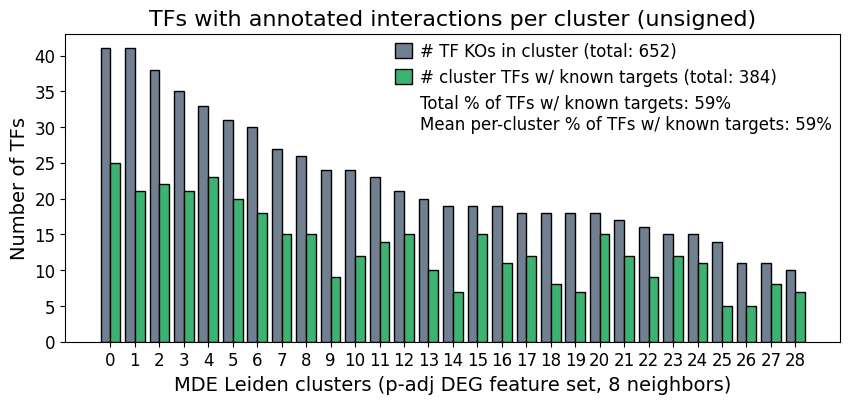

In [ ]:
plot_n_cluster_tfs_in_db(unsigned_summary8_padj0pt05, 
                         "TFs with annotated interactions per cluster (unsigned)",
                         xlabel="MDE Leiden clusters (p-adj DEG feature set, 8 neighbors)",
                         color2="mediumseagreen")

In [58]:
# plot_n_cluster_tfs_in_db(signed_hi_conf_summary8, 
#                          "TFs with annotated interactions per cluster (signed, high confidence)",
#                          xlabel="MDE Leiden clusters (HVG feature set, 8 neighbors)",
#                          color2="tab:purple")

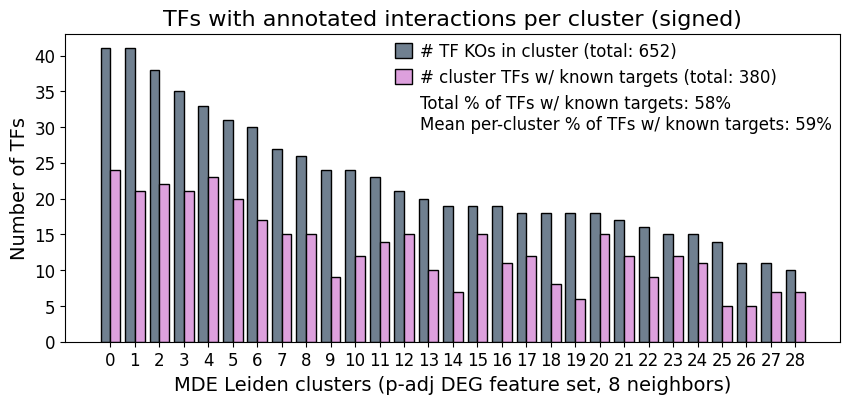

In [65]:
plot_n_cluster_tfs_in_db(signed_summary8_padj0pt05, 
                         "TFs with annotated interactions per cluster (signed)",
                         xlabel="MDE Leiden clusters (p-adj DEG feature set, 8 neighbors)",
                         color2="plum")

In [60]:
# plot_n_cluster_tfs_in_db(signed_ko_lof_summary8, 
#                          "TFs with annotated interactions per cluster (signed, KO/LOF only)",
#                          xlabel="MDE Leiden clusters (HVG feature set, 8 neighbors)",
#                          color2="orange")

In [61]:
# plot_n_cluster_tfs_in_db(signed_dor_summary8, 
#                          "TFs with annotated interactions per cluster (signed, DoRothEA A/B)",
#                          xlabel="MDE Leiden clusters (HVG feature set, 8 neighbors)",
#                          color2="tab:purple")

In [62]:
# plot_n_cluster_tfs_in_db(signed_dor_pert_summary8, 
#                          "TFs with annotated interactions per cluster (signed, DoRothEA A/B and KO/KD/LOF expts)",
#                          xlabel="MDE Leiden clusters (HVG feature set, 8 neighbors)",
#                          color2="orange")

### Plot number of target genes per cluster (unsigned)

In [47]:
def plot_n_cluster_genes_in_db_unsigned(cluster_df, title, xlabel, color, ymax=None):
    xvals = cluster_df.index.tolist()
    yvals = cluster_df["# target genes"].tolist()
    fig, ax = plt.subplots(figsize=(10,4))
    ax = sns.barplot(x=xvals, y=yvals, facecolor=color, edgecolor='black', linewidth=1)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel('Number of target genes', fontsize=14)
    if ymax:
        ax.set_ylim(0, ymax)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.bar_label(ax.containers[0], fontsize=12, rotation=90, padding=5)
    ax.set_title(title, fontsize=13)

    # Mean and median genes per cluster
    # box = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    # mean_n = round(np.mean(np.array(yvals)))
    # median_n = round(np.median(np.array(yvals)))
    # ax.text(x=14, y=0, s=f"Mean # genes per cluster: {mean_n}\nMedian # genes per cluster: {median_n}", fontsize=12)

    plt.show()

2025-06-08 20:30:27 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-08 20:30:27 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


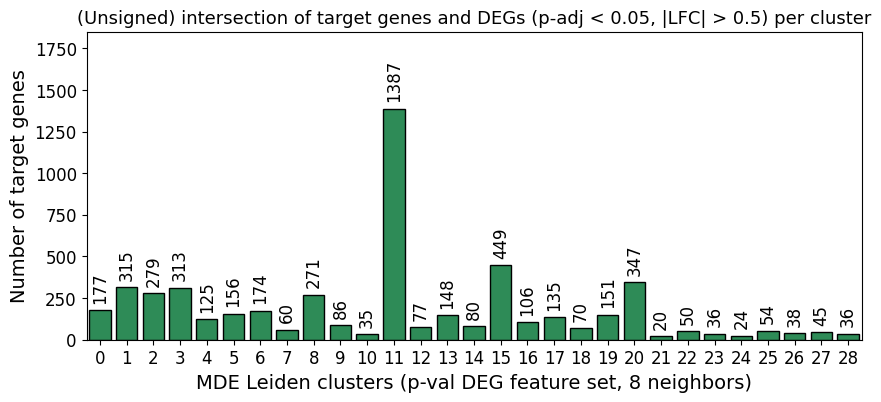

In [21]:
plot_n_cluster_genes_in_db_unsigned(unsigned_summary8_lfc0pt5, 
    title="(Unsigned) intersection of target genes and DEGs (p-adj < 0.05, |LFC| > 0.5) per cluster",
                                    xlabel="MDE Leiden clusters (p-val DEG feature set, 8 neighbors)",
                                    color="seagreen", ymax=1850)

2025-06-08 21:06:11 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-08 21:06:11 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


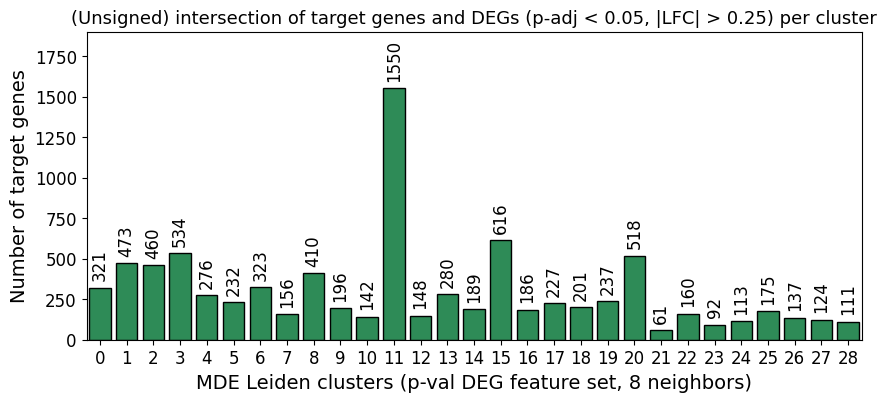

In [49]:
plot_n_cluster_genes_in_db_unsigned(unsigned_summary8_lfc0pt25, 
    title="(Unsigned) intersection of target genes and DEGs (p-adj < 0.05, |LFC| > 0.25) per cluster",
                                    xlabel="MDE Leiden clusters (p-val DEG feature set, 8 neighbors)",
                                    color="seagreen", ymax=1900)

2025-06-08 20:30:37 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-08 20:30:37 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


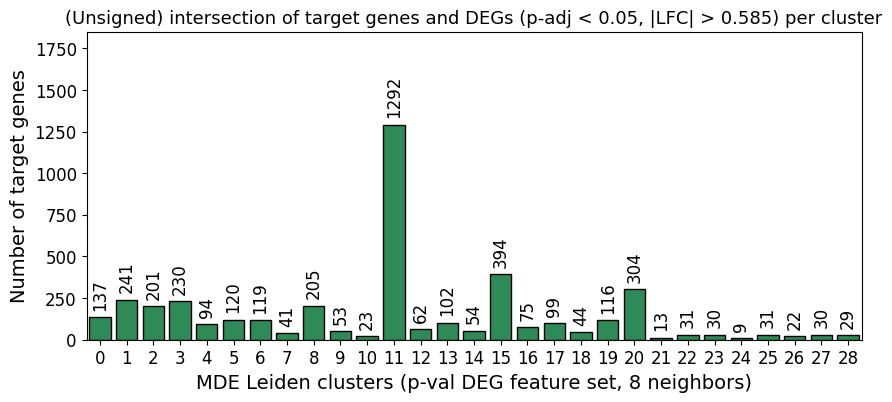

In [22]:
plot_n_cluster_genes_in_db_unsigned(unsigned_summary8_lfc0pt585, 
    title="(Unsigned) intersection of target genes and DEGs (p-adj < 0.05, |LFC| > 0.585) per cluster",
                                    xlabel="MDE Leiden clusters (p-val DEG feature set, 8 neighbors)",
                                    color="seagreen", ymax=1850)

### Plot number of up/downregulated genes per cluster

In [91]:
def plot_up_down_genes(cluster_df, title, xlabel=None, ymax=None, legend=True):
    categories = cluster_df.index.tolist()
    vals1 = cluster_df["# genes UP only"].tolist()
    vals2 = cluster_df["# genes DOWN only"].tolist()
    label1 = "Upregulated"
    label2 = "Downregulated"

    fig, ax = plt.subplots(figsize=(12,4))
    w, x = 0.4, np.arange(len(categories))
    up = ax.bar(x-w/2, vals1, w, label=label1, edgecolor="black", linewidth=1, facecolor="indianred")
    down = ax.bar(x+w/2, vals2, w, label=label2, edgecolor="black", linewidth=1, facecolor="cornflowerblue")

    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.set_xlabel(xlabel, fontsize=14) if xlabel else \
        ax.set_xlabel('MDE Leiden Cluster', fontsize=14)
    ax.set_ylabel('Number of Genes', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.bar_label(up, labels=[str(v) for v in vals1], rotation=90, padding=6, fontsize=11)
    ax.bar_label(down, labels=[str(v) for v in vals2], rotation=90, padding=6, fontsize=11)
    ax.set_title(title, fontsize=14)
    if legend:
        ax.legend(loc='best', fontsize=12)
    if ymax:
        ax.set_ylim(0, ymax)
    plt.show()

In [145]:
# plot_up_down_genes(signed_hi_conf_summary8, 
#                     "Expected up/down target genes per TF KO cluster (high confidence)",
#                     xlabel="MDE Leiden clusters (HVG feature set, 8 neighbors)", ymax=3500)

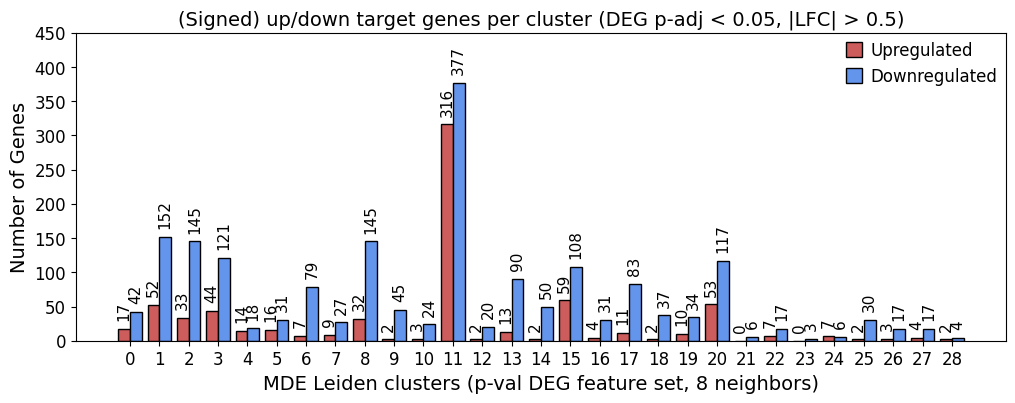

In [93]:
# Formerly "medium confidence"
plot_up_down_genes(signed_summary8_lfc0pt5, 
                    "(Signed) up/down target genes per cluster (DEG p-adj < 0.05, |LFC| > 0.5)",
                    xlabel="MDE Leiden clusters (p-val DEG feature set, 8 neighbors)", ymax=450)

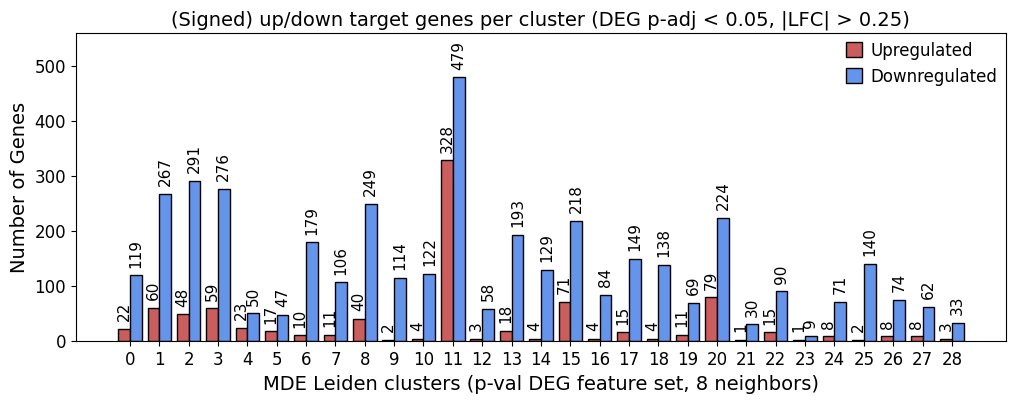

In [95]:
plot_up_down_genes(signed_summary8_lfc0pt25, 
                    "(Signed) up/down target genes per cluster (DEG p-adj < 0.05, |LFC| > 0.25)",
                    xlabel="MDE Leiden clusters (p-val DEG feature set, 8 neighbors)", ymax=560)

In [72]:
# plot_up_down_genes(signed_ko_lof_summary8, 
#                     "Expected up/down target genes per TF KO cluster (from KO/LOF experiments only)",
#                     xlabel="MDE Leiden clusters (HVG feature set, 8 neighbors)", ymax=3500)

In [42]:
# plot_up_down_genes(signed_dor_summary8, 
#                     "Expected up/down target genes per TF KO cluster (DoRothEA A/B)",
#                     xlabel="MDE Leiden clusters (HVG feature set, 8 neighbors)", ymax=3500)

In [41]:
# plot_up_down_genes(signed_dor_pert_summary8, 
#                     "Expected up/down target genes per TF KO cluster (DoRothEA A/B and KO/LOF expts)",
#                     xlabel="MDE Leiden clusters (HVG feature set, 8 neighbors)", ymax=3500)

In [73]:
def plot_up_down_both_genes(cluster_df, title, xlabel=None, ymax=None, legend=True):
    categories = cluster_df.index.tolist()
    vals1 = cluster_df["# genes UP only"].tolist()
    vals2 = cluster_df["# genes DOWN only"].tolist()
    vals3 = cluster_df["# genes BOTH"].tolist()
    label1 = "Upregulated only"
    label2 = "Downregulated only"
    label3 = "Both"

    fig, ax = plt.subplots(figsize=(10,4))
    w, x = 0.3, np.arange(len(categories))
    ax.bar(x-w, vals1, w, label=label1, edgecolor="black", linewidth=0.5, facecolor="tab:red")
    ax.bar(x, vals2, w, label=label2, edgecolor="black", linewidth=0.5, facecolor="tab:blue")
    ax.bar(x+w, vals3, w, label=label3, edgecolor="black", linewidth=0.5, facecolor="tab:purple")

    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.set_xlabel(xlabel, fontsize=14) if xlabel else \
        ax.set_xlabel('MDE Leiden Cluster', fontsize=14)
    ax.set_ylabel('Number of Genes', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_title(title)
    if legend:
        ax.legend(loc='best', fontsize=12)
    if ymax:
        ax.set_ylim(0, ymax)
    plt.show()

In [178]:
# plot_up_down_both_genes(signed_hi_conf_summary8, 
#                     "Expected up/down target genes per TF KO cluster (high confidence)",
#                     xlabel="MDE Leiden clusters (HVG feature set, 8 neighbors)", ymax=3500)

In [96]:
# plot_up_down_both_genes(signed_summary8_padj0pt05, 
#                     "Expected up/down/both target genes per TF KO cluster",
#                     xlabel="MDE Leiden clusters (HVG feature set, 8 neighbors)")

In [76]:
# plot_up_down_both_genes(signed_ko_lof_summary8, 
#                     "Expected up/down target genes per TF KO cluster (from KO/LOF experiments only)",
#                     xlabel="MDE Leiden clusters (HVG feature set, 8 neighbors)", ymax=3500)

Based on these results, we will use the unsigned and the signed (medium confidence) TF-target interaction sets moving forward, since they have the greatest cluster coverage. We will generate graphs for the signed set with edited labels.

### Plots with 10 k-nearest neighbors for Leiden clustering

Read in TF KOs per cluster in MDE generated with p-val DEGs as features and 10 k-nearest neighbors for Leiden clustering

In [50]:
clusters_10nbrs = pd.read_csv("/home/ranwyl/results_tf_project/tf_ko_clusters_degs_pval_10_nbrs.csv", header=0, index_col=0)
clusters_10nbrs.head()

0        1      2       3       4        5        6        7       8  \
0  ARID3A     AIRE  ADNP2  ANKZF1   ASCL2    ARID2   BARHL1    BARX1   BCL6B   
1   ATF6B   ARID3B   CDX1     ARX   CENPX    ASH1L  BHLHE22    BAZ2A  CSRNP2   
2   CEBPD    ASCL1   CREM  CC2D1A    DLX2   CCDC17   DMRTB1  BHLHE40   EPAS1   
3   CENPS  CREB3L4   FOSB   DEAF1  DMRTA2    CEBPA     ETS1      BSX   ESRRA   
4   CREB5  FLYWCH1  FOSL2    EMX1  DMRTC2  CREB3L3    FOXD3    FIGLA   GATA1   

        9  ...     15       16     17        18       19      20       21  \
0  BHLHA9  ...  AEBP1  BHLHE41  DMRT2  ARHGAP35    ASCL3  CREBL2  BHLHA15   
1   ESRRB  ...   ARNT     DLX6  ESRRG     ATMIN    DMBX1   CTCFL    CXXC1   
2    ETV5  ...  ATOH7    FOXS1   ISL2    CHAMP1     ETV1    ESX1     ETS2   
3     GSC  ...   ELF3     IRF9  KMT2B     DNMT1    FOXQ1   FOSL1    GRHL2   
4    IRF8  ...    ERF    MECOM  MEOX1     DOT1L  GATAD2B   FOXD4    KLF10   

      22       23      24  
0  HNF1A    ARNT2     DR1  
1    LTF    ASCL5   DRAP1  
2   RFX7     EBF3    ESR1  
3  RUNX3  L3MBTL4  HIVEP2  
4   SOX1   PLSCR1  POU3F3  

[5 rows x 25 columns]

In [ ]:
# |LFC| > 0.5, p-adj < 0.05
unsigned_targets10_padj0pt05, unsigned_summary10_padj0pt05 = \
    find_tf_targets_per_cluster(clusters_10nbrs, de_results, full_tf_target_dict_unsigned, padj_thr=0.05)
unsigned_summary10_padj0pt05.head()

# TF KOs  # target genes  # cluster TFs w/ known targets  \
Cluster                                                             
0              45             175                              21   
1              42            2030                              29   
2              41             177                              25   
3              41             315                              21   
4              39             282                              23   

        % cluster TFs w/ known targets  
Cluster                                 
0                                  47%  
1                                  69%  
2                                  61%  
3                                  51%  
4                                  59%

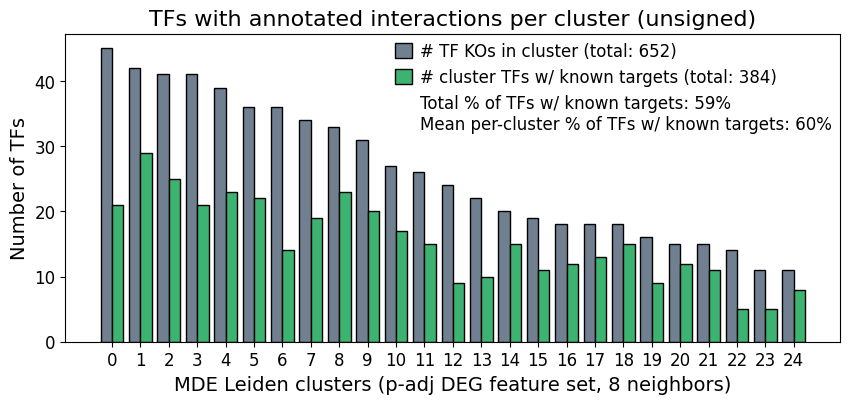

In [93]:
plot_n_cluster_tfs_in_db(unsigned_summary10_padj0pt05, 
                         "TFs with annotated interactions per cluster (unsigned)",
                         xlabel="MDE Leiden clusters (p-adj DEG feature set, 8 neighbors)",
                         color2="mediumseagreen")

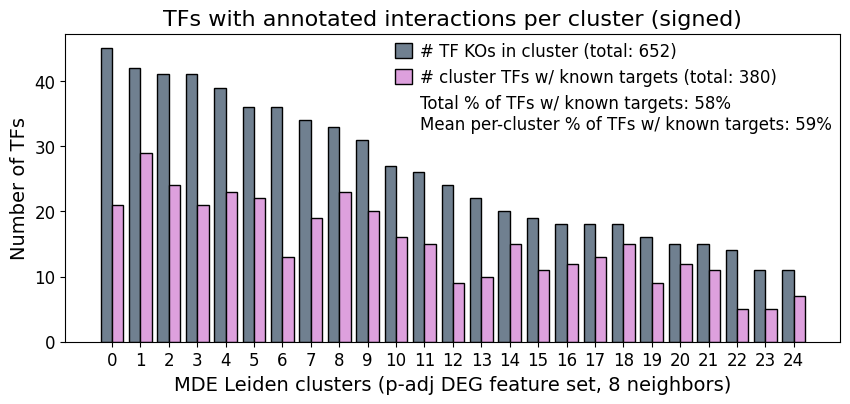

In [94]:
plot_n_cluster_tfs_in_db(signed_summary10_padj0pt05, 
                         "TFs with annotated interactions per cluster (signed)",
                         xlabel="MDE Leiden clusters (p-adj DEG feature set, 8 neighbors)",
                         color2="plum")

2025-06-08 04:14:20 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-08 04:14:20 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


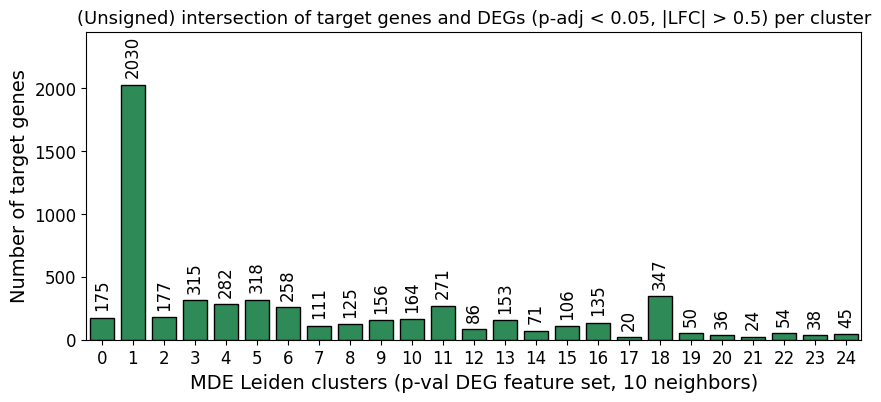

In [86]:
plot_n_cluster_genes_in_db_unsigned(unsigned_summary10_padj0pt05, 
    title="(Unsigned) intersection of target genes and DEGs (p-adj < 0.05, |LFC| > 0.5) per cluster",
                                    xlabel="MDE Leiden clusters (p-val DEG feature set, 10 neighbors)",
                                    color="seagreen", ymax=2450)

In [51]:
# |LFC| > 0.5, p-adj < 0.05
signed_targets10_lfc0pt5, signed_summary10_lfc0pt5 = \
    find_tf_targets_per_cluster(clusters_10nbrs, de_results, signed_tf_target_dict)
signed_summary10_lfc0pt5.head()

# TF KOs  # genes UP only  # genes DOWN only  # genes BOTH  \
Cluster                                                               
0              45               15                 93             0   
1              42              431                514            18   
2              41               17                 42             0   
3              41               52                152             0   
4              39               33                148             0   

         # cluster TFs w/ known targets % cluster TFs w/ known targets  
Cluster                                                                 
0                                    21                            47%  
1                                    29                            69%  
2                                    24                            59%  
3                                    21                            51%  
4                                    23                            59%

In [52]:
# |LFC| > 0.25, p-adj < 0.05
signed_targets10_lfc0pt25, signed_summary10_lfc0pt25 = \
    find_tf_targets_per_cluster(clusters_10nbrs, de_results, 
                                signed_tf_target_dict, padj_thr=0.05, lfc_thr=0.25)
signed_summary10_lfc0pt25.head()

# TF KOs  # genes UP only  # genes DOWN only  # genes BOTH  \
Cluster                                                               
0              45               19                211             0   
1              42              447                632            35   
2              41               22                119             3   
3              41               60                267             1   
4              39               48                295             2   

         # cluster TFs w/ known targets % cluster TFs w/ known targets  
Cluster                                                                 
0                                    21                            47%  
1                                    29                            69%  
2                                    24                            59%  
3                                    21                            51%  
4                                    23                            59%

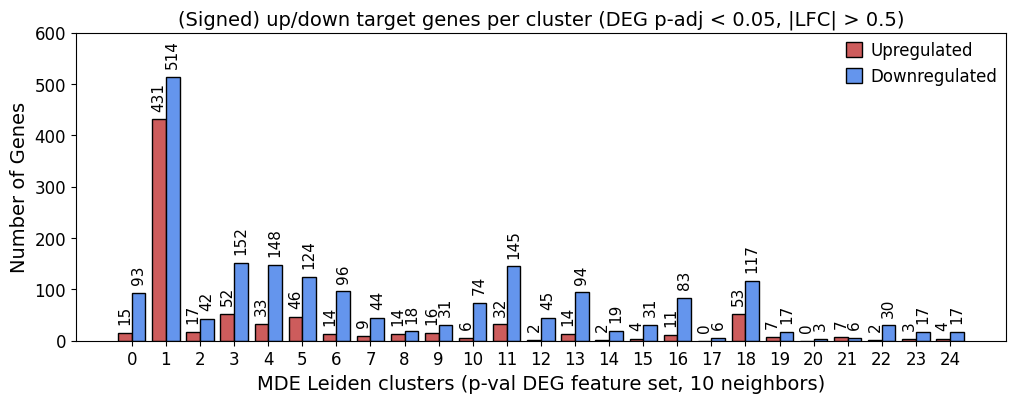

In [53]:
plot_up_down_genes(signed_summary10_lfc0pt5, 
                    "(Signed) up/down target genes per cluster (DEG p-adj < 0.05, |LFC| > 0.5)",
                    xlabel="MDE Leiden clusters (p-val DEG feature set, 10 neighbors)", ymax=600)

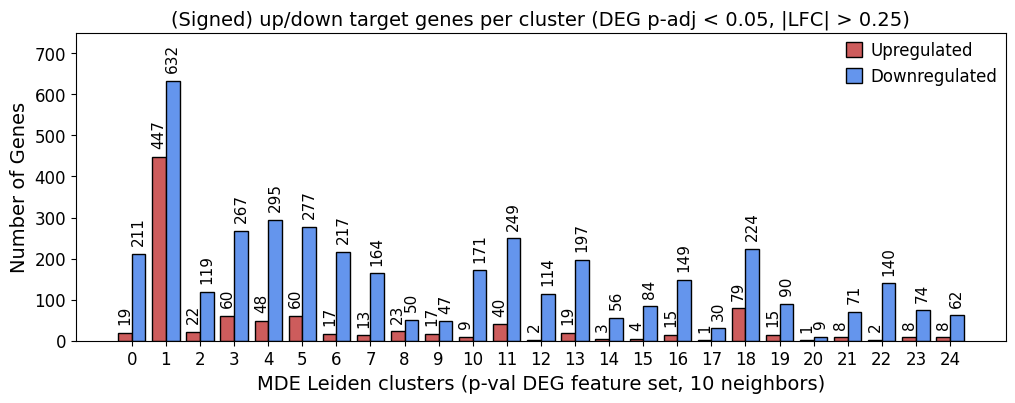

In [56]:
plot_up_down_genes(signed_summary10_lfc0pt25, 
                    "(Signed) up/down target genes per cluster (DEG p-adj < 0.05, |LFC| > 0.25)",
                    xlabel="MDE Leiden clusters (p-val DEG feature set, 10 neighbors)", ymax=750)

In [ ]:
# ko_lof_targets10, ko_lof_summary10 = find_tf_targets_per_cluster(clusters_10nbrs, signed_ko_lof_target_dict)
# ko_lof_summary10.head()

In [ ]:
# plot_n_cluster_tfs_in_db(ko_lof_summary10, 
#                          "TFs with annotated interactions per cluster (signed, KO/LOF only)",
#                          xlabel="MDE Leiden clusters (HVG feature set, 10 neighbors)",
#                          color2="tab:red")

## ORA with g:Profiler web tool

First we will perform ORA on the up- and downregulated genes of each cluster if there are >= 9 or 10 genes in the set. We will use the Excel file saved in the previous section and use the g:Profiler web tool.

## ORA with gseapy

Now we will perform ORA using gseapy.

In [108]:
pd.set_option('display.max_colwidth', 100)

In [109]:
print_dict(signed_targets8_lfc0pt25)

0: {'UP': {'CALD1', 'LINGO2', 'KIF5B', 'HUWE1', 'TRIO', 'TNRC6A', 'APP', 'IGF1R', 'RERE', 'NBEA', 'ITPR2', 'GRIA4', 'FNDC3B', 'BPTF', 'LPP', 'RBM25', 'UTRN', 'MYO10', 'PRKG1', 'USP9X', 'KIF1B', 'NAV2'}, 'DOWN': {'TPT1', 'TERF1', 'RPL37A', 'RCN2', 'DEK', 'PPIA', 'RPL29', 'RPLP0', 'PPP1CC', 'EEF2', 'RPS15A', 'RPL32', 'RPS4X', 'GPX4', 'HSP90AB1', 'RPS11', 'PTMA', 'CCT4', 'PTMS', 'MT-ND5', 'CD9', 'RPL18A', 'MYL6', 'LDHA', 'SRSF3', 'MT-ATP8', 'SUMO2', 'HMGN2', 'NME2', 'NACA', 'EIF4A1', 'CD63', 'RPL8', 'CFL1', 'ACTG1', 'RPL7A', 'RACK1', 'RPS14', 'RPLP1', 'RPL30', 'MT-ND2', 'HNRNPC', 'HACD3', 'GAPDH', 'DPYSL2', 'CALR', 'HINT1', 'RPL10A', 'EIF4H', 'UBB', 'TMEM106C', 'RPL6', 'IMPDH2', 'RPS23', 'MT-CO2', 'TOMM20', 'HNRNPA1', 'TRIM2', 'MT-ND3', 'RPS10', 'RPL7', 'RPS2', 'CALM2', 'EEF1A1', 'RPS24', 'MT-CYB', 'RPL27', 'PDIA6', 'RPL18', 'FTL', 'PPIB', 'TMSB10', 'ZNF398', 'RPS7', 'EIF1', 'PCBP1', 'UCHL1', 'CKB', 'RPL34', 'ATP6V1G1', 'RPL11', 'RAD21', 'RPS5', 'HSP90AA1', 'RPS29', 'RPL13A', 'MLEC', 'RPL

See which Enrichr gene sets we can use:

In [6]:
all_libs = gp.get_library_name(organism='Human')
print([lib for lib in all_libs if "GO" in lib])
print([lib for lib in all_libs if "Hallmark" in lib])
print([lib for lib in all_libs if "Reactome" in lib])

['GO_Biological_Process_2013', 'GO_Biological_Process_2015', 'GO_Biological_Process_2017', 'GO_Biological_Process_2017b', 'GO_Biological_Process_2018', 'GO_Biological_Process_2021', 'GO_Biological_Process_2023', 'GO_Biological_Process_2025', 'GO_Cellular_Component_2013', 'GO_Cellular_Component_2015', 'GO_Cellular_Component_2017', 'GO_Cellular_Component_2017b', 'GO_Cellular_Component_2018', 'GO_Cellular_Component_2021', 'GO_Cellular_Component_2023', 'GO_Cellular_Component_2025', 'GO_Molecular_Function_2013', 'GO_Molecular_Function_2015', 'GO_Molecular_Function_2017', 'GO_Molecular_Function_2017b', 'GO_Molecular_Function_2018', 'GO_Molecular_Function_2021', 'GO_Molecular_Function_2023', 'GO_Molecular_Function_2025', 'SynGO_2022', 'SynGO_2024']
['MSigDB_Hallmark_2020']
['Reactome_2013', 'Reactome_2015', 'Reactome_2016', 'Reactome_2022', 'Reactome_Pathways_2024']


ORA code

In [7]:
background_genes_filepath = "/home/ranwyl/results_tf_project/ora_background_genes.txt"
def ora_gseapy_full(cluster_dict, source_list, signed=True, min_genes=9):
    """
    Run ORA on all clusters using gseapy.
    """
    # Helper function to run ORA on single gene list using gseapy
    def ora_gseapy_query(gene_list, source_list):
        enr = gp.enrichr(gene_list=gene_list,
                    gene_sets=source_list,
                    organism='human',
                    background=background_genes_filepath,
                    outdir=None, # do not write to disk
                    )
        return enr.results # Return DataFrame of results

    # Run ORA on all clusters and save results in DF
    all_dfs_list = list()
    cluster_nums = sorted(list(cluster_dict.keys()))
    
    for i in tqdm(range(len(cluster_nums)), desc="Processing cluster number"):
        if signed == True: 
            for direction in "UP", "DOWN":
                cluster_genes = list(cluster_dict[i][direction])
                if len(cluster_genes) >= min_genes:
                    ora_df_full = ora_gseapy_query(cluster_genes, source_list)
                    # Add cluster number and up/down
                    ora_df_full.insert(0, "UP/DOWN", [direction]*ora_df_full.shape[0])
                    ora_df_full.insert(0, "Cluster", [i]*ora_df_full.shape[0])
                    all_dfs_list.append(ora_df_full)
        else:
            cluster_genes = list(cluster_dict[i])
            if len(cluster_genes) >= 5:
                ora_df_full = ora_gseapy_query(cluster_genes, source_list)
                # Add cluster number
                ora_df_full.insert(0, "Cluster", [i]*ora_df_full.shape[0])
                all_dfs_list.append(ora_df_full)

    full_df = pd.concat(all_dfs_list)
    return full_df

def filter_gseapy_results(full_df, signed=True, n_top_results=5, columns=6, 
                          gene_sets=None, sort_by="Adjusted P-value"):
    """
    Build combined DF of top terms for each cluster. 
    """
    top_df_list = list()
    cluster_nums = full_df["Cluster"].unique().tolist()
    for cluster in cluster_nums:
        if signed == True:
            for direction in "UP", "DOWN":
                if gene_sets:
                    cluster_dir_df = full_df[(full_df["Cluster"] == cluster) & 
                                            (full_df["UP/DOWN"] == direction) &
                                            (full_df["Gene_set"].isin(gene_sets))]
                else:
                    cluster_dir_df = full_df[(full_df["Cluster"] == cluster) & 
                                            (full_df["UP/DOWN"] == direction)]
                cluster_dir_df = cluster_dir_df.sort_values(sort_by)[:n_top_results]
                top_df_list.append(cluster_dir_df)
        elif signed == False:
            if gene_sets:
                cluster_dir_df = full_df[(full_df["Cluster"] == cluster) &
                                        (full_df["Gene_set"].isin(gene_sets))]
            else:
                cluster_dir_df = full_df[full_df["Cluster"] == cluster]
            cluster_dir_df = cluster_dir_df.sort_values(sort_by)[:n_top_results]
            top_df_list.append(cluster_dir_df)
    top_df = pd.concat(top_df_list)
    if type(columns) == int:
        filtered_df = top_df.iloc[:,:columns]
    elif type(columns) == list:
        filtered_df = top_df[columns]
    return filtered_df

def plot_shared_top_terms_gseapy(filtered_df, title, go, 
                                 signed=True, n_pathways=5, fig_size=(5, 6)):
    """
    Plot top term(s) shared by multiple clusters. 
    """
    xmax = filtered_df["Cluster"].nunique() + 1
    if go:
        abbrev_dict = {"GO_Biological_Process_2025":"GO:BP", 
                "GO_Cellular_Component_2025":"GO:CC", 
                "GO_Molecular_Function_2025":"GO:MF"}
        filtered_df["Gene_set"] = filtered_df["Gene_set"].replace(abbrev_dict)
        filtered_df["Term"] = filtered_df["Term"].str.split("(").str.get(0)
        filtered_df["name and source"] = \
            filtered_df["Term"] + "(" + filtered_df["Gene_set"] + ")"
    
    if signed == True:
        dir_df_list = list()
        for direction in "UP", "DOWN":
            dir_df = filtered_df[filtered_df["UP/DOWN"] == direction]
            if go:
                dir_df = pd.DataFrame(dir_df['name and source'].value_counts().head(n_pathways))
            else:
                dir_df = pd.DataFrame(dir_df['Term'].value_counts().head(n_pathways))
            dir_df_list.append(dir_df)

        df_up, df_down = dir_df_list[0], dir_df_list[1]
        df_up = df_up.reset_index()
        df_up.columns = ["Term", "Count"]
        df_down = df_down.reset_index()
        df_down.columns = ["Term", "Count"]

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=fig_size)
        sns.barplot(data=df_up, x="Count", y="Term", orient="h", ax=ax1, color="indianred", height=0.5)
        sns.barplot(data=df_down, x="Count", y="Term", orient="h", ax=ax2, color="cornflowerblue", height=0.5)
        plt.rcParams.update({"font.size":14})
        for ax in (ax1, ax2):
            ax.set_xlim(0, xmax)
            ax.set_ylabel("")
        ax1.set_xlabel("")
        ax2.set_xlabel("Number of clusters", fontsize=14)
        ax1a = ax1.twinx()
        ax1a.set_ylabel("Upregulated genes", fontsize=14)
        ax2a = ax2.twinx()
        ax2a.set_ylabel("Downregulated genes", fontsize=14)
        for ax in ax1a, ax2a:
            ax.tick_params(axis='y', which='both', right=False)
            ax.set_yticklabels([])
        fig.suptitle(title, fontsize=15, y=0.95)
    
    elif signed == False:
        if go:
            res_df = pd.DataFrame(filtered_df['name and source'].value_counts().head(n_pathways))
        else:
            res_df = pd.DataFrame(filtered_df['Term'].value_counts().head(n_pathways))
        res_df = res_df.reset_index()
        res_df.columns = ["Term", "Count"]
        
        fig, ax = plt.subplots(figsize=(5,3))
        ax = sns.barplot(data=res_df, x="Count", y="Term", orient="h", color="mediumseagreen", height=0.5)
        plt.rcParams.update({"font.size":14})
        ax.set_xlim(0, xmax)
        ax.set_ylabel("")
        ax.set_xlabel("Number of clusters", fontsize=14)
        fig.suptitle(title, fontsize=15, y=0.95)

### Test out code with one cluster at a time

In [169]:
background_genes_filepath = "/home/ranwyl/results_tf_project/ora_background_genes.txt"
def ora_gseapy_query1(gene_list: list, sources):
    enr = gp.enrichr(gene_list=gene_list,
                 gene_sets=sources,
                 organism='human',
                 background=background_genes_filepath,
                 outdir=None, # do not write to disk
                )
    return enr.results # Return DataFrame of results

In [183]:
genes_0_up = sorted(list(signed_targets8[0]["UP"]))
genes_1_up = sorted(list(signed_targets8[1]["UP"]))
print(genes_0_up[:10])
print(genes_1_up[:10])

['A2M', 'AAED1', 'AARS', 'ABAT', 'ABCA1', 'ABCA3', 'ABCC3', 'ABCE1', 'ABCG1', 'ABCG2']
['A4GALT', 'AAK1', 'ABAT', 'ABCB7', 'ABCC2', 'ABCC3', 'ABCC4', 'ABCE1', 'ABCF1', 'ABCG2']


GO

In [153]:
go_gene_sets = ["GO_Biological_Process_2025", "GO_Cellular_Component_2025", "GO_Molecular_Function_2025"]

In [186]:
cluster0_up = ora_gseapy_query1(genes_0_up, go_gene_sets)

In [187]:
cluster0_up.head()

Gene_set  \
0  GO_Biological_Process_2025   
1  GO_Biological_Process_2025   
2  GO_Biological_Process_2025   
3  GO_Biological_Process_2025   
4  GO_Biological_Process_2025   

                                                              Term  \
0                     Regulation of Apoptotic Process (GO:0042981)   
1                             Cytoplasmic Translation (GO:0002181)   
2                       Regulation of Gene Expression (GO:0010468)   
3  Positive Regulation of DNA-templated Transcription (GO:0045893)   
4            Negative Regulation of Apoptotic Process (GO:0043066)   

        P-value  Adjusted P-value  Old P-value  Old adjusted P-value  \
0  1.313617e-85      6.080733e-82            0                     0   
1  2.788492e-57      6.453965e-54            0                     0   
2  4.784778e-52      7.382912e-49            0                     0   
3  6.949403e-52      8.042197e-49            0                     0   
4  4.486509e-51      3.791756e-48            0                     0   

   Odds Ratio  Combined Score  \
0    7.292143     1425.227092   
1   32.683978     4256.168097   
2    4.014120      474.344525   
3    3.774089      444.571765   
4    6.372109      738.723503   

                                                                             Genes  
0  TFRC;PHB2;IFIT3;CCAR1;IFIT2;UXT;LGALS3;MYC;TNFSF10;AKT1;SOX9;IER3;MEF2C;ACTN...  
1  EIF4A2;RPL4;EIF4A1;RPL5;RPL3;RPL32;RPL31;RPL34;RPLP0;RPL10A;RPL8;RPL9;RPL6;R...  
2  RPL5;SPI1;TFRC;TSKU;RPL6;UBE2L3;RPS6KA5;MYC;GPBP1;MYB;NAMPT;AKT1;IL12B;ADNP2...  
3  EIF4A1;SPI1;HNRNPU;IL4I1;RPS6KA5;TRIM28;MYC;MYB;NAMPT;AKT1;SOX9;ATXN7L3;IER2...  
4  TFRC;ZFAND6;SERPINE1;PARK7;PHB2;TNF;IFIT3;IGF1R;CDH5;CCND2;MYC;ARHGDIA;PDK4;...

In [184]:
cluster1_up = ora_gseapy_query1(genes_1_up, go_gene_sets)

In [185]:
cluster1_up.head(2)

Gene_set                                          Term  \
0  GO_Biological_Process_2025  Regulation of Apoptotic Process (GO:0042981)   
1  GO_Biological_Process_2025          Cytoplasmic Translation (GO:0002181)   

        P-value  Adjusted P-value  Old P-value  Old adjusted P-value  \
0  2.370160e-62      1.093592e-58            0                     0   
1  1.392249e-49      3.211919e-46            0                     0   

   Odds Ratio  Combined Score  \
0    5.510493      781.924142   
1   25.051515     2818.188910   

                                                                             Genes  
0  FOXA1;PAGE4;MTCH1;APP;RTKN;TFRC;YEATS4;CIB1;PARK7;TNF;IFIT2;IGF1R;UXT;LGALS3...  
1  EIF4A2;RPL4;EIF4A1;RPL5;RPL30;RPL3;RPL32;RPL31;RPL34;RPLP0;RPL10A;RPL8;RPL9;...

Hallmark

In [174]:
cluster0_up_hallmark = ora_gseapy_query1(genes_0_up, ["MSigDB_Hallmark_2020"])

In [175]:
cluster0_up_hallmark.head()

Gene_set                           Term        P-value  \
0  MSigDB_Hallmark_2020                 Myc Targets V1  9.857244e-113   
1  MSigDB_Hallmark_2020               mTORC1 Signaling   1.320753e-53   
2  MSigDB_Hallmark_2020        Estrogen Response Early   1.624747e-47   
3  MSigDB_Hallmark_2020  TNF-alpha Signaling via NF-kB   1.315450e-45   
4  MSigDB_Hallmark_2020      Oxidative Phosphorylation   9.407161e-42   

   Adjusted P-value  Old P-value  Old adjusted P-value  Odds Ratio  \
0     4.928622e-111            0                     0   33.525081   
1      3.301882e-52            0                     0   12.867793   
2      2.707912e-46            0                     0   11.536557   
3      1.644312e-44            0                     0   11.146442   
4      9.407161e-41            0                     0   10.100238   

   Combined Score  \
0     8646.249392   
1     1566.767098   
2     1242.904176   
3     1151.897291   
4      954.140216   

                                                                             Genes  
0  EIF4A1;RPL34;HNRNPU;PWP1;PHB2;RPL6;UBE2L3;PSMD8;CDC20;EEF1B2;PSMD7;TRIM28;MY...  
1  CDKN1A;TFRC;PITPNB;UBE2D3;ITGB2;ARPC5L;SLC2A1;ATP2A2;PLOD2;ENO1;SLC7A11;TM7S...  
2  SCARB1;B4GALT1;WWC1;HSPB8;FHL2;SLC2A1;ABAT;AQP3;AREG;PRSS23;CELSR2;TSKU;RAPG...  
3  CDKN1A;CD83;B4GALT1;CSF1;SERPINE1;PLEK;TNC;TNFAIP2;TNFAIP3;LITAF;AREG;TNF;SA...  
4  COX7B;SLC25A3;COX4I1;MRPS12;ETFA;PHB2;COX7C;TOMM22;AIFM1;PDK4;IDH3B;UQCRFS1;...

In [176]:
cluster1_up_hallmark = ora_gseapy_query1(genes_1_up, ["MSigDB_Hallmark_2020"])

In [177]:
cluster1_up_hallmark.head()

Gene_set                               Term       P-value  \
0  MSigDB_Hallmark_2020                     Myc Targets V1  3.296870e-46   
1  MSigDB_Hallmark_2020      TNF-alpha Signaling via NF-kB  8.169159e-40   
2  MSigDB_Hallmark_2020                    G2-M Checkpoint  1.782333e-38   
3  MSigDB_Hallmark_2020                   mTORC1 Signaling  2.410970e-37   
4  MSigDB_Hallmark_2020  Epithelial Mesenchymal Transition  2.092950e-36   

   Adjusted P-value  Old P-value  Old adjusted P-value  Odds Ratio  \
0      1.648435e-44            0                     0   10.579994   
1      2.042290e-38            0                     0    9.348923   
2      2.970555e-37            0                     0    8.995348   
3      3.013712e-36            0                     0    8.729687   
4      2.092950e-35            0                     0    8.541245   

   Combined Score  \
0     1107.999874   
1      841.431443   
2      781.878478   
3      736.048937   
4      701.701597   

                                                                             Genes  
0  YWHAE;EIF4A1;SLC25A3;HSP90AB1;RPL34;RPLP0;HNRNPR;RPL6;EEF1B2;FBL;XPO1;MYC;RA...  
1  BTG3;CXCL6;CDKN1A;BTG1;SERPINE1;TNFAIP2;TNFAIP3;CXCL1;SLC2A3;LITAF;AREG;TNF;...  
2  TOP2A;JPT1;NUMA1;AMD1;KIF11;CTCF;MKI67;TENT4A;SMC4;LMNB1;CKS1B;MT2A;XPO1;PTT...  
3  ERO1A;CDKN1A;TFRC;UBE2D3;ITGB2;ARPC5L;SLC2A1;ATP2A2;PLOD2;SLC2A3;IFI30;FADS2...  
4  ITGB1;CXCL6;CXCL8;SERPINE2;ITGB5;SERPINE1;COL12A1;TNFAIP3;PLOD2;LAMC2;CXCL1;...

Reactome

In [178]:
cluster0_up_reac = ora_gseapy_query1(genes_0_up, ["Reactome_Pathways_2024"])

In [179]:
cluster0_up_reac.head()

Gene_set                           Term        P-value  \
0  Reactome_Pathways_2024                        Disease  9.131380e-138   
1  Reactome_Pathways_2024                  Immune System  6.337931e-136   
2  Reactome_Pathways_2024  Cellular Responses to Stimuli  5.332188e-129   
3  Reactome_Pathways_2024   Cellular Responses to Stress  3.651456e-121   
4  Reactome_Pathways_2024             Infectious Disease  3.141248e-120   

   Adjusted P-value  Old P-value  Old adjusted P-value  Odds Ratio  \
0     1.741354e-134            0                     0    5.749157   
1     6.043218e-133            0                     0    5.451383   
2     3.389494e-126            0                     0    8.549018   
3     1.740832e-118            0                     0    8.863198   
4     1.198072e-117            0                     0    7.476982   

   Combined Score  \
0     1814.117847   
1     1697.042869   
2     2525.035486   
3     2457.921487   
4     2057.408253   

                                                                             Genes  
0  RPL4;RPL5;RPL3;RPL32;RPL31;RPL34;SERPINE1;ENO1;RPL8;RPL9;RPL6;RPL7;PSMD8;PSM...  
1  PSMD8;PSMD6;PSMD7;AKT2;MYC;PSMD2;PSMD3;AKT1;JUNB;MEF2C;WSB1;NHLRC3;RNASE6;PS...  
2  RPL4;RPL5;RPL3;RPL32;MT-CO1;RPL31;RPL34;MT1X;PPP2R2A;RPL8;PHB2;RPL9;RPL6;RPL...  
3  RPL4;RPL5;RPL3;RPL32;MT-CO1;RPL31;RPL34;RPL8;PHB2;RPL9;RPL6;RPL7;PSMD8;RPS15...  
4  RPL4;RPL5;RPL3;RPL32;RPL31;RPL34;SERPINE1;ENO1;RPL8;RPL9;ACTB;RPL6;RPL7;PSMD...

In [180]:
cluster1_up_reac = ora_gseapy_query1(genes_1_up, ["Reactome_Pathways_2024"])

In [181]:
cluster1_up_reac.head()

Gene_set                           Term        P-value  \
0  Reactome_Pathways_2024                        Disease  4.677948e-123   
1  Reactome_Pathways_2024  Cellular Responses to Stimuli  3.243496e-118   
2  Reactome_Pathways_2024         Metabolism of Proteins  6.564452e-116   
3  Reactome_Pathways_2024                  Immune System  6.804932e-110   
4  Reactome_Pathways_2024   Cellular Responses to Stress  8.407258e-110   

   Adjusted P-value  Old P-value  Old adjusted P-value  Odds Ratio  \
0     8.771152e-120            0                     0    5.028272   
1     3.040778e-115            0                     0    7.521265   
2     4.102782e-113            0                     0    4.541258   
3     3.152722e-107            0                     0    4.491282   
4     3.152722e-107            0                     0    7.725106   

   Combined Score  \
0     1416.339062   
1     2034.715675   
2     1204.424368   
3     1128.958701   
4     1940.201014   

                                                                             Genes  
0  CYFIP2;RPL4;NCKAP1;RPL5;RPL30;RPL3;RPL32;RPL31;RPL34;SERPINE1;RBPJ;RPL8;RPL9...  
1  RPL4;RPL5;RPL30;RPL3;RPL32;MT-CO1;RPL31;RPL34;MT1X;RPL8;RPL9;RPL6;RPL7;RPS15...  
2  MT-ND6;RPL4;RPL5;RPL30;MT-ND5;RPL3;RPL32;MT-CO1;RPL31;RPL34;MT-ND2;RPL8;RPL9...  
3  CYFIP2;NCKAP1;PSMD2;MYC;WSB1;NUP210;PRKCE;PRKCD;ARMC8;UNC13D;RNF123;ORAI1;TX...  
4  RPL4;RPL5;RPL30;RPL3;RPL32;MT-CO1;RPL31;RPL34;RPL8;RPL9;RPL6;RPL7;RPS15;RPS1...

### GO

In [111]:
go_gene_sets = ["GO_Biological_Process_2025", "GO_Cellular_Component_2025", "GO_Molecular_Function_2025"]

In [112]:
signed_results_go8 = ora_gseapy_full(signed_targets8_lfc0pt25, go_gene_sets, signed=True)

Processing cluster number: 100%|██████████| 29/29 [04:55<00:00, 10.20s/it]


In [114]:
signed_results_go8.head(3)

Cluster UP/DOWN                    Gene_set  \
0        0      UP  GO_Biological_Process_2025   
1        0      UP  GO_Biological_Process_2025   
2        0      UP  GO_Biological_Process_2025   

                                                     Term   P-value  \
0                               Axonogenesis (GO:0007409)  0.000005   
1  Dense Core Granule Cytoskeletal Transport (GO:0099519)  0.000007   
2                Retrograde Axonal Transport (GO:0008090)  0.000039   

   Adjusted P-value  Old P-value  Old adjusted P-value  Odds Ratio  \
0          0.001287            0                     0   42.345805   
1          0.001287            0                     0  750.800000   
2          0.004070            0                     0  268.078571   

   Combined Score                 Genes  
0      514.495535  APP;TRIO;USP9X;KIF5B  
1     8926.629886           KIF5B;KIF1B  
2     2720.916515           KIF5B;KIF1B

In [115]:
# Save
signed_results_go8.to_pickle(
    "/home/ranwyl/results_tf_project/ora_tf_targets_signed_go_lfc0pt25_8nbrs.pkl")

In [ ]:
# Read in
signed_results_go8 = pd.read_pickle(
    "/home/ranwyl/results_tf_project/ora_tf_targets_signed_go_lfc0pt25_8nbrs.pkl")

Get top GO term(s) per cluster

In [116]:
# cols = ["Cluster", "Gene_set", "Term", "P-value", "Adjusted P-value", "Combined Score"]
# unsigned_top_go_term_per_cluster = \
#     filter_gseapy_results(signed_results_go, signed=False, n_top_results=1, columns=cols)
# unsigned_top_5_go_terms_per_cluster = \
#     filter_gseapy_results(signed_results_go, signed=False, n_top_results=5, columns=cols)

In [117]:
# unsigned_top_go_term_per_cluster.head(10)

In [117]:
cols = ["Cluster", "UP/DOWN", "Gene_set", "Term", "P-value", "Adjusted P-value", "Combined Score"]
signed_top_go_term_per_cluster8 = filter_gseapy_results(signed_results_go8, n_top_results=1, columns=cols)
signed_top_5_go_terms_per_cluster8 = filter_gseapy_results(signed_results_go8, n_top_results=5, columns=cols)

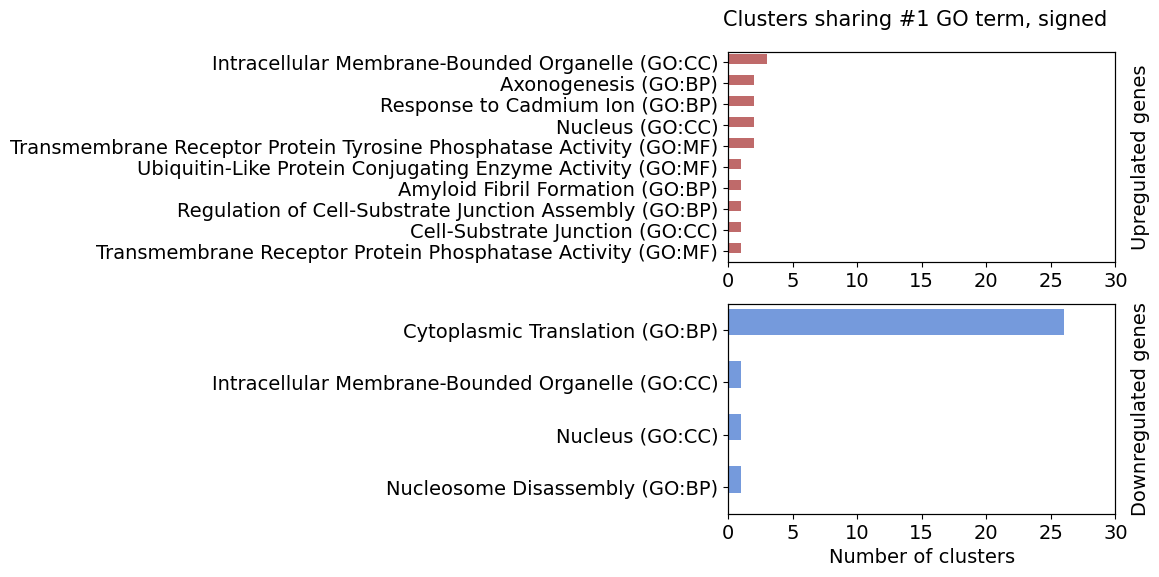

In [ ]:
plot_shared_top_terms_gseapy(signed_top_go_term_per_cluster8, 
                             "Clusters sharing #1 GO term, signed",
                             go=True, n_pathways=29)

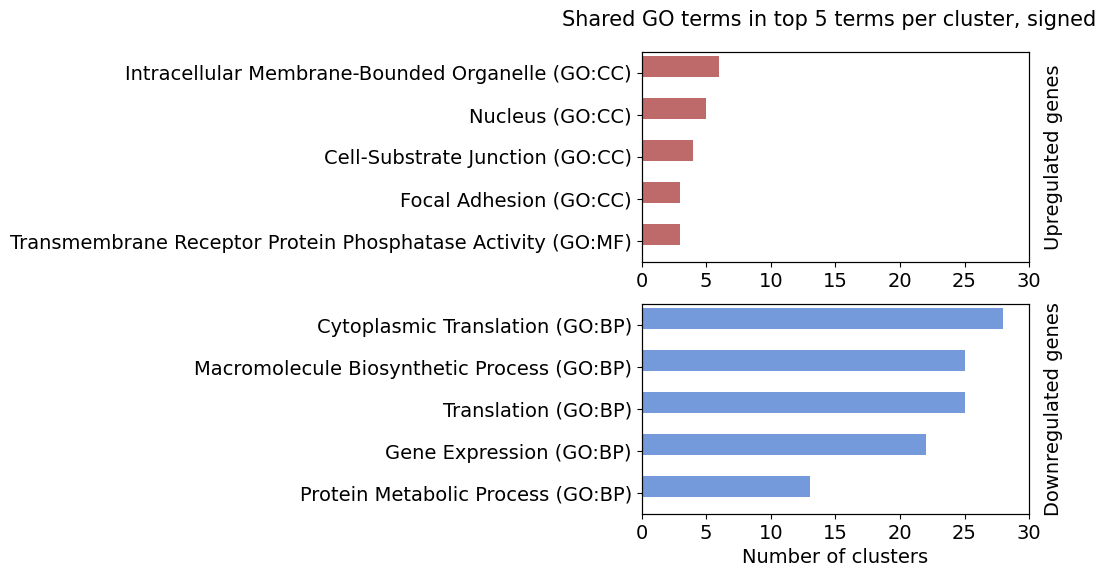

In [ ]:
plot_shared_top_terms_gseapy(signed_top_5_go_terms_per_cluster8, 
                                "Shared GO terms in top 5 terms per cluster, signed",
                                go=True, n_pathways=5)

In [128]:
signed_top_gobp_term_per_cluster8 = filter_gseapy_results(signed_results_go8, 
                                                         gene_sets=["GO_Biological_Process_2025"], 
                                                         n_top_results=1, columns=cols)
signed_top_5_gobp_terms_per_cluster8 = filter_gseapy_results(signed_results_go8, 
                                                         gene_sets=["GO_Biological_Process_2025"], 
                                                         n_top_results=5, columns=cols)

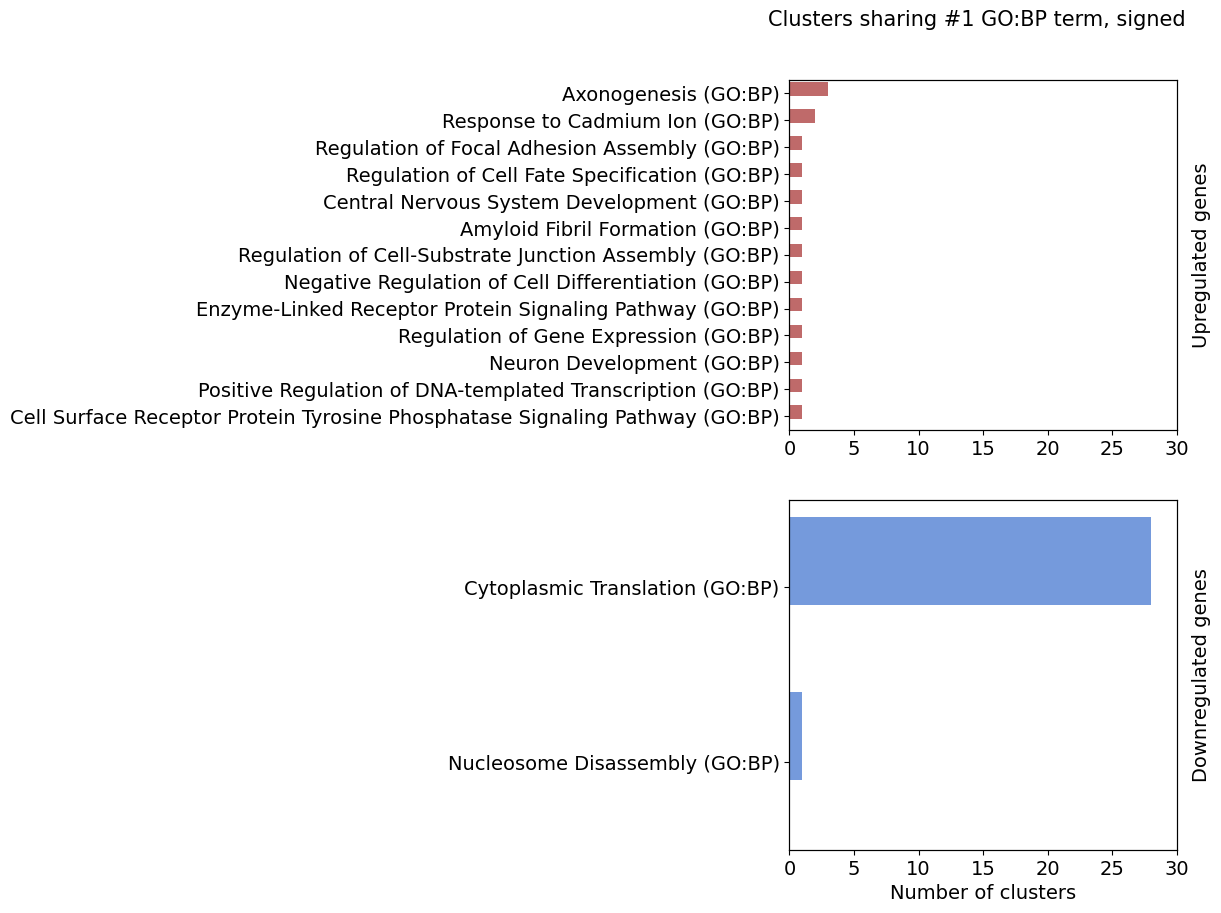

In [ ]:
plot_shared_top_terms_gseapy(signed_top_gobp_term_per_cluster8, 
                                "Clusters sharing #1 GO:BP term, signed",
                                go=True, n_pathways=29, fig_size=(5, 10))

In [123]:
signed_top_gobp_term_per_cluster8.iloc[:,[0,1,2,3,4]]

Cluster UP/DOWN Gene_set  \
0         0      UP    GO:BP   
0         0    DOWN    GO:BP   
0         1      UP    GO:BP   
0         1    DOWN    GO:BP   
0         2      UP    GO:BP   
0         2    DOWN    GO:BP   
0         3      UP    GO:BP   
0         3    DOWN    GO:BP   
0         4      UP    GO:BP   
0         4    DOWN    GO:BP   
0         5      UP    GO:BP   
0         5    DOWN    GO:BP   
14        6      UP    GO:BP   
0         6    DOWN    GO:BP   
0         7      UP    GO:BP   
0         7    DOWN    GO:BP   
1         8      UP    GO:BP   
0         8    DOWN    GO:BP   
0         9    DOWN    GO:BP   
0        10    DOWN    GO:BP   
0        11      UP    GO:BP   
0        11    DOWN    GO:BP   
0        12    DOWN    GO:BP   
0        13      UP    GO:BP   
0        13    DOWN    GO:BP   
0        14    DOWN    GO:BP   
0        15      UP    GO:BP   
0        15    DOWN    GO:BP   
0        16    DOWN    GO:BP   
0        17      UP    GO:BP   
0        17    DOWN    GO:BP   
0        18    DOWN    GO:BP   
0        19      UP    GO:BP   
0        19    DOWN    GO:BP   
0        20      UP    GO:BP   
0        20    DOWN    GO:BP   
0        21    DOWN    GO:BP   
0        22      UP    GO:BP   
0        22    DOWN    GO:BP   
0        23    DOWN    GO:BP   
0        24    DOWN    GO:BP   
0        25    DOWN    GO:BP   
0        26    DOWN    GO:BP   
0        27    DOWN    GO:BP   
0        28    DOWN    GO:BP   

                                                                     Term  \
0                                                           Axonogenesis    
0                                                Cytoplasmic Translation    
0                                                           Axonogenesis    
0                                                Cytoplasmic Translation    
0                                  Regulation of Focal Adhesion Assembly    
0                                                Cytoplasmic Translation    
0                                                           Axonogenesis    
0                                                Cytoplasmic Translation    
0                                                Response to Cadmium Ion    
0                                                Cytoplasmic Translation    
0                                  Regulation of Cell Fate Specification    
0                                                Cytoplasmic Translation    
14                                    Central Nervous System Development    
0                                                Cytoplasmic Translation    
0                                               Amyloid Fibril Formation    
0                                                Cytoplasmic Translation    
1                         Regulation of Cell-Substrate Junction Assembly    
0                                                Cytoplasmic Translation    
0                                                Cytoplasmic Translation    
0                                                Cytoplasmic Translation    
0                            Negative Regulation of Cell Differentiation    
0                                                Cytoplasmic Translation    
0                                                Cytoplasmic Translation    
0                       Enzyme-Linked Receptor Protein Signaling Pathway    
0                                                Cytoplasmic Translation    
0                                                Cytoplasmic Translation    
0                                          Regulation of Gene Expression    
0                                                Cytoplasmic Translation    
0                                                Cytoplasmic Translation    
0                                                     Neuron Development    
0                                                Cytoplasmic Translation    
0                                                Cytoplasmic Transl

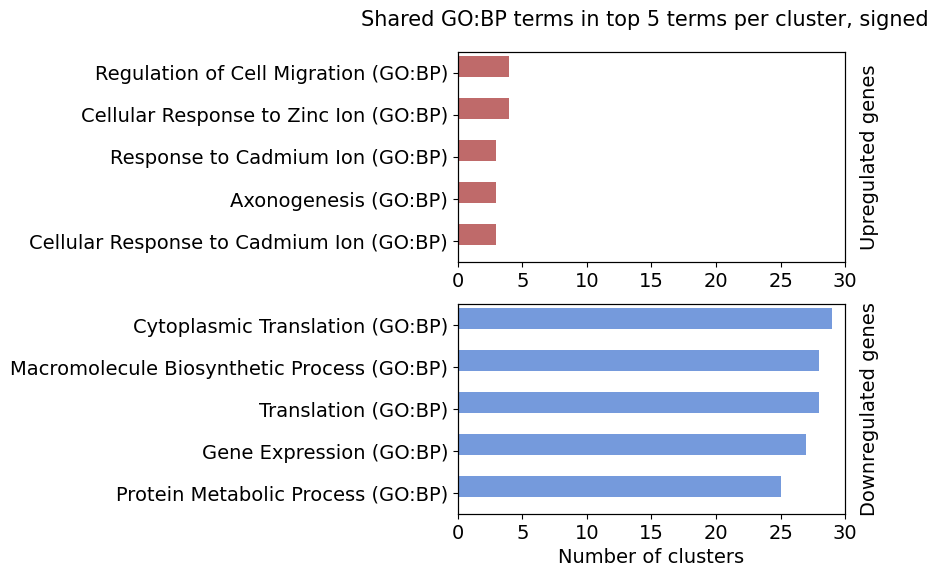

In [ ]:
plot_shared_top_terms_gseapy(signed_top_5_gobp_terms_per_cluster8, 
                                "Shared GO:BP terms in top 5 terms per cluster, signed",
                                go=True, n_pathways=5)

In [144]:
signed_top_5_gobp_terms_per_cluster8

Cluster UP/DOWN Gene_set                                           Term  \
0         0      UP    GO:BP                                  Axonogenesis    
1         0      UP    GO:BP     Dense Core Granule Cytoskeletal Transport    
2         0      UP    GO:BP                   Retrograde Axonal Transport    
3         0      UP    GO:BP  Modulation of Chemical Synaptic Transmission    
4         0      UP    GO:BP           Vesicle Transport Along Microtubule    
..      ...     ...      ...                                            ...   
0        28    DOWN    GO:BP                       Cytoplasmic Translation    
1        28    DOWN    GO:BP            Macromolecule Biosynthetic Process    
2        28    DOWN    GO:BP                                   Translation    
3        28    DOWN    GO:BP                               Gene Expression    
4        28    DOWN    GO:BP                     Protein Metabolic Process    

         P-value  Adjusted P-value  Combined Score  \
0   5.289121e-06      1.286651e-03      514.495535   
1   6.862141e-06      1.286651e-03     8926.629886   
2   3.908789e-05      4.070491e-03     2720.916515   
3   4.341857e-05      4.070491e-03      520.748329   
4   8.964797e-05      6.723598e-03     1589.545908   
..           ...               ...             ...   
0   8.891815e-39      2.062901e-36    48020.235017   
1   5.844640e-36      6.779783e-34    24342.890481   
2   3.452206e-34      2.669706e-32    18408.607626   
3   5.679513e-30      3.294117e-28     9410.734474   
4   4.333291e-24      2.010647e-22     4007.717468   

                                         name and source  
0                                   Axonogenesis (GO:BP)  
1      Dense Core Granule Cytoskeletal Transport (GO:BP)  
2                    Retrograde Axonal Transport (GO:BP)  
3   Modulation of Chemical Synaptic Transmission (GO:BP)  
4            Vesicle Transport Along Microtubule (GO:BP)  
..                                                   ...  
0                        Cytoplasmic Translation (GO:BP)  
1             Macromolecule Biosynthetic Process (GO:BP)  
2                                    Translation (GO:BP)  
3                                Gene Expression (GO:BP)  
4                      Protein Metabolic Process (GO:BP)  

[225 rows x 8 columns]

In [145]:
signed_top_5_gobp_terms_per_cluster8.to_excel(
    "/home/ranwyl/results_tf_project/ora_gobp_top5_8nbrs_lfc0pt25.xlsx", index=False)

### MSigDB Hallmark

In [131]:
signed_results_hallmark8 = ora_gseapy_full(signed_targets8_lfc0pt25, ["MSigDB_Hallmark_2020"])

Processing cluster number: 100%|██████████| 29/29 [01:52<00:00,  3.89s/it]


In [132]:
signed_results_hallmark8.head()

Cluster UP/DOWN              Gene_set                     Term   P-value  \
0        0      UP  MSigDB_Hallmark_2020          Mitotic Spindle  0.000209   
1        0      UP  MSigDB_Hallmark_2020     IL-2/STAT5 Signaling  0.005956   
2        0      UP  MSigDB_Hallmark_2020  Estrogen Response Early  0.005956   
3        0      UP  MSigDB_Hallmark_2020               Myogenesis  0.006015   
4        0      UP  MSigDB_Hallmark_2020             Angiogenesis  0.020877   

   Adjusted P-value  Old P-value  Old adjusted P-value  Odds Ratio  \
0          0.003140            0                     0   30.087809   
1          0.022556            0                     0   19.055612   
2          0.022556            0                     0   19.055612   
3          0.022556            0                     0   18.958376   
4          0.062632            0                     0   51.034014   

   Combined Score             Genes  
0      254.892555  TRIO;KIF5B;KIF1B  
1       97.627104       HUWE1;IGF1R  
2       97.627104        NAV2;IGF1R  
3       96.944130          APP;NAV2  
4      197.455647               APP

In [133]:
signed_results_hallmark8 = signed_results_hallmark8.rename(columns={"cluster":"Cluster",
                                                                  "up/down":"UP/DOWN"})

In [134]:
cols = ["Cluster", "UP/DOWN", "Gene_set", "Term", "P-value", "Adjusted P-value", "Combined Score"]
signed_top_hallmark_term_per_cluster8 = filter_gseapy_results(signed_results_hallmark8, n_top_results=1, columns=cols)
signed_top_5_hallmark_terms_per_cluster8 = filter_gseapy_results(signed_results_hallmark8, n_top_results=5, columns=cols)

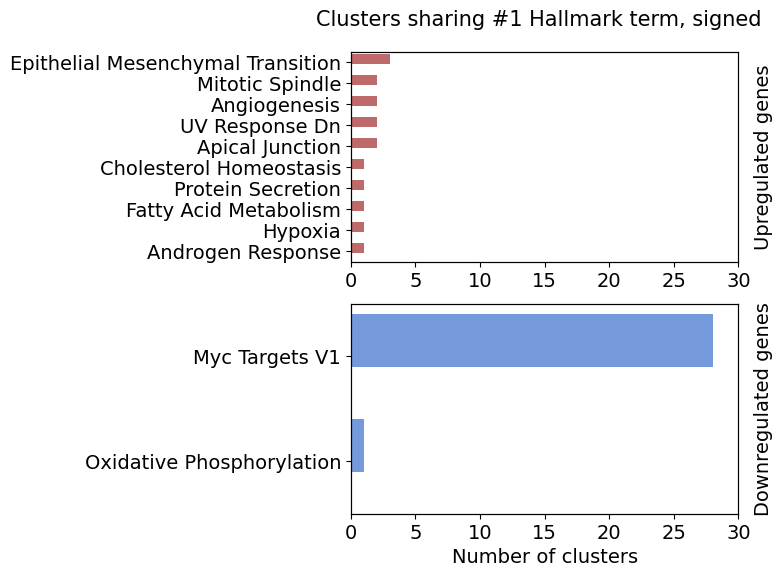

In [ ]:
plot_shared_top_terms_gseapy(signed_top_hallmark_term_per_cluster8, 
                                "Clusters sharing #1 Hallmark term, signed",
                                go=False, n_pathways=29)

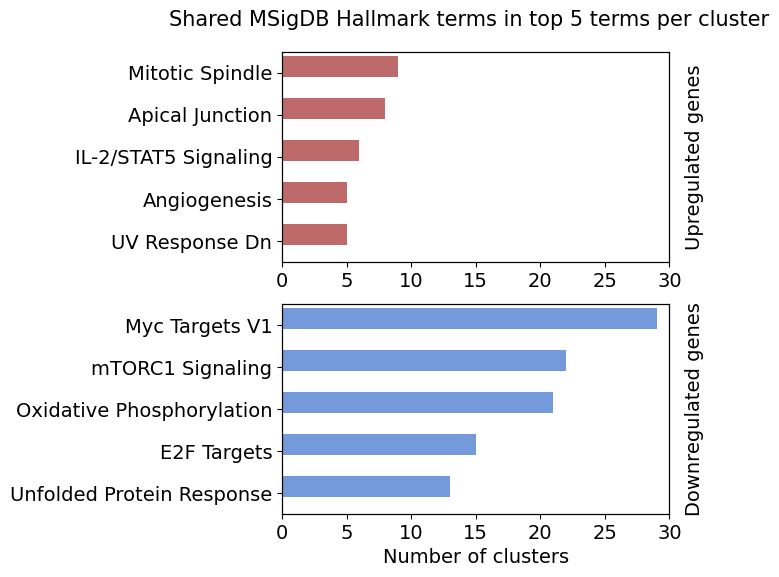

In [ ]:
plot_shared_top_terms_gseapy(signed_top_5_hallmark_terms_per_cluster8, 
                                "Shared MSigDB Hallmark terms in top 5 terms per cluster",
                                go=False, n_pathways=5)

In [137]:
signed_top_hallmark_term_per_cluster8.head(20)

Cluster UP/DOWN              Gene_set                               Term  \
0        0      UP  MSigDB_Hallmark_2020                    Mitotic Spindle   
0        0    DOWN  MSigDB_Hallmark_2020                     Myc Targets V1   
0        1      UP  MSigDB_Hallmark_2020                       Angiogenesis   
0        1    DOWN  MSigDB_Hallmark_2020                     Myc Targets V1   
0        2      UP  MSigDB_Hallmark_2020  Epithelial Mesenchymal Transition   
0        2    DOWN  MSigDB_Hallmark_2020                     Myc Targets V1   
0        3      UP  MSigDB_Hallmark_2020                     UV Response Dn   
0        3    DOWN  MSigDB_Hallmark_2020                     Myc Targets V1   
0        4      UP  MSigDB_Hallmark_2020                    Mitotic Spindle   
0        4    DOWN  MSigDB_Hallmark_2020          Oxidative Phosphorylation   
0        5      UP  MSigDB_Hallmark_2020            Cholesterol Homeostasis   
0        5    DOWN  MSigDB_Hallmark_2020                     Myc Targets V1   
0        6      UP  MSigDB_Hallmark_2020                       Angiogenesis   
0        6    DOWN  MSigDB_Hallmark_2020                     Myc Targets V1   
0        7      UP  MSigDB_Hallmark_2020                  Protein Secretion   
0        7    DOWN  MSigDB_Hallmark_2020                     Myc Targets V1   
0        8      UP  MSigDB_Hallmark_2020                    Apical Junction   
0        8    DOWN  MSigDB_Hallmark_2020                     Myc Targets V1   
0        9    DOWN  MSigDB_Hallmark_2020                     Myc Targets V1   
0       10    DOWN  MSigDB_Hallmark_2020                     Myc Targets V1   

        P-value  Adjusted P-value  Combined Score  
0  2.093250e-04      3.139875e-03      254.892555  
0  2.328317e-38      6.519287e-37     5812.266594  
0  2.663275e-05      6.924515e-04      629.549386  
0  2.425411e-61      9.701645e-60     7769.704133  
0  5.782475e-06      9.830207e-05      268.427416  
0  1.353458e-82      5.143140e-81    13835.621127  
0  1.532331e-03      2.231675e-02       92.011483  
0  2.123045e-69      8.704486e-68     9853.415665  
0  6.250993e-06      8.751390e-05      483.178934  
0  5.945927e-12      9.513483e-11     1108.840220  
0  3.297101e-02      8.676843e-02      109.483105  
0  6.046296e-14      1.330185e-12     1624.816452  
0  9.542698e-03      4.078251e-02      554.131929  
0  4.702326e-50      1.551768e-48     7077.878278  
0  2.775682e-02      5.703494e-02      141.337343  
0  2.919627e-27      5.547291e-26     3161.699860  
0  2.189728e-06      4.160483e-05      360.123413  
0  1.826493e-47      7.123323e-46     4813.599585  
0  1.040051e-31      3.328164e-30     4052.487431  
0  1.530702e-27      3.673685e-26     2860.097000

### Reactome

In [138]:
signed_results_reac8 = ora_gseapy_full(signed_targets8_lfc0pt25, ["Reactome_Pathways_2024"])

Processing cluster number: 100%|██████████| 29/29 [02:04<00:00,  4.30s/it]


In [139]:
signed_results_reac8 = signed_results_reac8.rename(columns={"cluster":"Cluster",
                                                                  "up/down":"UP/DOWN"})

In [140]:
cols = ["Cluster", "UP/DOWN", "Gene_set", "Term", "P-value", "Adjusted P-value", "Combined Score"]
signed_top_reac_term_per_cluster8 = filter_gseapy_results(signed_results_reac8, n_top_results=1, columns=cols)
signed_top_5_reac_terms_per_cluster8 = filter_gseapy_results(signed_results_reac8, n_top_results=5, columns=cols)

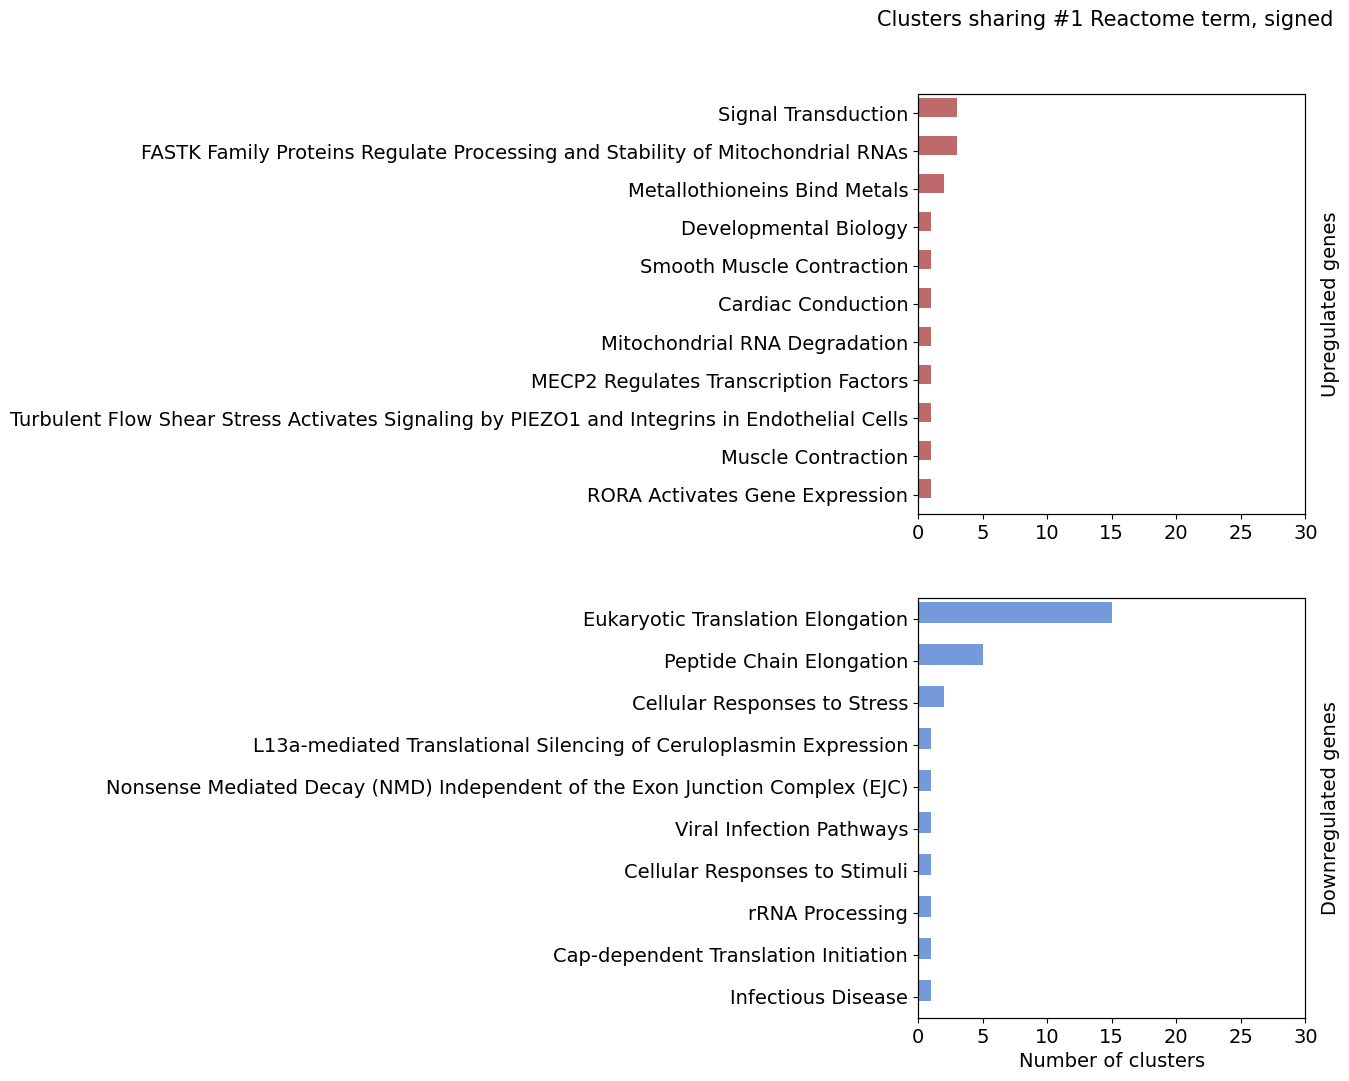

In [ ]:
plot_shared_top_terms_gseapy(signed_top_reac_term_per_cluster8, 
                                "Clusters sharing #1 Reactome term, signed",
                                go=False, n_pathways=29, fig_size=(5, 12))

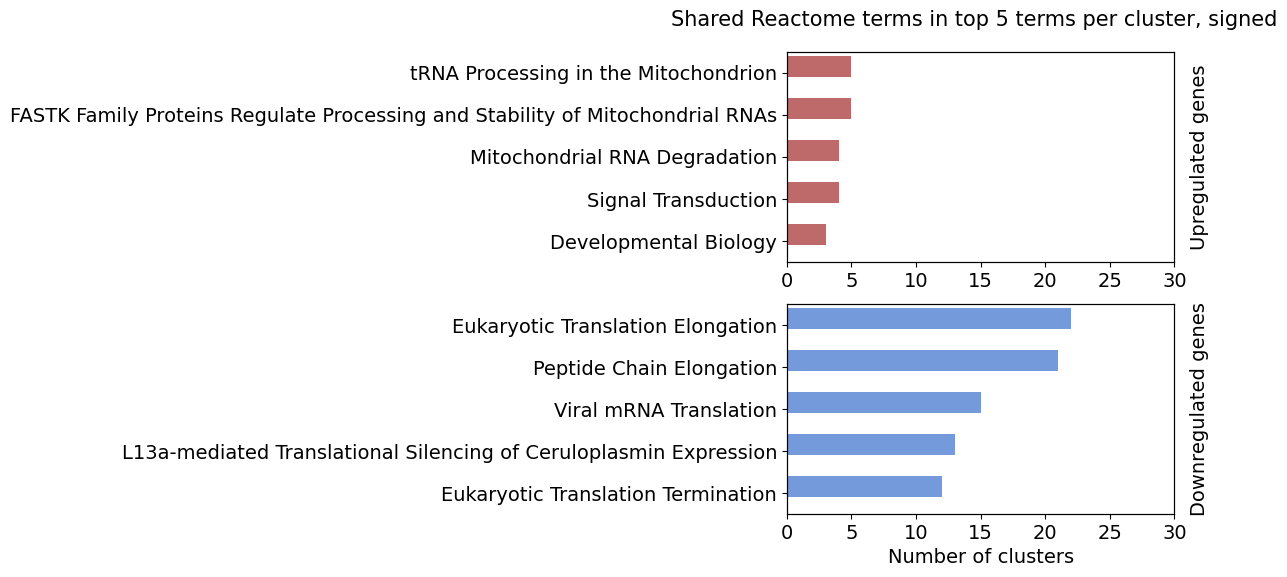

In [ ]:
plot_shared_top_terms_gseapy(signed_top_5_reac_terms_per_cluster8, 
                                "Shared Reactome terms in top 5 terms per cluster, signed",
                                go=False, n_pathways=5)

In [143]:
signed_top_reac_term_per_cluster8.head(20)

Cluster UP/DOWN                Gene_set  \
1        0      UP  Reactome_Pathways_2024   
0        0    DOWN  Reactome_Pathways_2024   
0        1      UP  Reactome_Pathways_2024   
0        1    DOWN  Reactome_Pathways_2024   
0        2      UP  Reactome_Pathways_2024   
0        2    DOWN  Reactome_Pathways_2024   
0        3      UP  Reactome_Pathways_2024   
0        3    DOWN  Reactome_Pathways_2024   
0        4      UP  Reactome_Pathways_2024   
0        4    DOWN  Reactome_Pathways_2024   
0        5      UP  Reactome_Pathways_2024   
0        5    DOWN  Reactome_Pathways_2024   
0        6      UP  Reactome_Pathways_2024   
0        6    DOWN  Reactome_Pathways_2024   
0        7      UP  Reactome_Pathways_2024   
0        7    DOWN  Reactome_Pathways_2024   
0        8      UP  Reactome_Pathways_2024   
0        8    DOWN  Reactome_Pathways_2024   
0        9    DOWN  Reactome_Pathways_2024   
0       10    DOWN  Reactome_Pathways_2024   

                                                                                           Term  \
1                                                                           Signal Transduction   
0                                                                      Peptide Chain Elongation   
0                                                                           Signal Transduction   
0                                                             Eukaryotic Translation Elongation   
0                                                                     Smooth Muscle Contraction   
0                                                             Eukaryotic Translation Elongation   
0                                                                         Developmental Biology   
0                                                             Eukaryotic Translation Elongation   
0                                                                 Mitochondrial RNA Degradation   
0                             L13a-mediated Translational Silencing of Ceruloplasmin Expression   
0                                                                            Cardiac Conduction   
0                                                                      Viral Infection Pathways   
0                                                         MECP2 Regulates Transcription Factors   
0                                                             Eukaryotic Translation Elongation   
0                 FASTK Family Proteins Regulate Processing and Stability of Mitochondrial RNAs   
0                                                             Eukaryotic Translation Elongation   
0  Turbulent Flow Shear Stress Activates Signaling by PIEZO1 and Integrins in Endothelial Cells   
0                                                             Eukaryotic Translation Elongation   
0                                                             Eukaryotic Translation Elongation   
0                  Nonsense Mediated Decay (NMD) Independent of the Exon Junction Complex (EJC)   

         P-value  Adjusted P-value  Combined Score  
1   6.572817e-06      7.788788e-04      113.993453  
0   4.945564e-86      3.991070e-83    88437.078643  
0   1.584121e-10      7.572098e-08      168.340683  
0  4.097232e-162     4.261121e-159   423400.872100  
0   2.293635e-07      7.179078e-05     1407.919488  
0  1.309275e-161     1.357718e-158   409567.936313  
0   1.551162e-08      2.406608e-06      152.173356  
0  7.018562e-119     7.467750e-116   107686.750058  
0   3.521184e-07      7.394486e-05     4181.852348  
0   5.746503e-29      2.108966e-26    11928.196208  
0   1.561975e-03      6.346241e-02      251.889213  
0   3.705348e-17      1.504371e-14     1023.242306  
0   1.330290e-03      3.881359e-02     6908.039583  
0  1.555431e-108     1.434108e-105   111085.456448  
0   1.057456e-05      6.601445e-04     6371.992133  
0  2.711287e-104     1.884345e-101   170452.123602  
0   4.923100e-06      1.224621e-03     1327.114086  
0 

# Pre-ranked GSEA

In [2]:
de_results = pd.read_pickle("/home/ranwyl/results_tf_project/TF_KO_NTC_DE_results_gene_symbols.pkl")

In [3]:
de_results.head(3)

DMRT2_baseMean  DMRT2_log2FoldChange  DMRT2_lfcSE  DMRT2_stat  \
A1BG             5.285500              0.609960     0.619478    1.250948   
A2ML1            2.606644              0.100952     0.769812    0.197628   
A2ML1-AS1        8.352237              0.077233     0.476058    0.189240   

           DMRT2_pvalue  DMRT2_padj  OSR2_baseMean  OSR2_log2FoldChange  \
A1BG           0.210953         NaN       3.123957            -0.372431   
A2ML1          0.843336         NaN       1.550960            -0.509398   
A2ML1-AS1      0.849904         NaN       4.474111            -0.086464   

           OSR2_lfcSE  OSR2_stat  ...  ZBED6_lfcSE  ZBED6_stat  ZBED6_pvalue  \
A1BG         0.747259  -0.721735  ...     0.991264   -0.500306      0.616860   
A2ML1        0.982173  -0.941713  ...     1.138998   -0.221171      0.824959   
A2ML1-AS1    0.641921  -0.181294  ...     0.902441   -1.561968      0.118296   

           ZBED6_padj  FAM200B_baseMean  FAM200B_log2FoldChange  \
A1BG              NaN          2.614595               -0.388893   
A2ML1             NaN          2.470636               -0.309124   
A2ML1-AS1         NaN         11.032901                0.407476   

           FAM200B_lfcSE  FAM200B_stat  FAM200B_pvalue  FAM200B_padj  
A1BG            0.816637     -0.736728        0.461288      0.937480  
A2ML1           0.809974     -0.593803        0.552644      0.950115  
A2ML1-AS1       0.450120      1.039717        0.298471      0.916599  

[3 rows x 3912 columns]

In [4]:
clusters_8nbrs = pd.read_csv("/home/ranwyl/results_tf_project/tf_ko_clusters_4265degs_padj_8nbrs.csv", header=0, index_col=0)
clusters_8nbrs.head()

0        1       2        3        4       5       6       7  \
0      ARX     CBX2     AHR    ATF6B    ASCL1   ATMIN    CDX1   BACH2   
1    ATOH1   CCDC17  ANKZF1   BHLHA9    ETV3L   CENPS    JRKL  CC2D1A   
2  BHLHE41  CREB3L3    ARNT  BHLHA15  FLYWCH1  CHAMP1   PITX2   CEBPB   
3     CREM    DMRT3   ARNT2      ERF    GTF3A  DMRTB1  POU4F3   CEBPD   
4   DMRTC2     ESR1  CAMTA2     FOSB     HMX2   DNMT1  RHOXF2    DLX2   

         8        9  ...     18     19       20       21        22       23  \
0   ARID3A    CEBPA  ...  ESRRG    BSX    ATOH7    CTCFL     AKAP8  FOXD4L5   
1    BARX1  CREB3L4  ...  FOXJ2  DOT1L    DMBX1    DACH2  ARHGAP35     MITF   
2  BHLHE40     ETV1  ...    HDX   HES7  FAM200B    FOXE3     CXXC1    NFXL1   
3    CREB5    FOXS1  ...   IRF9   JUNB    FOXN4  GATAD2A      KLF4     RORC   
4    ESRRA    GATA3  ...  KLF15   MAFK  NEUROD2    GRHL2     KLF10    TBX18   

       24      25     26        27  
0  CREBL2     CRX  ASCL2      EBF2  
1  DMRTA2   GLIS3  CENPX     GMEB2  
2   SMAD4   GTF2I   DLX4  GTF2IRD1  
3   STAT6  TCF7L1  DMRT2     NFKB1  
4  ZNF75D   TIGD2   HSF2    SNAPC4  

[5 rows x 28 columns]

In [45]:
all_libs = gp.get_library_name(organism='Human')
print([lib for lib in all_libs if "GO" in lib])
print([lib for lib in all_libs if "Hallmark" in lib])
print([lib for lib in all_libs if "Reactome" in lib])

['GO_Biological_Process_2021', 'GO_Biological_Process_2023', 'GO_Biological_Process_2025', 'GO_Cellular_Component_2021', 'GO_Cellular_Component_2023', 'GO_Cellular_Component_2025', 'GO_Molecular_Function_2021', 'GO_Molecular_Function_2023', 'GO_Molecular_Function_2025', 'SynGO_2022', 'SynGO_2024']
['MSigDB_Hallmark_2020']
['Reactome_2022', 'Reactome_Pathways_2024']


In [5]:
def rank_clusters(cluster_df, de_df):
    """
    Rank genes of each cluster based on DGE results. For all genes, take mean of
    Wald test statistic ("stat") for that gene for each TF KO in the cluster.
    Return dict of {cluster: DF of ranked genes}.
    """
    all_rank_dfs_dict = dict()
    # Loop through clusters
    for i, cluster in enumerate(cluster_df.columns):
        cluster_de_df_dict = dict()
        cluster_tf_ko_list = cluster_df[cluster][cluster_df[cluster].notna()].tolist()
        for tf_ko in cluster_tf_ko_list:
            # Create DF of DGE results for all TF KOs in cluster
            stat_col = f"{tf_ko}_stat"
            gene_stat_list = de_df[stat_col].tolist()
            cluster_de_df_dict[tf_ko] = gene_stat_list
        # Build DF and calculate mean Wald test statistic
        genes = de_df.index.tolist()
        cluster_de_df = pd.DataFrame(cluster_de_df_dict, index=genes)
        cluster_mean_stat = cluster_de_df.mean(axis=1)
        cluster_mean_stat_df = pd.DataFrame(cluster_mean_stat, 
                                            columns=["Mean Wald test statistic"])
        cluster_mean_stat_df.index.name = "Gene"
        cluster_mean_stat_df.sort_values(by="Mean Wald test statistic", 
                                        ascending=False, inplace=True)
        # Add to dict
        all_rank_dfs_dict[int(i)] = cluster_mean_stat_df
    return all_rank_dfs_dict

def prerank_gsea_cluster(cluster_rank_df, gene_set_lib: str, 
                         min_size=5, max_size=1000, permutation_num=1000,
                         verbose=False):
    """
    Run pre-ranked GSEA on one cluster using the given ranking DataFrame 
    and Enrichr library. min_size and max_size control term size. Return
    gseapy Prerank object.
    """
    prerank_result = gp.prerank(rnk=cluster_rank_df,
                     gene_sets=gene_set_lib,
                     threads=4,
                     min_size=min_size,
                     max_size=max_size,
                     permutation_num=permutation_num, # reduce number to speed up testing
                     outdir=None, # don't write to disk
                     seed=6,
                     verbose=verbose,
                    )
    return prerank_result

def prerank_gsea(cluster_df, de_df, gene_set_lib: str, 
                 min_size=5, max_size=1000, permutation_num=1000):
    """
    Run pre-ranked GSEA on all clusters. Return dict {cluster: Prerank object}
    Dependencies: rank_clusters(), prerank_gsea_cluster()
    """
    all_rank_dfs_dict = rank_clusters(cluster_df, de_df)
    prerank_results_dict = dict()
    clusters = list(all_rank_dfs_dict.keys())
    
    for i in tqdm(range(len(clusters)), desc="Processing cluster number"):
        prerank_res = prerank_gsea_cluster(
            all_rank_dfs_dict[clusters[i]], gene_set_lib,
            min_size=min_size, max_size=max_size,
            permutation_num=permutation_num)
        prerank_results_dict[clusters[i]] = prerank_res
    return prerank_results_dict

def build_prerank_gsea_results_df(prerank_results_dict):
    """
    Given a dict of Prerank objects, build combined DF 
    of full preranked GSEA results for all clusters.
    """
    prerank_res_df_list = list()
    for cluster in prerank_results_dict:
        res_df = prerank_results_dict[cluster].res2d
        res_df = res_df.copy()
        res_df.insert(0, "Cluster", [cluster]*res_df.shape[0])
        res_df.drop(columns=["Name"], inplace=True)
        prerank_res_df_list.append(res_df)
    full_prerank_res_df = pd.concat(prerank_res_df_list)
    return full_prerank_res_df

def top_gsea_terms_from_prerank_dict(prerank_results_dict, n_top_terms):
    """
    Given a dict of Prerank objects, build combined DF of top terms per cluster.
    """
    prerank_res_df_list = list()
    for cluster in prerank_results_dict:
        res_df = prerank_results_dict[cluster].res2d
        res_df = res_df.head(n_top_terms).copy()
        res_df.insert(0, "Cluster", [cluster]*res_df.shape[0])
        res_df.drop(columns=["Name"], inplace=True)
        prerank_res_df_list.append(res_df)
    top_prerank_res_df = pd.concat(prerank_res_df_list)
    return top_prerank_res_df

def top_gsea_terms_from_prerank_df(prerank_res_df, n_top_terms):
    """
    Given a DF of prerank results, build combined DF of top terms per cluster. 
    """
    prerank_res_df_list = list()
    clusters = prerank_res_df["Cluster"].unique().tolist()
    for cluster in clusters:
        res_df = prerank_res_df[prerank_res_df["Cluster"] == cluster]
        res_df = res_df.head(n_top_terms).copy()
        prerank_res_df_list.append(res_df)
    top_prerank_res_df = pd.concat(prerank_res_df_list)
    return top_prerank_res_df

In [7]:
def plot_shared_top_terms_prerank_gsea(prerank_res_df, title, xmax=None, min_clusters=1, fig_size=(4,9)):
    """
    Given a DF of prerank results, plot top terms from GSEA 
    shared by multiple clusters.
    """
    if xmax == None:
        xmax = prerank_res_df["Cluster"].nunique() + 1
    up_df = prerank_res_df[prerank_res_df['ES'] > 0]
    down_df = prerank_res_df[prerank_res_df['ES'] < 0]
    up_count_df = pd.DataFrame(up_df['Term'].value_counts())
    up_count_df = up_count_df[up_count_df['count'] >= min_clusters]
    down_count_df = pd.DataFrame(down_df['Term'].value_counts())
    down_count_df = down_count_df[down_count_df['count'] >= min_clusters]
    up_term_list = up_count_df.index.tolist()
    down_term_list = down_count_df.index.tolist()
    term_list = up_term_list + down_term_list
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=fig_size)
    sns.barplot(data=up_count_df, x="count", y="Term", orient="h", ax=ax1, color="indianred", height=0.5)
    sns.barplot(data=down_count_df, x="count", y="Term", orient="h", ax=ax2, color="cornflowerblue", height=0.5)
    plt.rcParams.update({"font.size":14})
    for ax in (ax1, ax2):
        ax.set_xlim(0, xmax)
        ax.set_ylabel("")
        ax.set_xlabel("Number of clusters", fontsize=14)
    ax1a = ax1.twinx()
    ax1a.set_ylabel("Upregulated genes", fontsize=14)
    ax2a = ax2.twinx()
    ax2a.set_ylabel("Downregulated genes", fontsize=14)
    for ax in ax1a, ax2a:
        ax.tick_params(axis='y', which='both', right=False)
        ax.set_yticklabels([])
    fig.suptitle(title, fontsize=15, y=0.92)
    return term_list, up_df, down_df


In [6]:
def plot_term_prerank_gsea(prerank_results_dict, cluster_num, term_num, 
                           output_filename=None):
    """
    Built-in gseapy plot for single term in single cluster. 
    Takes dict of Prerank objects.
    """
    cl_results = prerank_results_dict[cluster_num]
    terms = cl_results.res2d.Term
    _ = cl_results.plot(terms=terms[term_num], ofname=output_filename)

def plot_terms_prerank_gsea(prerank_results_dict, cluster_num, n_terms, 
                            title, fig_size=(2,3)):
    """
    Built-in gseapy line plot for n_terms terms in single cluster.
    Takes dict of Prerank objects.
    """
    cl_results = prerank_results_dict[cluster_num]
    terms = cl_results.res2d.Term
    fig = cl_results.plot(terms=terms[:n_terms], show_ranking=True, figsize=fig_size)
    fig.suptitle(title, fontsize=14, y=1.15)
    fig.subplots_adjust(top=0.85, bottom=0.25)
    plt.show()
    
def dotplot_terms_prerank_gsea(prerank_results_dict, cluster_num, title, 
                            dot_size=5, fig_size=(3,4), cutoff=0.25, show_ring=False,
                            output_filename=None):
    """
    Built-in GSEA dotplot for single cluster.
    Takes dict of Prerank objects.
    """
    cl_results = prerank_results_dict[cluster_num]
    ax = gp.dotplot(cl_results.res2d, column="FDR q-val",
                    title=title, cmap=plt.cm.viridis, size=dot_size,
                    figsize=fig_size, cutoff=cutoff, show_ring=show_ring,
                    ofname=output_filename)

### Test code on individual clusters

In [9]:
cl0_rank_df = rank_dict_8nbrs[0]
cl0_rank_df

NameError: name 'rank_dict_8nbrs' is not defined

In [ ]:
cl0_results = prerank_gsea_cluster(cl0_rank_df, "GO_Biological_Process_2025", verbose=True)

2025-06-09 01:55:44,004 [INFO] Parsing data files for GSEA.............................
2025-06-09 01:55:44,753 [INFO] Downloading and generating Enrichr library gene sets......
2025-06-09 01:55:52,200 [INFO] 1097 gene_sets have been filtered out when max_size=1000 and min_size=5
2025-06-09 01:55:52,200 [INFO] 4246 gene_sets used for further statistical testing.....
2025-06-09 01:55:52,201 [INFO] Start to run GSEA...Might take a while..................
2025-06-09 01:57:08,399 [INFO] Congratulations. GSEApy runs successfully................



In [40]:
cl0_max500_results = prerank_gsea_cluster(
    cl0_rank_df, "GO_Biological_Process_2025", verbose=True, max_size=500)

2025-06-09 02:12:09,389 [INFO] Parsing data files for GSEA.............................
2025-06-09 02:12:09,407 [INFO] Enrichr library gene sets already downloaded in: /home/ranwyl/.cache/gseapy, use local file
2025-06-09 02:12:09,470 [INFO] 1101 gene_sets have been filtered out when max_size=500 and min_size=5
2025-06-09 02:12:09,470 [INFO] 4242 gene_sets used for further statistical testing.....
2025-06-09 02:12:09,471 [INFO] Start to run GSEA...Might take a while..................
2025-06-09 02:13:25,327 [INFO] Congratulations. GSEApy runs successfully................



In [25]:
cl1_rank_df = rank_dict_8nbrs[1]
cl1_results = prerank_gsea_cluster(cl1_rank_df, "GO_Biological_Process_2025", verbose=True)

2025-06-09 02:00:55,744 [INFO] Parsing data files for GSEA.............................
2025-06-09 02:00:55,762 [INFO] Enrichr library gene sets already downloaded in: /home/ranwyl/.cache/gseapy, use local file
2025-06-09 02:00:55,826 [INFO] 1097 gene_sets have been filtered out when max_size=1000 and min_size=5
2025-06-09 02:00:55,826 [INFO] 4246 gene_sets used for further statistical testing.....
2025-06-09 02:00:55,827 [INFO] Start to run GSEA...Might take a while..................
2025-06-09 02:02:12,498 [INFO] Congratulations. GSEApy runs successfully................



In [49]:
cl2_rank_df = rank_dict_8nbrs[2]
cl2_results = prerank_gsea_cluster(cl2_rank_df, "GO_Biological_Process_2025", verbose=True)

2025-06-09 02:20:51,774 [INFO] Parsing data files for GSEA.............................
2025-06-09 02:20:51,791 [INFO] Enrichr library gene sets already downloaded in: /home/ranwyl/.cache/gseapy, use local file
2025-06-09 02:20:51,858 [INFO] 1097 gene_sets have been filtered out when max_size=1000 and min_size=5
2025-06-09 02:20:51,859 [INFO] 4246 gene_sets used for further statistical testing.....
2025-06-09 02:20:51,859 [INFO] Start to run GSEA...Might take a while..................
2025-06-09 02:22:10,065 [INFO] Congratulations. GSEApy runs successfully................



GOBP, cluster 0, term size < 1000

In [42]:
cl0_results.res2d.head()

Name                                               Term        ES  \
0  prerank               Cytoplasmic Translation (GO:0002181) -0.934657   
1  prerank    Macromolecule Biosynthetic Process (GO:0009059) -0.847461   
2  prerank                           Translation (GO:0006412) -0.817965   
3  prerank                       Gene Expression (GO:0010467) -0.741987   
4  prerank  Cell-Cell Adhesion via Plasma-Membrane Adhesio...  0.675654   

        NES NOM p-val FDR q-val FWER p-val    Tag % Gene %  \
0 -3.343449       0.0       0.0        0.0   83/100  3.74%   
1 -3.205747       0.0       0.0        0.0   97/174  5.23%   
2 -3.165004       0.0       0.0        0.0  124/224  8.35%   
3 -2.971048       0.0       0.0        0.0  138/332  8.96%   
4  2.875446       0.0       0.0        0.0    33/87  9.73%   

                                          Lead_genes  
0  RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL32;RPS1...  
1  EEF1A1;RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL...  
2  EEF1A1;RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL...  
3  EEF1A1;RPL39;RPLP1;RPL23;PTMA;RPS28;RPS12;RPS2...  
4  ROBO2;GRID2;NLGN1;NRXN1;CADM2;HMCN1;CDH6;LRRC4...

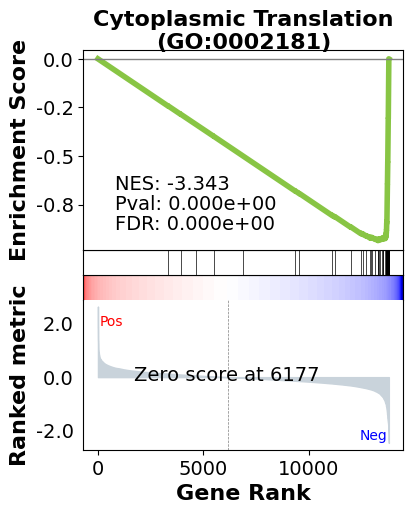

In [44]:
terms = cl0_results.res2d.Term
axs = cl0_results.plot(terms=terms[0])

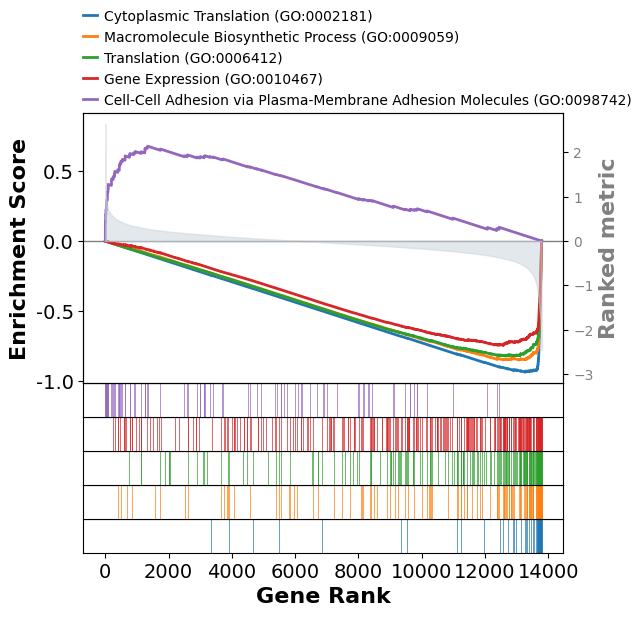

In [ ]:
axs = cl0_results.plot(terms=terms[0:5],
                   #legend_kws={'loc': (1.2, 0)}, # set the legend loc
                   show_ranking=True, # whether to show the second yaxis
                   figsize=(3,4)
                  )

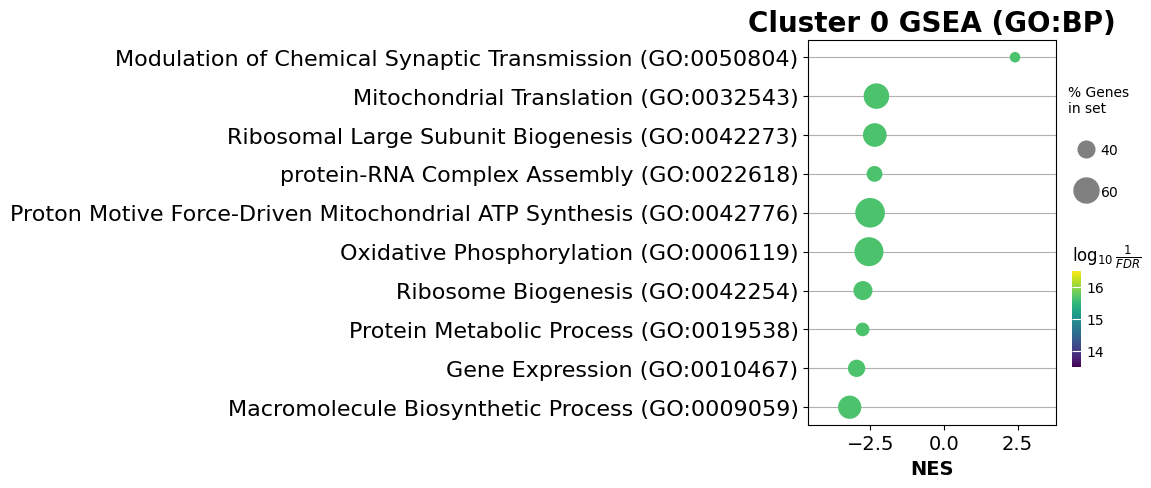

In [48]:
ax = gp.dotplot(cl0_results.res2d,
             column="FDR q-val",
             title='Cluster 0 GSEA (GO:BP)',
             cmap=plt.cm.viridis,
             size=5, # adjust dot size
             figsize=(4,5), cutoff=0.25, show_ring=False)

GOBP, cluster 0, term size < 500

In [43]:
cl0_max500_results.res2d.head()

Name                                               Term        ES  \
0  prerank               Cytoplasmic Translation (GO:0002181) -0.934657   
1  prerank    Macromolecule Biosynthetic Process (GO:0009059) -0.847461   
2  prerank                           Translation (GO:0006412) -0.817965   
3  prerank                       Gene Expression (GO:0010467) -0.741987   
4  prerank  Cell-Cell Adhesion via Plasma-Membrane Adhesio...  0.675654   

        NES NOM p-val FDR q-val FWER p-val    Tag % Gene %  \
0 -3.343449       0.0       0.0        0.0   83/100  3.74%   
1 -3.205747       0.0       0.0        0.0   97/174  5.23%   
2 -3.165004       0.0       0.0        0.0  124/224  8.35%   
3 -2.971048       0.0       0.0        0.0  138/332  8.96%   
4  2.875446       0.0       0.0        0.0    33/87  9.73%   

                                          Lead_genes  
0  RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL32;RPS1...  
1  EEF1A1;RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL...  
2  EEF1A1;RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL...  
3  EEF1A1;RPL39;RPLP1;RPL23;PTMA;RPS28;RPS12;RPS2...  
4  ROBO2;GRID2;NLGN1;NRXN1;CADM2;HMCN1;CDH6;LRRC4...

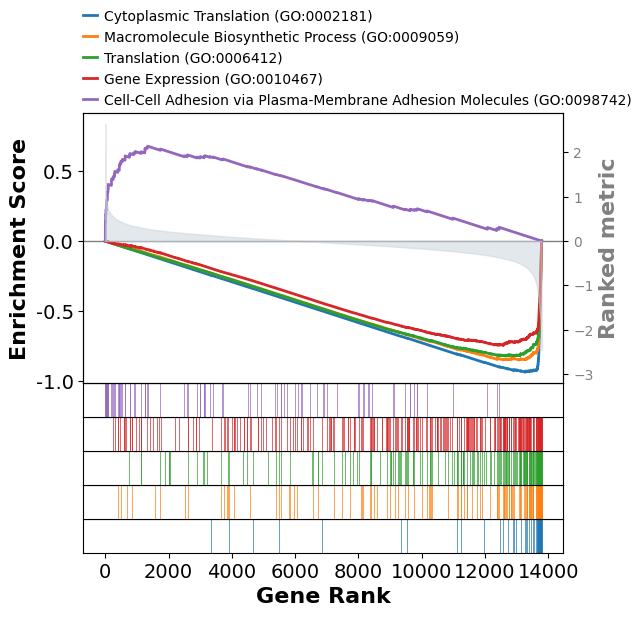

In [45]:
axs = cl0_max500_results.plot(terms=terms[0:5],
                   show_ranking=True,
                   figsize=(3,4)
                  )

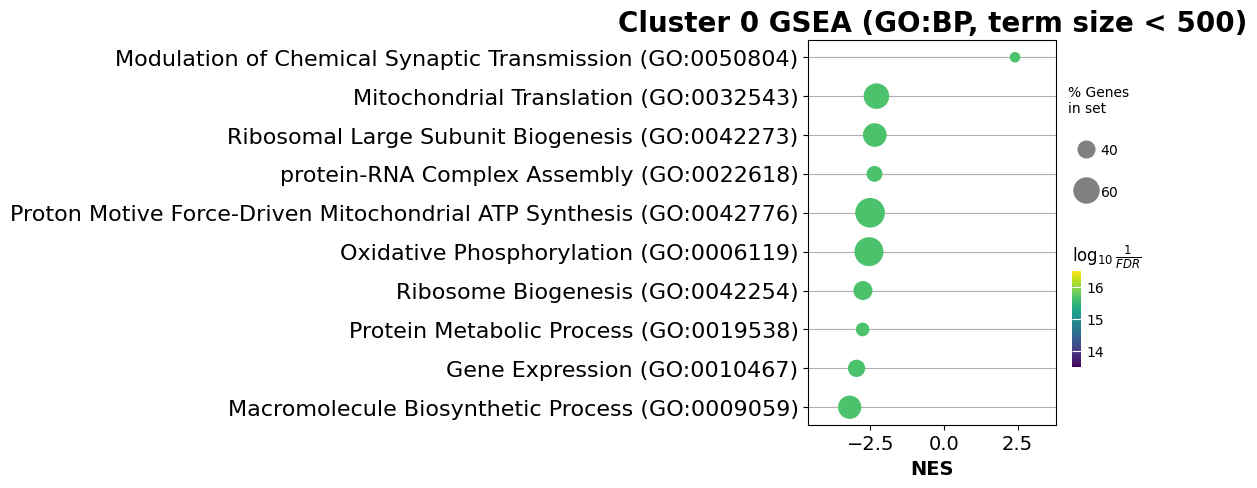

In [47]:
ax = gp.dotplot(cl0_max500_results.res2d,
             column="FDR q-val",
             title='Cluster 0 GSEA (GO:BP, term size < 500)',
             cmap=plt.cm.viridis,
             size=5, # adjust dot size
             figsize=(4,5), cutoff=0.25, show_ring=False)

GOBP, cluster 1, term size < 1000

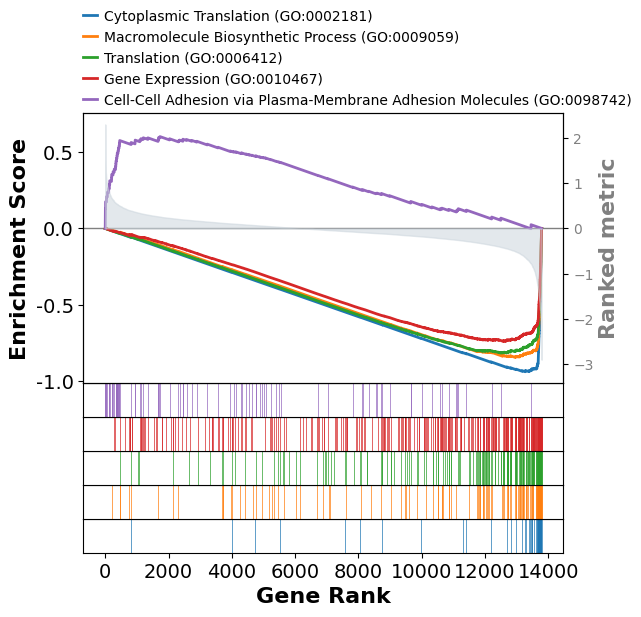

In [32]:
axs = cl1_results.plot(terms=terms[0:5],
                   #legend_kws={'loc': (1.2, 0)}, # set the legend loc
                   show_ranking=True, # whether to show the second yaxis
                   figsize=(3,4)
                  )

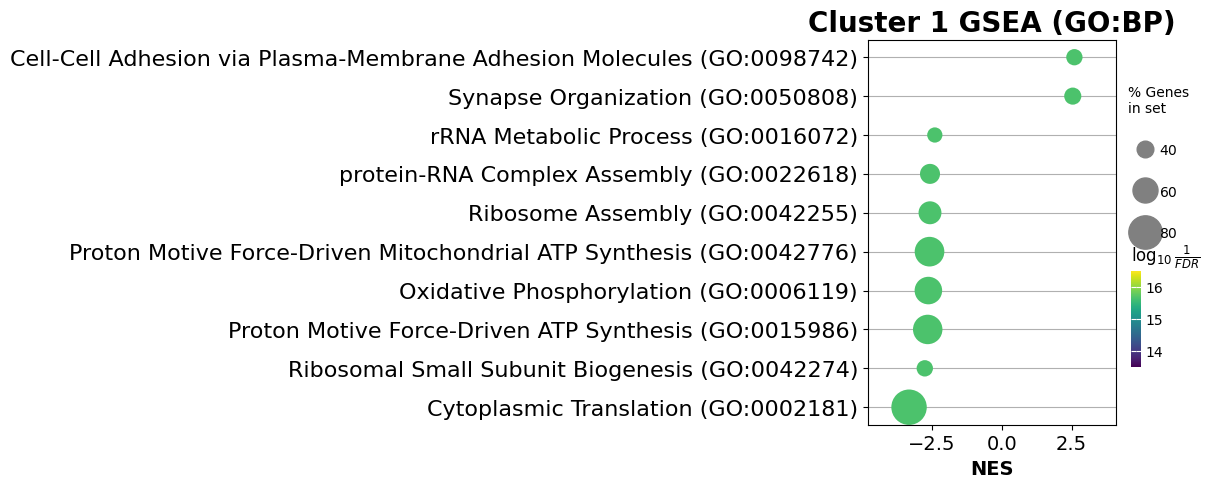

In [46]:
ax = gp.dotplot(cl1_results.res2d,
             column="FDR q-val",
             title='Cluster 1 GSEA (GO:BP)',
             cmap=plt.cm.viridis,
             size=5, # adjust dot size
             figsize=(4,5), cutoff=0.25, show_ring=False)

GOBP, cluster 2, term size < 1000

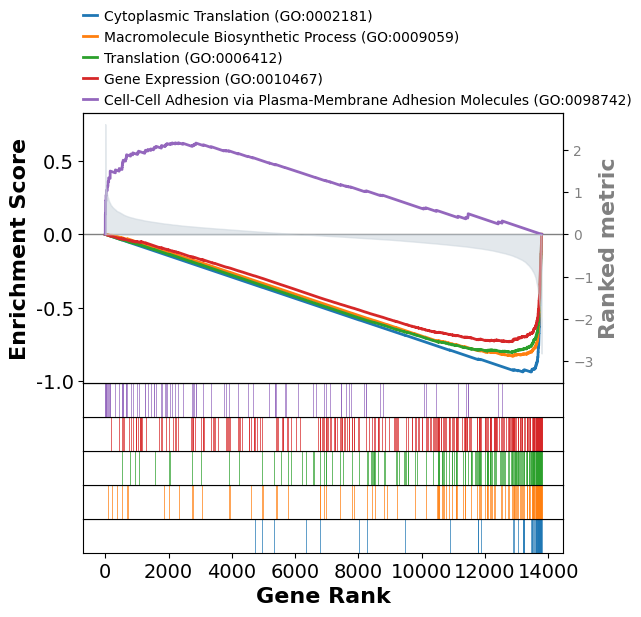

In [50]:
axs = cl2_results.plot(terms=terms[0:5],
                   #legend_kws={'loc': (1.2, 0)}, # set the legend loc
                   show_ranking=True, # whether to show the second yaxis
                   figsize=(3,4)
                  )

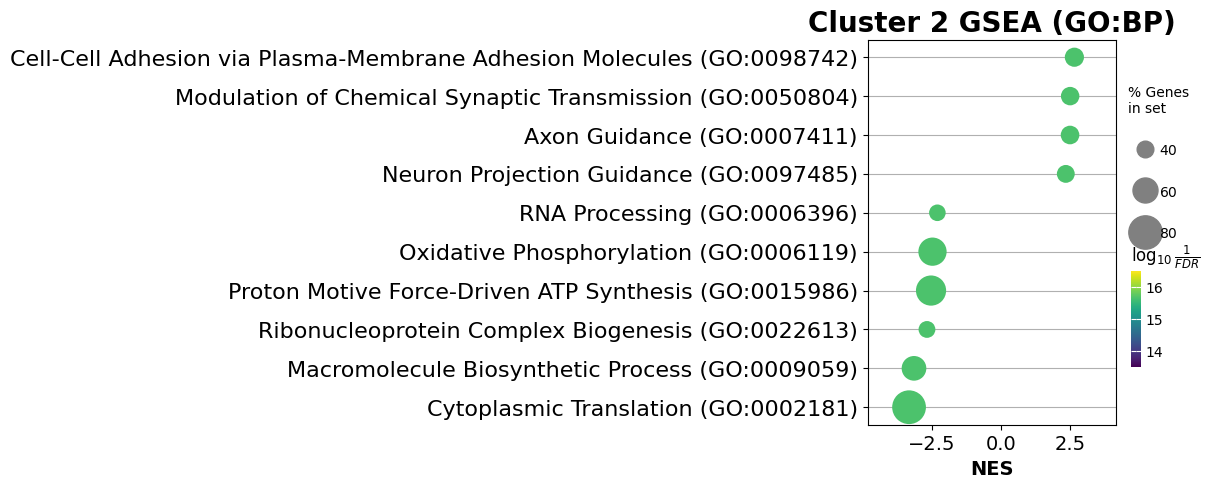

In [51]:
ax = gp.dotplot(cl2_results.res2d,
             column="FDR q-val",
             title='Cluster 2 GSEA (GO:BP)',
             cmap=plt.cm.viridis,
             size=5, # adjust dot size
             figsize=(4,5), cutoff=0.25, show_ring=False)

### GO

In [13]:
prerank_res_gobp8 = prerank_gsea(clusters_8nbrs, de_results, "GO_Biological_Process_2025")

Processing cluster number: 100%|██████████| 29/29 [37:59<00:00, 78.61s/it]


Prerank GSEA took 38 minutes

In [ ]:
prerank_res_df_gobp8 = build_prerank_gsea_results_df(prerank_res_gobp8)

In [155]:
prerank_res_df_gobp8.head(3)

Cluster                                             Term        ES  \
0        0             Cytoplasmic Translation (GO:0002181) -0.934657   
1        0  Macromolecule Biosynthetic Process (GO:0009059) -0.847461   
2        0                         Translation (GO:0006412) -0.817965   

        NES NOM p-val FDR q-val FWER p-val    Tag % Gene %  \
0 -3.343449       0.0       0.0        0.0   83/100  3.74%   
1 -3.205747       0.0       0.0        0.0   97/174  5.23%   
2 -3.165004       0.0       0.0        0.0  124/224  8.35%   

                                          Lead_genes  
0  RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL32;RPS1...  
1  EEF1A1;RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL...  
2  EEF1A1;RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL...

In [197]:
prerank_res_df_gobp_fdr8 = prerank_res_df_gobp8[(prerank_res_df_gobp8["FDR q-val"] < 0.05)].copy()
prerank_res_df_gobp_fdr8.head()

Cluster                                               Term        ES  \
0        0               Cytoplasmic Translation (GO:0002181) -0.934657   
1        0    Macromolecule Biosynthetic Process (GO:0009059) -0.847461   
2        0                           Translation (GO:0006412) -0.817965   
3        0                       Gene Expression (GO:0010467) -0.741987   
4        0  Cell-Cell Adhesion via Plasma-Membrane Adhesio...  0.675654   

        NES NOM p-val FDR q-val FWER p-val    Tag % Gene %  \
0 -3.343449       0.0       0.0        0.0   83/100  3.74%   
1 -3.205747       0.0       0.0        0.0   97/174  5.23%   
2 -3.165004       0.0       0.0        0.0  124/224  8.35%   
3 -2.971048       0.0       0.0        0.0  138/332  8.96%   
4  2.875446       0.0       0.0        0.0    33/87  9.73%   

                                          Lead_genes  
0  RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL32;RPS1...  
1  EEF1A1;RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL...  
2  EEF1A1;RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL...  
3  EEF1A1;RPL39;RPLP1;RPL23;PTMA;RPS28;RPS12;RPS2...  
4  ROBO2;GRID2;NLGN1;NRXN1;CADM2;HMCN1;CDH6;LRRC4...

In [150]:
prerank_res_df_gobp8.shape

(123134, 10)

In [156]:
# Save
prerank_res_df_gobp8.to_pickle("/home/ranwyl/results_tf_project/gsea_gobp_8nbrs.pkl")

In [8]:
prerank_res_df_gobp8 = pd.read_pickle("/home/ranwyl/results_tf_project/gsea_gobp_8nbrs.pkl")
prerank_res_df_gobp8.head()

Cluster                                               Term        ES  \
0        0               Cytoplasmic Translation (GO:0002181) -0.934657   
1        0    Macromolecule Biosynthetic Process (GO:0009059) -0.847461   
2        0                           Translation (GO:0006412) -0.817965   
3        0                       Gene Expression (GO:0010467) -0.741987   
4        0  Cell-Cell Adhesion via Plasma-Membrane Adhesio...  0.675654   

        NES NOM p-val FDR q-val FWER p-val    Tag % Gene %  \
0 -3.343449       0.0       0.0        0.0   83/100  3.74%   
1 -3.205747       0.0       0.0        0.0   97/174  5.23%   
2 -3.165004       0.0       0.0        0.0  124/224  8.35%   
3 -2.971048       0.0       0.0        0.0  138/332  8.96%   
4  2.875446       0.0       0.0        0.0    33/87  9.73%   

                                          Lead_genes  
0  RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL32;RPS1...  
1  EEF1A1;RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL...  
2  EEF1A1;RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL...  
3  EEF1A1;RPL39;RPLP1;RPL23;PTMA;RPS28;RPS12;RPS2...  
4  ROBO2;GRID2;NLGN1;NRXN1;CADM2;HMCN1;CDH6;LRRC4...

In [143]:
prerank_res_gobp8[0].res2d.shape

(4246, 10)

In [146]:
prerank_res_gobp8[0].res2d.head()

Name                                               Term        ES  \
0  prerank               Cytoplasmic Translation (GO:0002181) -0.934657   
1  prerank    Macromolecule Biosynthetic Process (GO:0009059) -0.847461   
2  prerank                           Translation (GO:0006412) -0.817965   
3  prerank                       Gene Expression (GO:0010467) -0.741987   
4  prerank  Cell-Cell Adhesion via Plasma-Membrane Adhesio...  0.675654   

        NES NOM p-val FDR q-val FWER p-val    Tag % Gene %  \
0 -3.343449       0.0       0.0        0.0   83/100  3.74%   
1 -3.205747       0.0       0.0        0.0   97/174  5.23%   
2 -3.165004       0.0       0.0        0.0  124/224  8.35%   
3 -2.971048       0.0       0.0        0.0  138/332  8.96%   
4  2.875446       0.0       0.0        0.0    33/87  9.73%   

                                          Lead_genes  
0  RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL32;RPS1...  
1  EEF1A1;RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL...  
2  EEF1A1;RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL...  
3  EEF1A1;RPL39;RPLP1;RPL23;PTMA;RPS28;RPS12;RPS2...  
4  ROBO2;GRID2;NLGN1;NRXN1;CADM2;HMCN1;CDH6;LRRC4...

In [ ]:
top_term_gobp8 = top_gsea_terms_from_prerank_dict(prerank_res_gobp8, n_top_terms=1)

In [22]:
top_term_gobp8.head()

Cluster                                  Term        ES       NES  \
0        0  Cytoplasmic Translation (GO:0002181) -0.934657 -3.343449   
0        1  Cytoplasmic Translation (GO:0002181)  -0.94114  -3.31936   
0        2  Cytoplasmic Translation (GO:0002181)  -0.93908 -3.330925   
0        3  Cytoplasmic Translation (GO:0002181) -0.934458 -3.348201   
0        4  Cytoplasmic Translation (GO:0002181) -0.935749 -3.408179   

  NOM p-val FDR q-val FWER p-val   Tag % Gene %  \
0       0.0       0.0        0.0  83/100  3.74%   
0       0.0       0.0        0.0  85/100  3.76%   
0       0.0       0.0        0.0  81/100  2.41%   
0       0.0       0.0        0.0  80/100  1.94%   
0       0.0       0.0        0.0  80/100  2.39%   

                                          Lead_genes  
0  RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL32;RPS1...  
0  RPLP1;RPS18;RPS14;RPS28;RPL23;RPS8;RPL41;RPS2;...  
0  RPLP1;RPS12;RPL39;RPS6;RPS2;RPS23;RPS8;RPS3A;R...  
0  RPLP1;RPS28;RPS12;RPS8;RPS15A;RPL39;RPL35A;RPS...  
0  RPLP1;RPS8;RPL39;RPS28;RPL8;RPS23;RPL30;RPS3;R...

In [ ]:
top_5_terms_gobp8 = top_gsea_terms_from_prerank_dict(prerank_res_gobp8, n_top_terms=5)

In [7]:
# top_5_terms_gobp8.head(50)

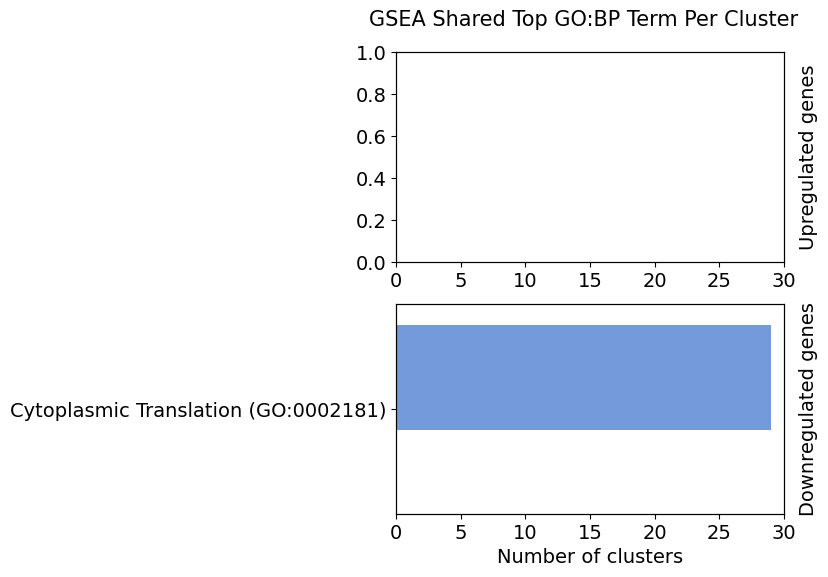

In [49]:
_ = plot_shared_top_terms_prerank_gsea(top_term_gobp8, "GSEA Shared Top GO:BP Term Per Cluster")

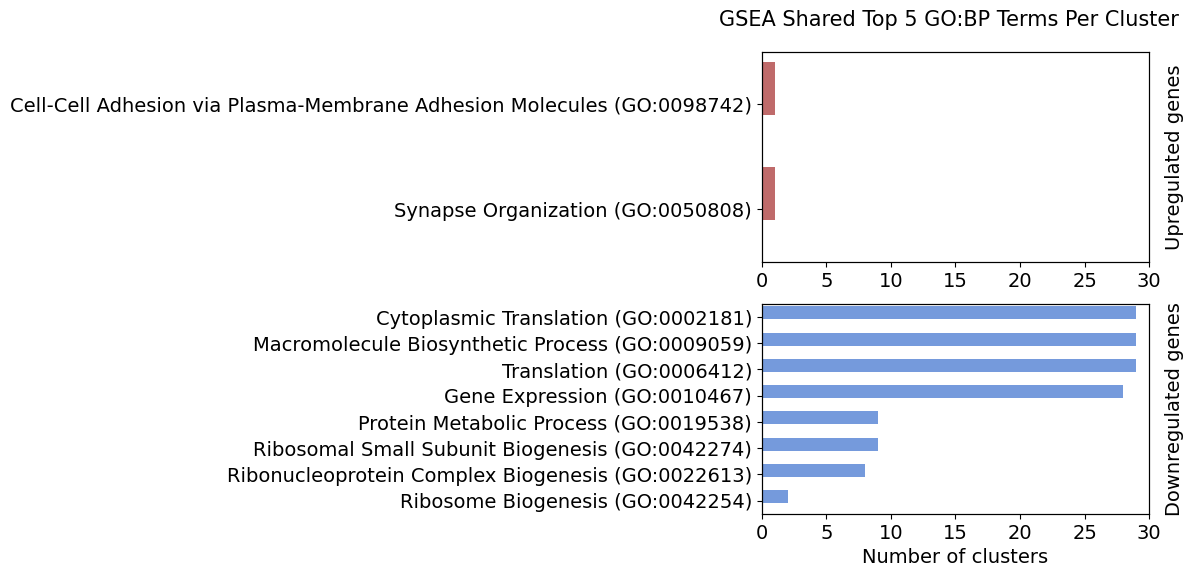

In [53]:
up_terms_gobp8, down_terms_gobp8 = \
    plot_shared_top_terms_prerank_gsea(top_5_terms_gobp8, "GSEA Shared Top 5 GO:BP Terms Per Cluster")

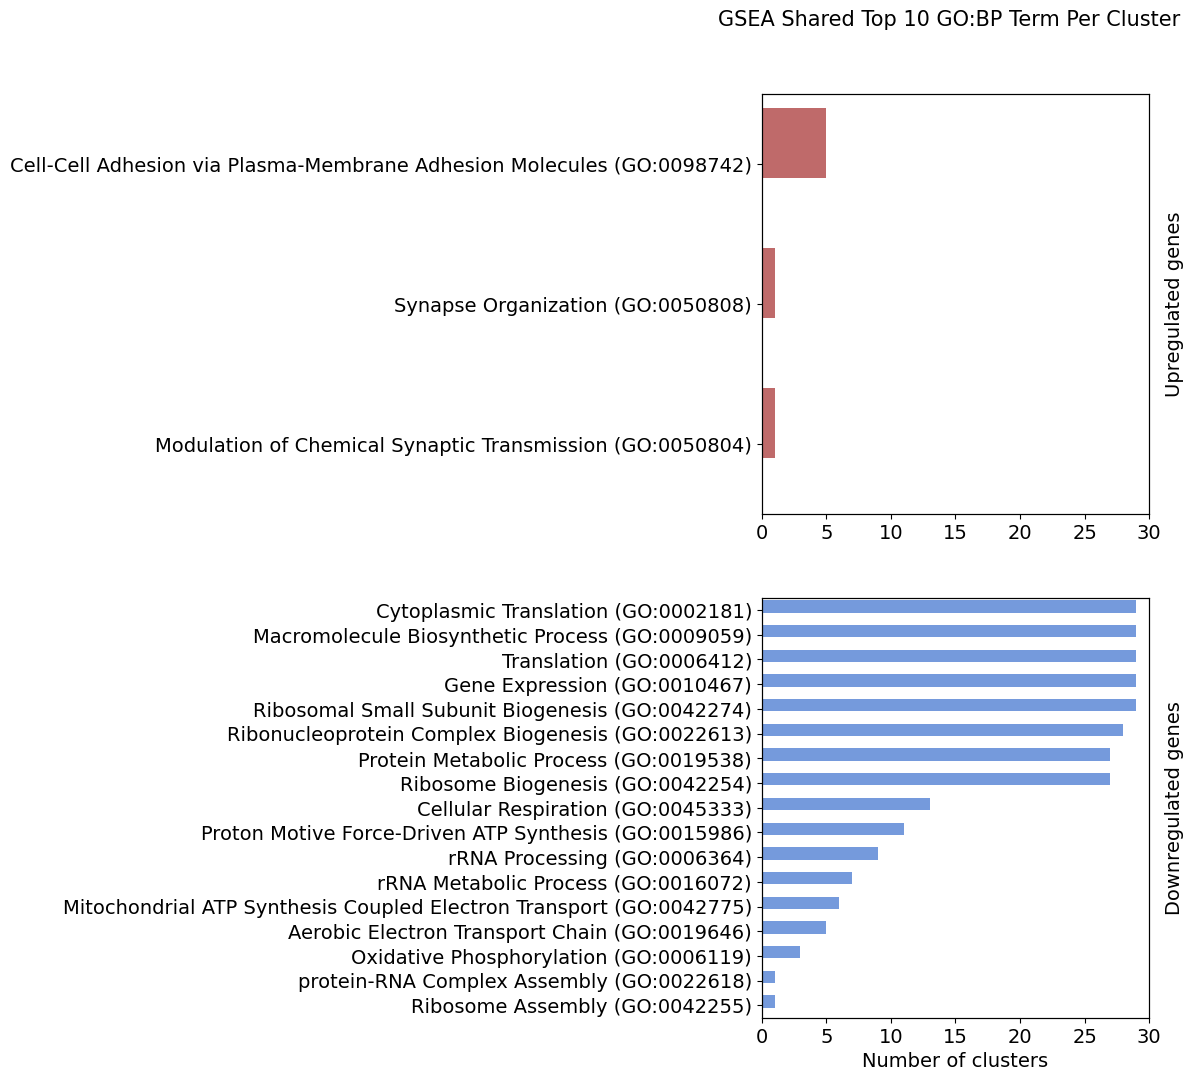

In [11]:
top_10_terms_gobp8 = top_gsea_terms_from_prerank_df(prerank_res_df_gobp8, 10)
_ = plot_shared_top_terms_prerank_gsea(top_10_terms_gobp8, "GSEA Shared Top 10 GO:BP Term Per Cluster", fig_size=(5,12))

In [56]:
up_terms_gobp8

Cluster                                               Term        ES  \
4        0  Cell-Cell Adhesion via Plasma-Membrane Adhesio...  0.675654   
4        2                  Synapse Organization (GO:0050808)  0.618489   

        NES NOM p-val FDR q-val FWER p-val  Tag %  Gene %  \
4  2.875446       0.0       0.0        0.0  33/87   9.73%   
4  2.761105       0.0       0.0        0.0  48/95  18.04%   

                                          Lead_genes  
4  ROBO2;GRID2;NLGN1;NRXN1;CADM2;HMCN1;CDH6;LRRC4...  
4  SYN3;NRXN1;ADGRL3;ANK3;NLGN1;PDZRN3;PTPRD;CDH2...

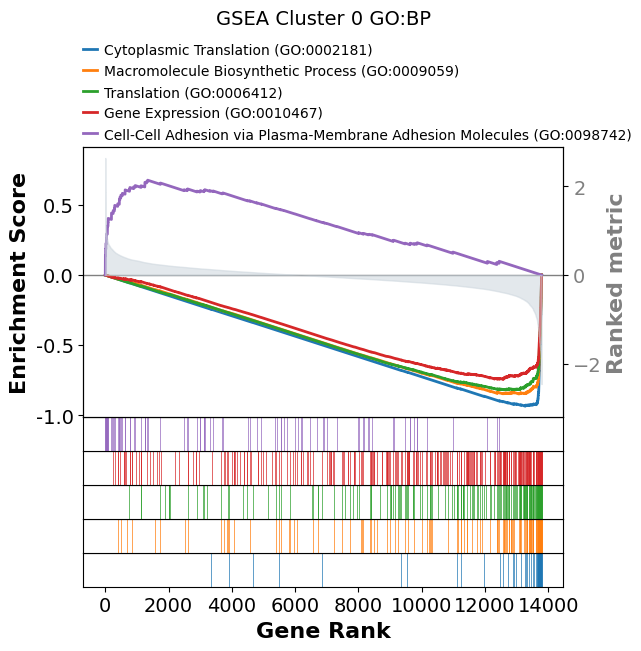

In [117]:
plot_terms_prerank_gsea(prerank_res_gobp8, cluster_num=0, n_terms=5, title="GSEA Cluster 0 GO:BP")

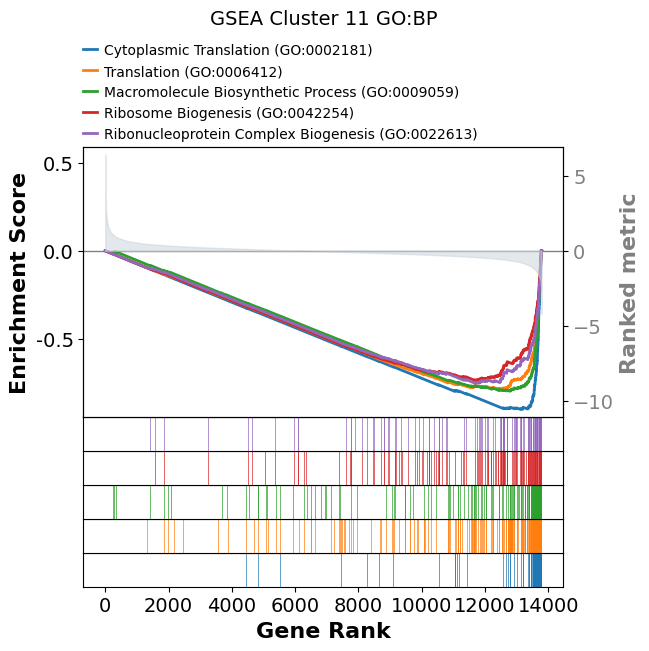

In [118]:
plot_terms_prerank_gsea(prerank_res_gobp8, cluster_num=11, n_terms=5, title="GSEA Cluster 11 GO:BP")

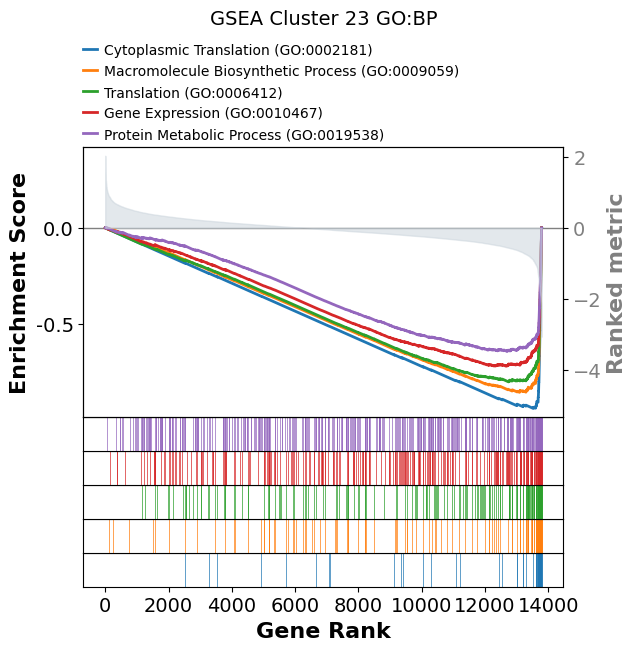

In [119]:
plot_terms_prerank_gsea(prerank_res_gobp8, cluster_num=23, n_terms=5, title="GSEA Cluster 23 GO:BP")

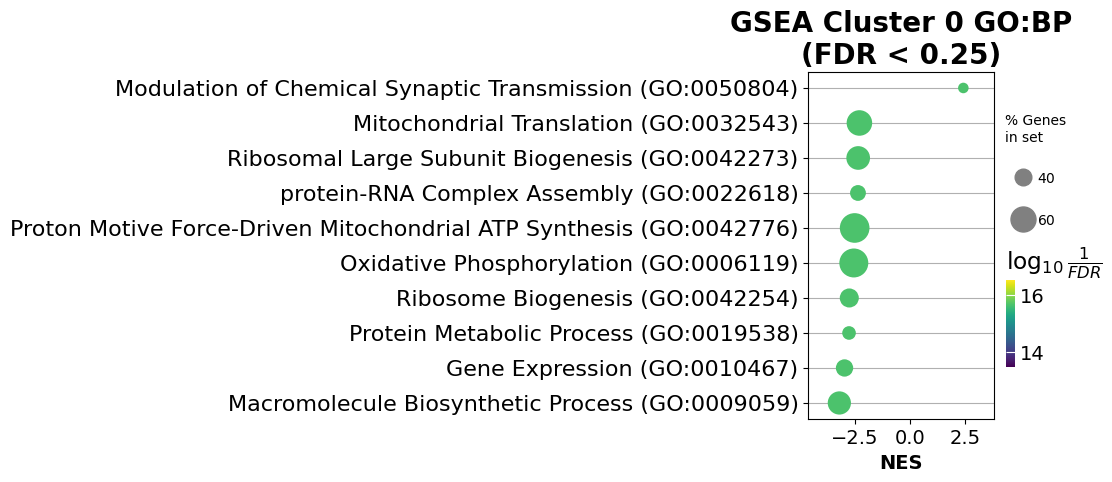

In [167]:
dotplot_terms_prerank_gsea(prerank_res_gobp8, cluster_num=0, 
                           title="GSEA Cluster 0 GO:BP\n(FDR < 0.25)", fig_size=(3, 4.5))

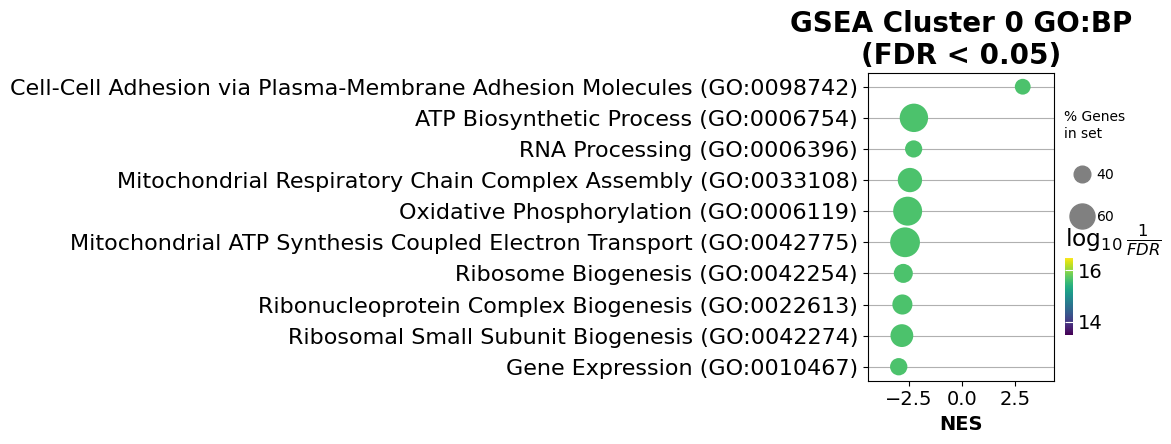

In [175]:
dotplot_terms_prerank_gsea(prerank_res_gobp8, cluster_num=0, 
                           title="GSEA Cluster 0 GO:BP\n(FDR < 0.05)", cutoff=0.05)

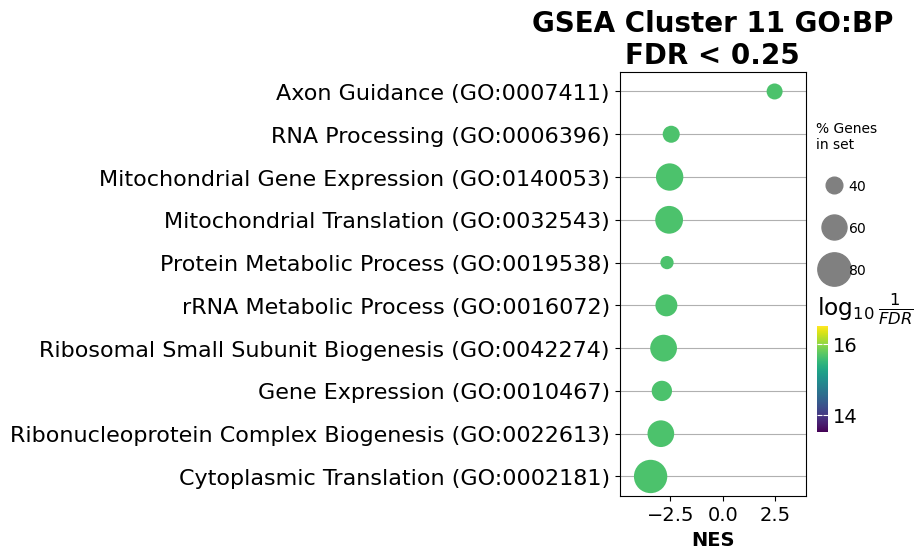

In [181]:
dotplot_terms_prerank_gsea(prerank_res_gobp8, cluster_num=11, 
                           title="GSEA Cluster 11 GO:BP\nFDR < 0.25", fig_size=(3,5.5))

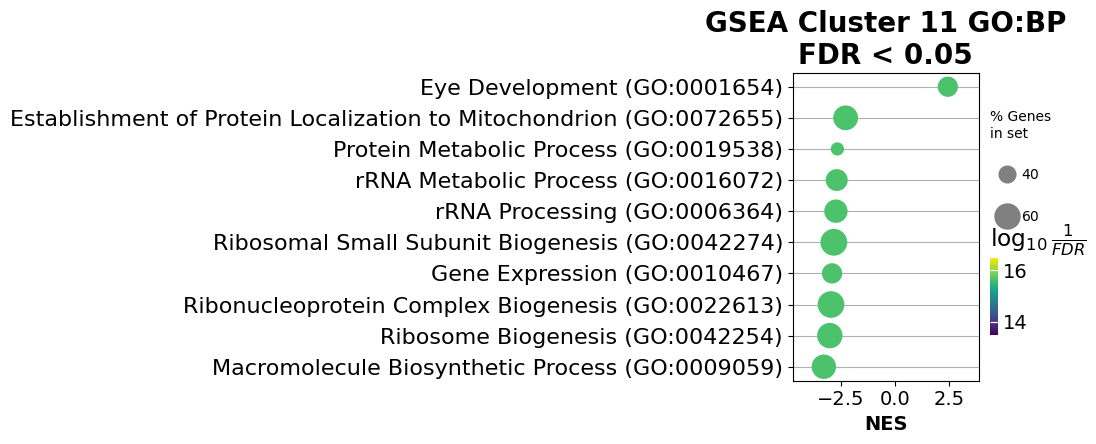

In [180]:
dotplot_terms_prerank_gsea(prerank_res_gobp8, cluster_num=11, 
                           title="GSEA Cluster 11 GO:BP\nFDR < 0.05", fig_size=(3,4), cutoff=0.05)

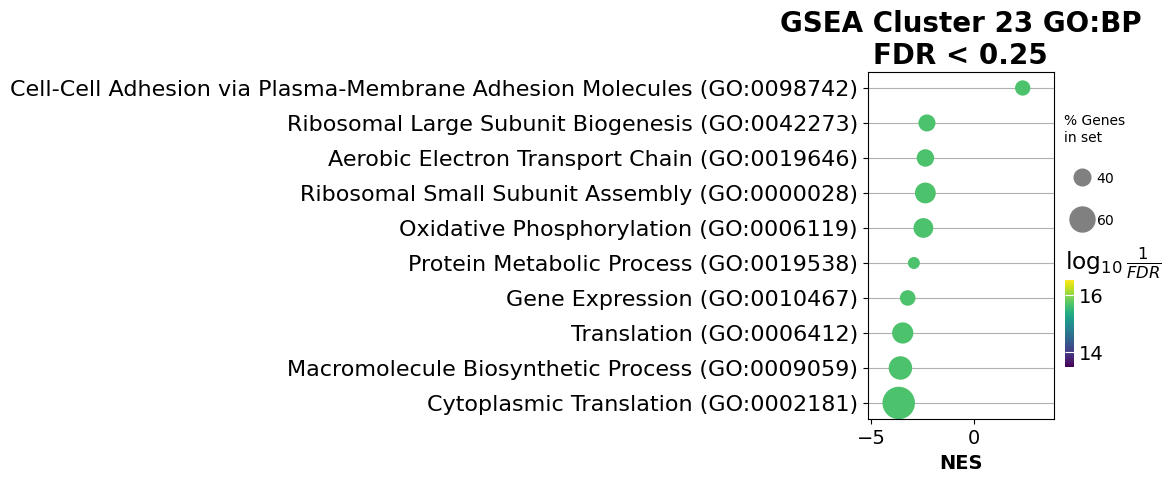

In [186]:
dotplot_terms_prerank_gsea(prerank_res_gobp8, cluster_num=23, 
                           title="GSEA Cluster 23 GO:BP\nFDR < 0.25", fig_size=(3,4.5))

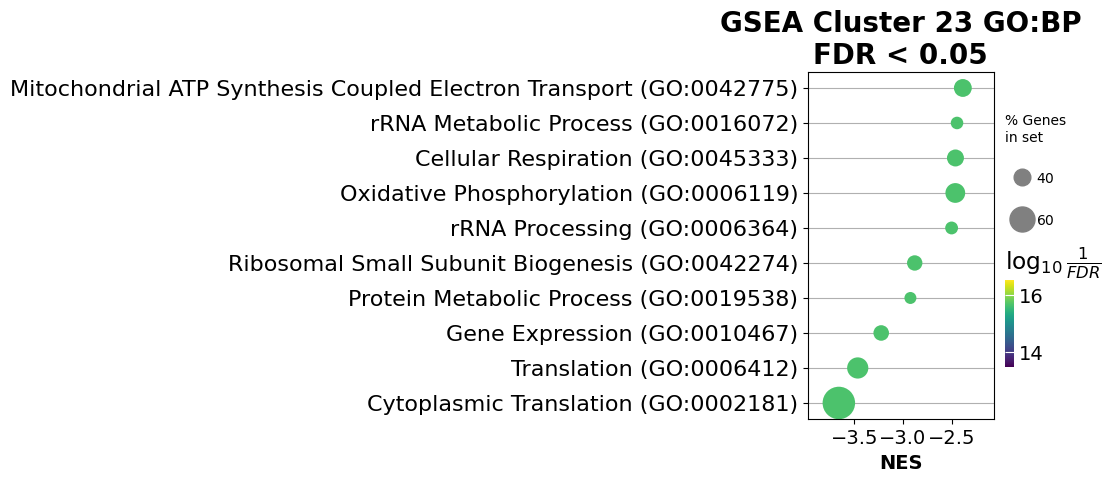

In [185]:
dotplot_terms_prerank_gsea(prerank_res_gobp8, cluster_num=23, 
                           title="GSEA Cluster 23 GO:BP\nFDR < 0.05", 
                           fig_size=(3,4.5), cutoff=0.05)

Save all GO:BP dotplots with FDR < 0.05

In [194]:
def plot_all_dotplots(prerank_results_dict, gene_set_lib, folder, gene_set_lib_abbrev):
    for cluster in prerank_results_dict.keys():
        title=f"GSEA Cluster {cluster} {gene_set_lib}\n(FDR < 0.05)"
        output_file_name = f"{folder}/gseapy_dotplot_{gene_set_lib_abbrev}_CL{cluster}.png"
        dotplot_terms_prerank_gsea(prerank_results_dict, cluster_num=cluster,
                                   title=title, fig_size=(3,6), cutoff=0.05, 
                                   output_filename=output_file_name)

In [195]:
gseapy_gobp_folder = "/home/ranwyl/results_tf_project/gseapy_gobp_figs"
plot_all_dotplots(prerank_res_gobp8, "GO:BP", gseapy_gobp_folder, "gobp")

In [ ]:
prerank_res_reac8 = prerank_gsea(clusters_8nbrs, de_results, "Reactome_Pathways_2024")

Processing cluster number: 100%|██████████| 29/29 [15:21<00:00, 31.76s/it]


In [ ]:
prerank_res_df_reac8 = build_prerank_gsea_results_df(prerank_res_reac)

In [ ]:
prerank_res_df_reac8.head(3)

In [ ]:
prerank_res_df_reac_fdr8 = prerank_res_df_reac8[(prerank_res_df_reac8["FDR q-val"] < 0.05)].copy()
prerank_res_df_reac_fdr8.head()

In [ ]:
prerank_res_df_reac8.shape

In [ ]:
# Save
prerank_res_df_reac8.to_pickle("/home/ranwyl/results_tf_project/gsea_reac_8nbrs.pkl")

In [ ]:
prerank_res_reac8[0].res2d.shape

(4246, 10)

In [ ]:
prerank_res_reac8[0].res2d.head()

In [ ]:
top_term_reac8 = top_gsea_terms_from_prerank_dict(prerank_res_reac8, n_top_terms=1)

In [ ]:
top_term_reac8.head()

In [ ]:
top_5_terms_reac8 = top_gsea_terms_from_prerank_dict(prerank_res_reac8, n_top_terms=5)

In [ ]:
_ = plot_shared_top_terms_prerank_gsea(top_term_reac8, "GSEA Shared Top Reactome Term Per Cluster")

In [ ]:
_ = plot_shared_top_terms_prerank_gsea(top_5_terms_reac8, "GSEA Shared Top 5 Reactome Terms Per Cluster")

In [ ]:
plot_terms_prerank_gsea(prerank_res_reac8, cluster_num=0, n_terms=5, title="GSEA Cluster 0 Reactome")

In [ ]:
plot_terms_prerank_gsea(prerank_res_reac8, cluster_num=11, n_terms=5, title="GSEA Cluster 11 Reactome")

In [ ]:
plot_terms_prerank_gsea(prerank_res_reac8, cluster_num=23, n_terms=5, title="GSEA Cluster 23 Reactome")

In [ ]:
dotplot_terms_prerank_gsea(prerank_res_reac8, cluster_num=0, 
                           title="GSEA Cluster 0 Reactome\n(FDR < 0.25)", fig_size=(3, 4.5))

In [ ]:
dotplot_terms_prerank_gsea(prerank_res_reac8, cluster_num=0, 
                           title="GSEA Cluster 0 Reactome\n(FDR < 0.05)", cutoff=0.05)

In [ ]:
dotplot_terms_prerank_gsea(prerank_res_reac8, cluster_num=11, 
                           title="GSEA Cluster 11 Reactome\n(FDR < 0.25)", fig_size=(3, 4.5))

In [ ]:
dotplot_terms_prerank_gsea(prerank_res_reac8, cluster_num=11, 
                           title="GSEA Cluster 11 Reactome\n(FDR < 0.05)", cutoff=0.05)

In [ ]:
dotplot_terms_prerank_gsea(prerank_res_reac8, cluster_num=23, 
                           title="GSEA Cluster 23 Reactome\n(FDR < 0.25)", fig_size=(3, 4.5))

In [ ]:
dotplot_terms_prerank_gsea(prerank_res_reac8, cluster_num=23, 
                           title="GSEA Cluster 23 Reactome\n(FDR < 0.05)", cutoff=0.05)

Save all GO:BP dotplots with FDR < 0.05

In [ ]:
def plot_all_dotplots(prerank_results_dict, gene_set_lib, folder, gene_set_lib_abbrev):
    for cluster in prerank_results_dict.keys():
        title=f"GSEA Cluster {cluster} {gene_set_lib}\n(FDR < 0.05)"
        output_file_name = f"{folder}/gseapy_dotplot_{gene_set_lib_abbrev}_CL{cluster}.png"
        dotplot_terms_prerank_gsea(prerank_results_dict, cluster_num=cluster,
                                   title=title, fig_size=(3,6), cutoff=0.05, 
                                   output_filename=output_file_name)

In [ ]:
gseapy_gobp_folder = "/home/ranwyl/results_tf_project/gseapy_reac_figs"
plot_all_dotplots(prerank_res_reac8, "Reactome", gseapy_gobp_folder, "reac")

### Reactome

In [ ]:
prerank_res_reac8 = prerank_gsea(clusters_8nbrs, de_results, "Reactome_Pathways_2024")

Processing cluster number: 100%|██████████| 29/29 [15:21<00:00, 31.76s/it]


In [ ]:
prerank_res_df_reac8 = build_prerank_gsea_results_df(prerank_res_reac8)

In [ ]:
prerank_res_df_reac8.head(3)

Cluster                                               Term        ES  \
0        0  Response of EIF2AK4 (GCN2) to Amino Acid Defic... -0.955738   
1        0  L13a-mediated Translational Silencing of Cerul... -0.932755   
2        0           Formation of a Pool of Free 40S Subunits -0.945244   

        NES NOM p-val FDR q-val FWER p-val   Tag % Gene %  \
0 -3.394836       0.0       0.0        0.0   82/97  2.38%   
1 -3.383922       0.0       0.0        0.0  91/109  3.74%   
2 -3.374474       0.0       0.0        0.0   88/99  3.74%   

                                          Lead_genes  
0  RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL32;RPS1...  
1  RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL32;RPS1...  
2  RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL32;RPS1...

In [ ]:
prerank_res_df_reac_fdr8 = prerank_res_df_reac8[(prerank_res_df_reac8["FDR q-val"] < 0.05)].copy()
prerank_res_df_reac_fdr8.head()

Cluster                                               Term        ES  \
0        0  Response of EIF2AK4 (GCN2) to Amino Acid Defic... -0.955738   
1        0  L13a-mediated Translational Silencing of Cerul... -0.932755   
2        0           Formation of a Pool of Free 40S Subunits -0.945244   
3        0                        Selenoamino Acid Metabolism -0.940342   
4        0                  Eukaryotic Translation Elongation -0.965283   

        NES NOM p-val FDR q-val FWER p-val   Tag % Gene %  \
0 -3.394836       0.0       0.0        0.0   82/97  2.38%   
1 -3.383922       0.0       0.0        0.0  91/109  3.74%   
2 -3.374474       0.0       0.0        0.0   88/99  3.74%   
3 -3.373223       0.0       0.0        0.0  82/111  2.38%   
4 -3.372793       0.0       0.0        0.0   85/91  2.53%   

                                          Lead_genes  
0  RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL32;RPS1...  
1  RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL32;RPS1...  
2  RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL32;RPS1...  
3  RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL32;RPS1...  
4  EEF1A1;RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL...

In [ ]:
prerank_res_df_reac8.shape

(51823, 10)

In [ ]:
# Save
prerank_res_df_reac8.to_pickle("/home/ranwyl/results_tf_project/gsea_reac_8nbrs.pkl")

In [ ]:
top_term_reac8 = top_gsea_terms_from_prerank_dict(prerank_res_reac8, n_top_terms=1)

In [ ]:
top_term_reac8.head()

Cluster                                               Term        ES  \
0        0  Response of EIF2AK4 (GCN2) to Amino Acid Defic... -0.955738   
0        1                           Selenocysteine Synthesis -0.967883   
0        2  SRP-dependent Cotranslational Protein Targetin... -0.941989   
0        3                           Selenocysteine Synthesis -0.967243   
0        4                           Selenocysteine Synthesis -0.970968   

        NES NOM p-val FDR q-val FWER p-val   Tag % Gene %  \
0 -3.394836       0.0       0.0        0.0   82/97  2.38%   
0 -3.379185       0.0       0.0        0.0   79/91  1.26%   
0 -3.424396       0.0       0.0        0.0  92/110  2.70%   
0 -3.456918       0.0       0.0        0.0   80/91  1.49%   
0 -3.465451       0.0       0.0        0.0   81/91  1.72%   

                                          Lead_genes  
0  RPL39;RPLP1;RPL23;RPS28;RPS12;RPS23;RPL32;RPS1...  
0  RPLP1;RPS18;RPS14;RPS28;RPL23;RPS8;RPL41;RPS2;...  
0  RPLP1;RPS12;RPL39;RPS6;RPS2;RPS23;RPS8;RPS3A;R...  
0  RPLP1;RPS28;RPS12;RPS8;RPS15A;RPL39;RPL35A;RPS...  
0  RPLP1;RPS8;RPL39;RPS28;RPL8;RPS23;RPL30;RPS3;R...

In [ ]:
top_5_terms_reac8 = top_gsea_terms_from_prerank_dict(prerank_res_reac8, n_top_terms=5)

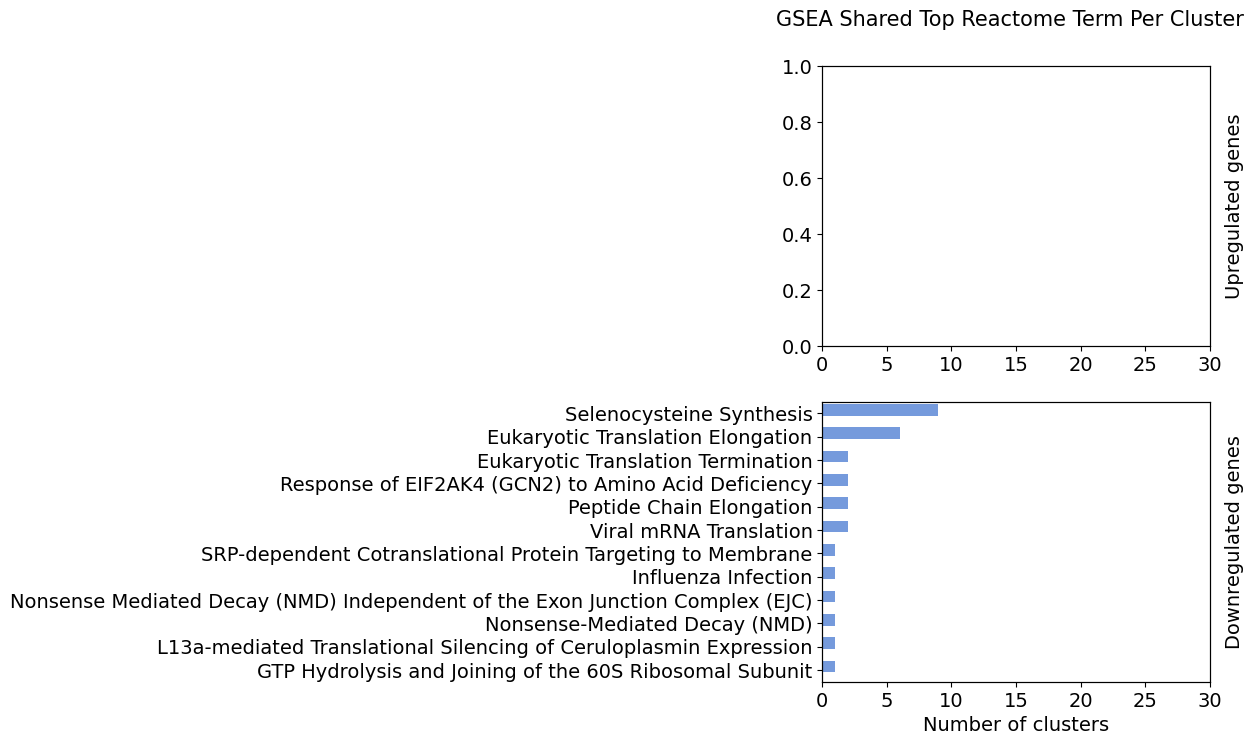

In [ ]:
_ = plot_shared_top_terms_prerank_gsea(top_term_reac8, 
"GSEA Shared Top Reactome Term Per Cluster", fig_size=(5,8))

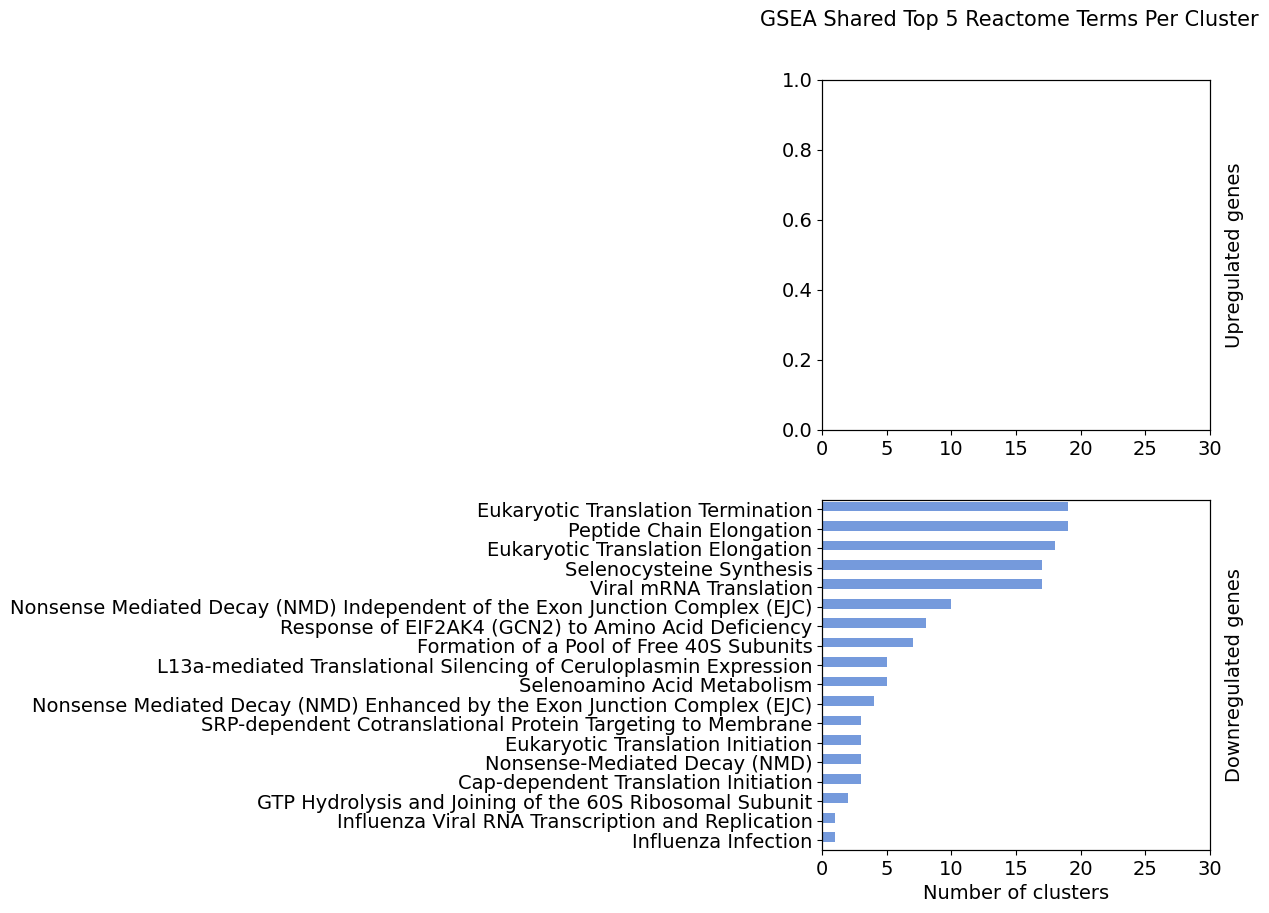

In [ ]:
_ = plot_shared_top_terms_prerank_gsea(top_5_terms_reac8, 
"GSEA Shared Top 5 Reactome Terms Per Cluster", fig_size=(5,10))

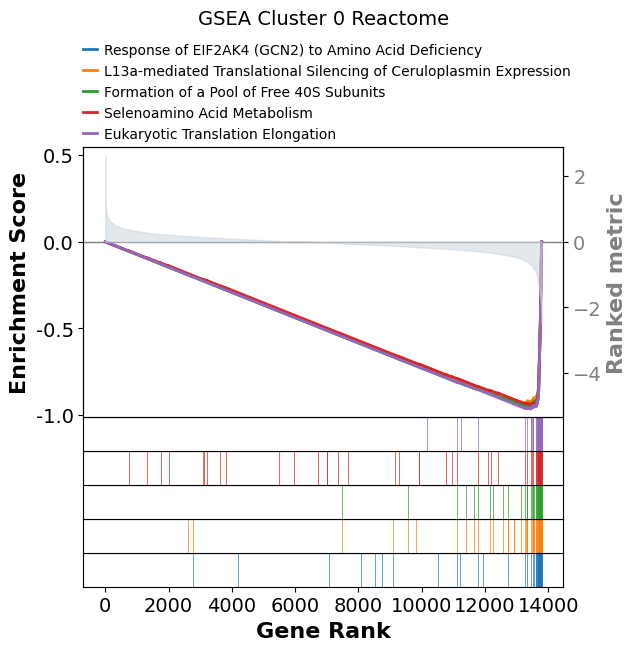

In [ ]:
plot_terms_prerank_gsea(prerank_res_reac8, cluster_num=0, n_terms=5, title="GSEA Cluster 0 Reactome")

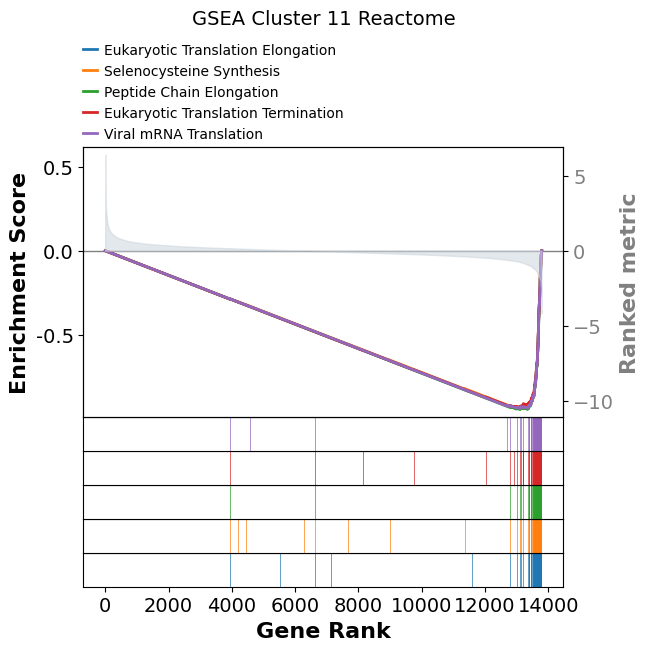

In [ ]:
plot_terms_prerank_gsea(prerank_res_reac8, cluster_num=11, n_terms=5, title="GSEA Cluster 11 Reactome")

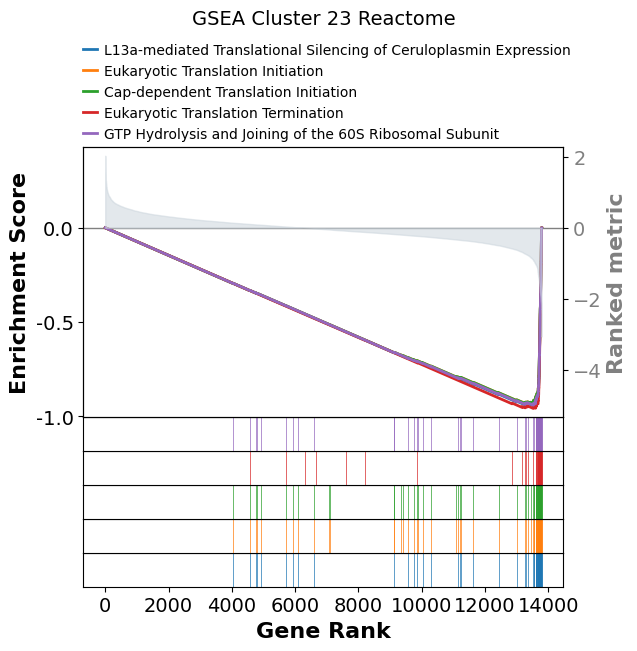

In [ ]:
plot_terms_prerank_gsea(prerank_res_reac8, cluster_num=23, n_terms=5, title="GSEA Cluster 23 Reactome")

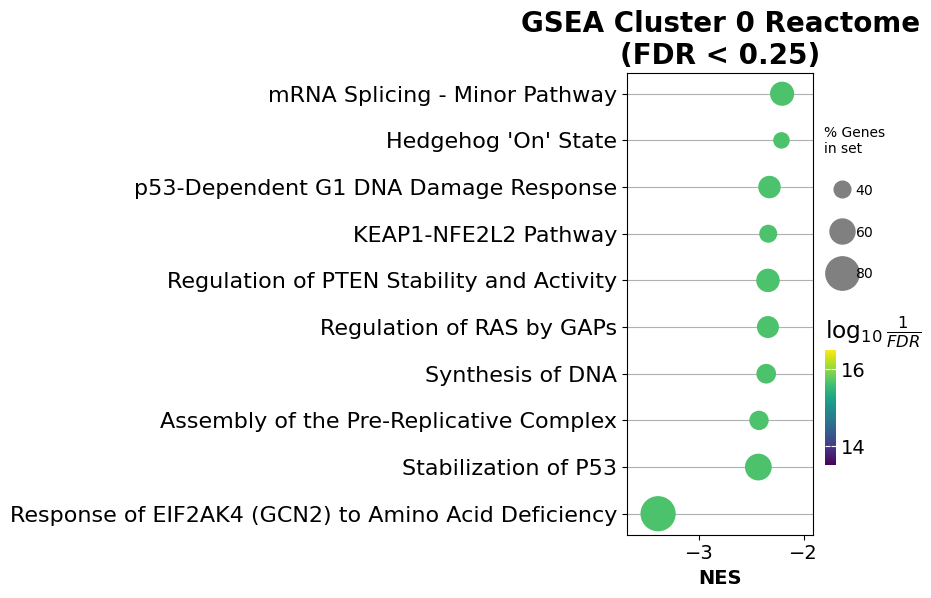

In [ ]:
dotplot_terms_prerank_gsea(prerank_res_reac8, cluster_num=0, 
                           title="GSEA Cluster 0 Reactome\n(FDR < 0.25)", fig_size=(3,6))

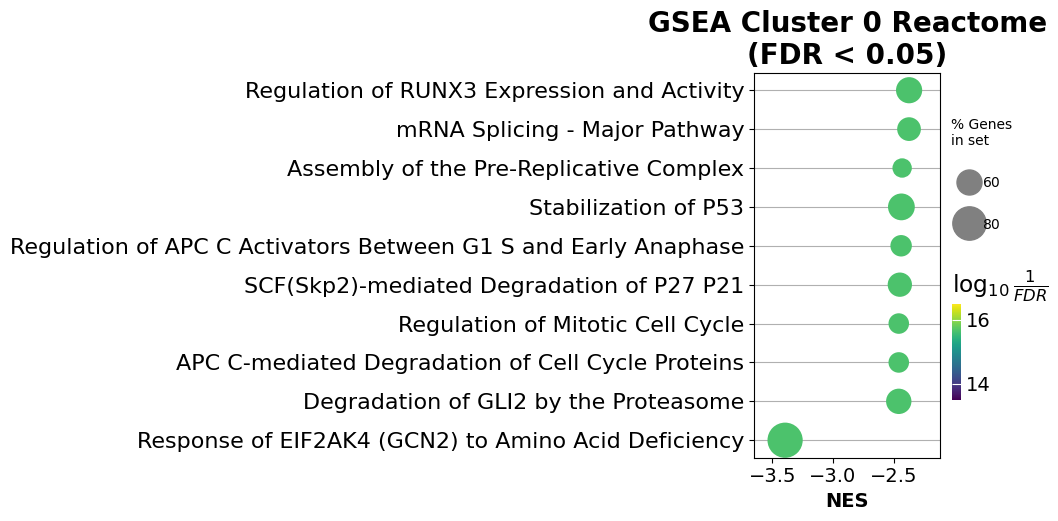

In [ ]:
dotplot_terms_prerank_gsea(prerank_res_reac8, cluster_num=0, 
                           title="GSEA Cluster 0 Reactome\n(FDR < 0.05)", cutoff=0.05, fig_size=(3,5))

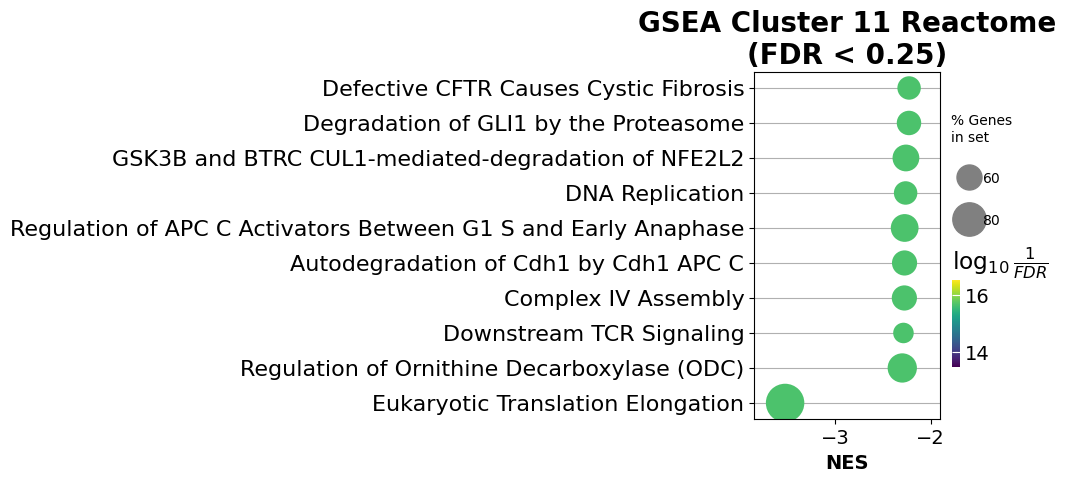

In [ ]:
dotplot_terms_prerank_gsea(prerank_res_reac8, cluster_num=11, 
                           title="GSEA Cluster 11 Reactome\n(FDR < 0.25)", fig_size=(3, 4.5))

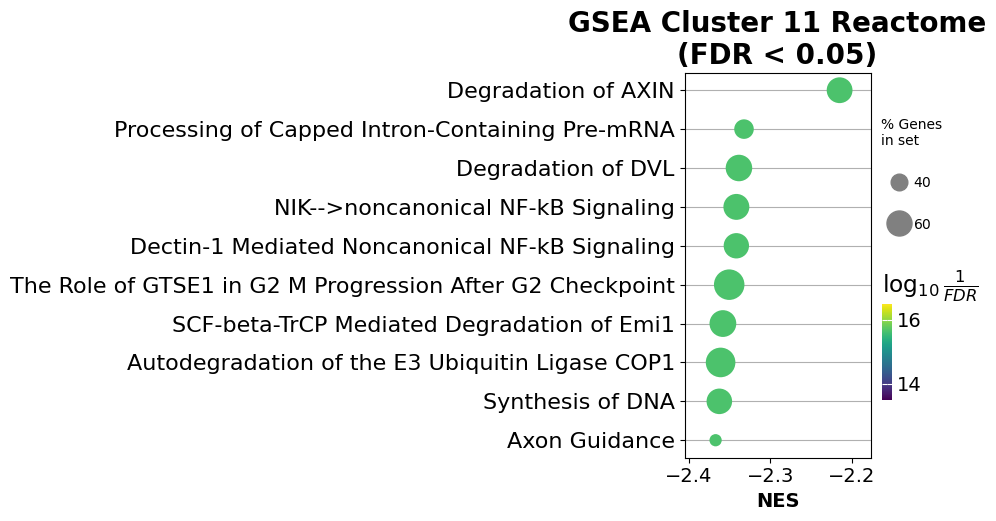

In [ ]:
dotplot_terms_prerank_gsea(prerank_res_reac8, cluster_num=11, 
                           title="GSEA Cluster 11 Reactome\n(FDR < 0.05)", cutoff=0.05, fig_size=(3,5))

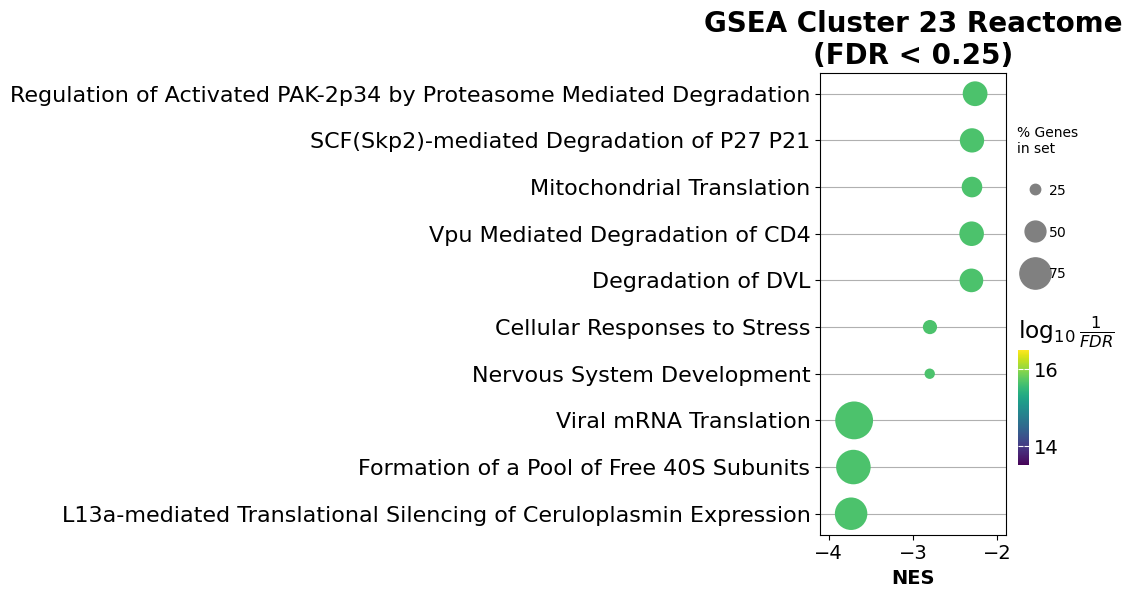

In [ ]:
dotplot_terms_prerank_gsea(prerank_res_reac8, cluster_num=23, 
                           title="GSEA Cluster 23 Reactome\n(FDR < 0.25)", fig_size=(3, 6))

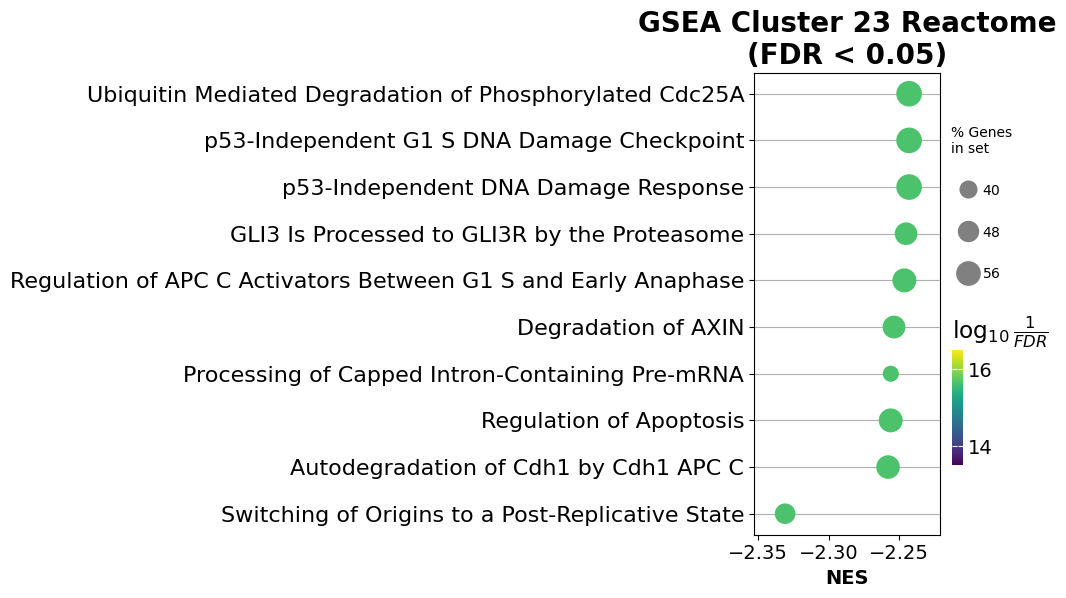

In [ ]:
dotplot_terms_prerank_gsea(prerank_res_reac8, cluster_num=23, 
                           title="GSEA Cluster 23 Reactome\n(FDR < 0.05)", cutoff=0.05, fig_size=(3,6))

Save all Reactome dotplots with FDR < 0.05

In [ ]:
def plot_all_dotplots(prerank_results_dict, gene_set_lib, folder, gene_set_lib_abbrev):
    clusters = list(prerank_results_dict.keys())
    for i in tqdm(range(len(clusters)), desc="Processing cluster number"):
        cluster = clusters[i]
        title=f"GSEA Cluster {cluster} {gene_set_lib}\n(FDR < 0.05)"
        output_file_name = f"{folder}/gseapy_dotplot_{gene_set_lib_abbrev}_CL{cluster}.png"
        dotplot_terms_prerank_gsea(prerank_results_dict, cluster_num=cluster,
                                   title=title, fig_size=(3,6), cutoff=0.05, 
                                   output_filename=output_file_name)

In [ ]:
gseapy_reac_folder = "/home/ranwyl/results_tf_project/gseapy_reac_figs"
plot_all_dotplots(prerank_res_reac8, "Reactome", gseapy_reac_folder, "reac")

Processing cluster number: 100%|██████████| 29/29 [00:19<00:00,  1.51it/s]


### MSigDB Hallmark

In [7]:
prerank_res_hallmark8 = prerank_gsea(clusters_8nbrs, de_results, "MSigDB_Hallmark_2020")

Processing cluster number:   0%|          | 0/28 [00:00<?, ?it/s]

Processing cluster number: 100%|██████████| 28/28 [00:38<00:00,  1.37s/it]


In [8]:
prerank_res_df_hallmark8 = build_prerank_gsea_results_df(prerank_res_hallmark8)

In [9]:
prerank_res_df_hallmark8.head(5)

Cluster                       Term        ES       NES NOM p-val FDR q-val  \
0        0             Myc Targets V1 -0.784574 -2.999088       0.0       0.0   
1        0  Oxidative Phosphorylation -0.725112 -2.768131       0.0       0.0   
2        0             UV Response Dn  0.509999  2.282448       0.0       0.0   
3        0           mTORC1 Signaling -0.573514 -2.161906       0.0       0.0   
4        0  Unfolded Protein Response -0.601105 -2.133628       0.0       0.0   

  FWER p-val    Tag %  Gene %  \
0        0.0  137/199  12.92%   
1        0.0  107/196  12.70%   
2        0.0   59/128  20.03%   
3        0.0   83/188  18.60%   
4        0.0   46/109  18.59%   

                                          Lead_genes  
0  RPS10;H2AZ1;RPS2;RPS3;RPS6;NPM1;RAN;RPLP0;RPS5...  
1  ATP5MC3;UQCRH;SLC25A6;COX7C;PRDX3;NDUFA4;SLC25...  
2  MAGI2;ADGRL2;PLCB4;IGF1R;CDC42BPA;BCKDHB;MMP16...  
3  PRDX1;PPIA;GAPDH;HSPE1;PSMA3;LDHA;HSPD1;ENO1;S...  
4  RPS14;NPM1;EIF4A1;CKS1B;LSM4;SEC11A;PDIA6;BANF...

In [19]:
prerank_res_df_hallmark8.head(20)

Cluster                             Term        ES       NES NOM p-val  \
0         0                   Myc Targets V1 -0.792242 -3.072981       0.0   
1         0        Oxidative Phosphorylation -0.709394 -2.751148       0.0   
2         0                   Myc Targets V2 -0.699512 -2.263479       0.0   
3         0  Reactive Oxygen Species Pathway -0.703148 -2.186322       0.0   
4         0                 mTORC1 Signaling -0.550922 -2.123002       0.0   
5         0        Unfolded Protein Response -0.576021 -2.091708       0.0   
6         0                      E2F Targets -0.509788 -1.973109       0.0   
7         0                       DNA Repair -0.514795 -1.936719       0.0   
8         0              Allograft Rejection -0.523857 -1.838335  0.001215   
9         0            Fatty Acid Metabolism -0.486733 -1.803316  0.001188   
10        0                   UV Response Dn   0.39297   1.79914       0.0   
11        0            Xenobiotic Metabolism -0.483688 -1.778073  0.002404   
12        0                     Adipogenesis -0.468398 -1.767991       0.0   
13        0                  G2-M Checkpoint -0.436136 -1.674799  0.001086   
14        0                   UV Response Up -0.452452 -1.669771       0.0   
15        0                      Pperoxisome -0.479024 -1.668865       0.0   
16        0                       Glycolysis -0.421474 -1.596493       0.0   
17        0              Pancreas Beta Cells -0.591999 -1.545148  0.047976   
18        0                  Mitotic Spindle  0.319693  1.527909       0.0   
19        0                KRAS Signaling Dn  0.345721  1.475533  0.005025   

   FDR q-val FWER p-val    Tag %  Gene %  \
0        0.0        0.0  129/199  12.30%   
1        0.0        0.0  111/196  13.92%   
2        0.0        0.0    36/55  22.07%   
3        0.0        0.0    18/42   9.51%   
4        0.0        0.0   99/188  24.94%   
5        0.0        0.0   53/109  23.27%   
6   0.000142      0.001   79/198  19.30%   
7   0.000248      0.002   54/142  16.91%   
8   0.000991      0.009    24/86  17.41%   
9   0.001585      0.016   51/117  22.09%   
10  0.009397      0.009   37/128  14.01%   
11  0.002252      0.025   50/121  24.73%   
12  0.002807      0.034   65/172  20.40%   
13  0.007241      0.088   50/193  11.34%   
14  0.007006      0.092   56/132  25.03%   
15  0.006539      0.092    27/82  20.87%   
16  0.012447      0.181   56/168  23.57%   
17  0.020807      0.291     5/17   8.25%   
18  0.054292        0.1   64/195  19.88%   
19  0.052204      0.134    19/76  17.77%   

                                           Lead_genes  
0   RPS6;RPS2;H2AZ1;RPL34;RPS10;EIF4A1;RPS3;RAN;NP...  
1   COX7C;ATP5MC3;UQCRH;CYCS;ATP5MG;NDUFA4;SLC25A3...  
2   NPM1;HSPE1;HSPD1;NDUFAF4;PA2G4;CBX3;UNG;NOLC1;...  
3   PRDX1;FTL;MGST1;TXN;PRDX2;SELENOS;GPX4;LAMTOR5...  
4   PRDX1;PPIA;HSPE1;HSPD1;CD9;PSMB5;TPI1;SEC11A;G...  
5   RPS14;EIF4A1;NPM1;CKS1B;PDIA6;SEC11A;YWHAZ;NHP...  
6   H2AZ1;RAN;RANBP1;STMN1;HMGA1;CKS2;SRSF2;CKS1B;...  
7   RBX1;COX17;POLR2K;IMPDH2;DUT;NME4;DGUOK;POLR2I...  
8   RPL39;RPS3A;NPM1;RPL9;RPS9;RPS19;EIF5A;NME1;TH...  
9   H2AZ1;MIF;HSP90AA1;LDHA;YWHAH;SDHC;OSTC;ENO2;E...  
10  BCKDHB;MAGI2;ATP2C1;MT1E;PTPRM;RUNX1;APBB2;AKT...  
11  PTGES3;DDT;ADH5;SPINT2;PGD;PGRMC1;TNFRSF1A;DDA...  
12  DDT;PRDX3;TALDO1;UQCRQ;SDHC;AIFM1;COX6A1;NDUFA...  
13  H2AZ1;STMN1;HMGA1;CKS2;SRSF2;CKS1B;HMGN2;SNRPD...  
14  PPIF;AP2S1;ENO2;POLR2H;SELENOW;ATP6V1F;SIGMAR1...  
15  PRDX1;YWHAH;CRABP1;PRDX5;CNBP;IDH2;SLC25A4;PAB...  
16  PPIA;STMN1;MIF;TXN;TPI1;LDHA;TALDO1;SDHC;PGAM1...  
17                      SRP14;SEC11A;SPCS1;SRPRB;SRP9  
18  MYH10;ITSN1;DST;SPTBN1;CENPE;FLNA;DYNC1H1;AKAP...  
19  GRID2;RYR2;BTG2;TENM2;THRB;CDKAL1;ACTC1;DTNB;P...

In [76]:
# Save
prerank_res_df_hallmark8.to_pickle("/home/ranwyl/results_tf_project/gsea_hallmark_mde_4265degs_padj_8nbrs.pkl")

In [84]:
prerank_res_df_hallmark8 = pd.read_pickle("/home/ranwyl/results_tf_project/gsea_hallmark_mde_4265degs_padj_8nbrs.pkl")
prerank_res_df_hallmark8.head()

Cluster                       Term        ES       NES NOM p-val FDR q-val  \
0        0             Myc Targets V1 -0.784574 -2.999088       0.0       0.0   
1        0  Oxidative Phosphorylation -0.725112 -2.768131       0.0       0.0   
2        0             UV Response Dn  0.509999  2.282448       0.0       0.0   
3        0           mTORC1 Signaling -0.573514 -2.161906       0.0       0.0   
4        0  Unfolded Protein Response -0.601105 -2.133628       0.0       0.0   

  FWER p-val    Tag %  Gene %  \
0        0.0  137/199  12.92%   
1        0.0  107/196  12.70%   
2        0.0   59/128  20.03%   
3        0.0   83/188  18.60%   
4        0.0   46/109  18.59%   

                                          Lead_genes  
0  RPS10;H2AZ1;RPS2;RPS3;RPS6;NPM1;RAN;RPLP0;RPS5...  
1  ATP5MC3;UQCRH;SLC25A6;COX7C;PRDX3;NDUFA4;SLC25...  
2  MAGI2;ADGRL2;PLCB4;IGF1R;CDC42BPA;BCKDHB;MMP16...  
3  PRDX1;PPIA;GAPDH;HSPE1;PSMA3;LDHA;HSPD1;ENO1;S...  
4  RPS14;NPM1;EIF4A1;CKS1B;LSM4;SEC11A;PDIA6;BANF...

In [78]:
top_term_hallmark8 = top_gsea_terms_from_prerank_dict(prerank_res_hallmark8, n_top_terms=1)

In [79]:
top_term_hallmark8.head()

Cluster            Term        ES       NES NOM p-val FDR q-val FWER p-val  \
0        0  Myc Targets V1 -0.784574 -2.999088       0.0       0.0        0.0   
0        1  Myc Targets V1 -0.781031 -2.927445       0.0       0.0        0.0   
0        2  Myc Targets V1 -0.746425 -2.908199       0.0       0.0        0.0   
0        3  Myc Targets V1 -0.788639 -3.048009       0.0       0.0        0.0   
0        4  Myc Targets V1 -0.791584 -3.161018       0.0       0.0        0.0   

     Tag %  Gene %                                         Lead_genes  
0  137/199  12.92%  RPS10;H2AZ1;RPS2;RPS3;RPS6;NPM1;RAN;RPLP0;RPS5...  
0  130/199  12.28%  RPS3;RPS10;RPS2;H2AZ1;RPS6;EIF4A1;RPL18;RPL14;...  
0  110/199  10.83%  RPL34;RPS2;RPS10;RPS6;PPIA;SET;RPL14;RPS5;H2AZ...  
0  140/199  13.83%  RPS2;RAN;H2AZ1;RPS10;EIF4A1;HSP90AB1;NPM1;RPS6...  
0  132/199  10.90%  SET;NPM1;HSP90AB1;RAN;RPS2;RPS3;EIF4A1;RPS6;HS...

In [85]:
top_5_terms_hallmark8 = top_gsea_terms_from_prerank_dict(prerank_res_hallmark8, n_top_terms=5)

In [86]:
top_10_terms_hallmark8 = top_gsea_terms_from_prerank_df(prerank_res_df_hallmark8, 10)

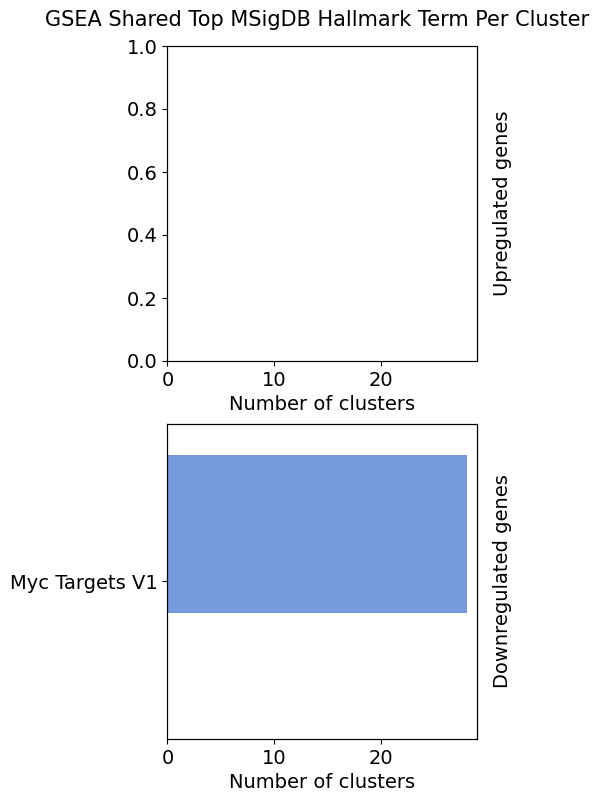

In [106]:
_ = plot_shared_top_terms_prerank_gsea(top_term_hallmark8, 
"GSEA Shared Top MSigDB Hallmark Term Per Cluster")

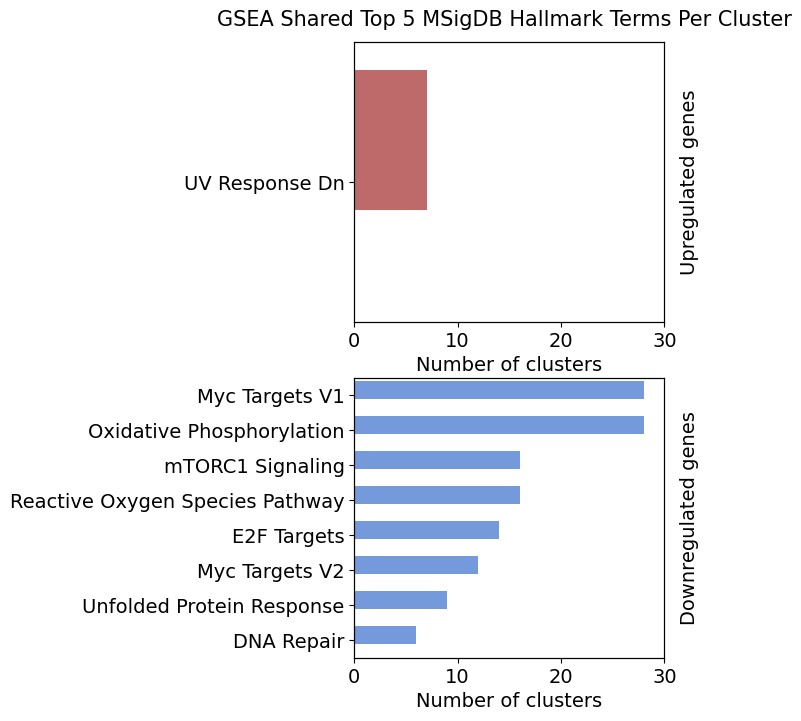

In [144]:
term_list5, up_df5, down_df5 = plot_shared_top_terms_prerank_gsea(top_5_terms_hallmark8, 
"GSEA Shared Top 5 MSigDB Hallmark Terms Per Cluster", xmax=30, min_clusters=2, fig_size=(4,8))

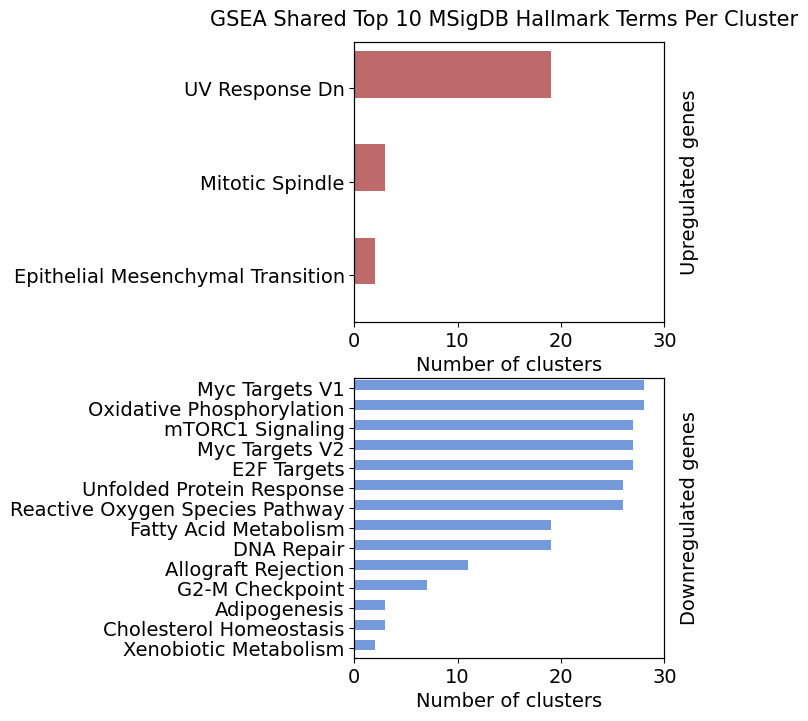

In [143]:
term_list10, _, _ = plot_shared_top_terms_prerank_gsea(top_10_terms_hallmark8, 
"GSEA Shared Top 10 MSigDB Hallmark Terms Per Cluster", xmax=30, min_clusters=2, fig_size=(4,8))

In [153]:
pd.set_option('display.max_rows', None)
top_terms = prerank_res_df_hallmark8.groupby("Cluster").head(25)[["Cluster", "Term", "NES", "FDR q-val"]]
top_terms = top_terms[top_terms["FDR q-val"] < 0.05]
top_term_counts = pd.DataFrame(top_terms["Term"].value_counts())
top_term_counts_unique = top_term_counts[top_term_counts["count"] < 7]
unique_term_list = top_term_counts_unique.index.tolist()
top_terms[top_terms["Term"].isin(unique_term_list)]

Cluster                               Term       NES FDR q-val
19        0          Interferon Alpha Response -1.466833  0.046027
20        3          Interferon Alpha Response -1.499172  0.030093
22        3                        p53 Pathway -1.457018  0.041633
4         4  Epithelial Mesenchymal Transition  2.322531       0.0
13        4              Inflammatory Response  1.866857  0.003152
15        4                 TGF-beta Signaling  1.672913   0.01559
18        6                        p53 Pathway  -1.57571  0.016581
19        8                 TGF-beta Signaling -1.449259  0.046741
20        9          Interferon Alpha Response -1.502023   0.03221
23        9  Epithelial Mesenchymal Transition  1.397507  0.049125
24        9                       Angiogenesis  1.375771  0.048542
19       10          Interferon Alpha Response -1.459183   0.04891
15       11                     Apical Surface  1.622979  0.015501
19       11                        p53 Pathway -1.538815  0.023417
14       16                       Angiogenesis  1.573937  0.035067
13       17          Interferon Alpha Response -1.529557  0.035518
17       18                        p53 Pathway  -1.49573  0.041475
12       19                         Myogenesis  1.619559  0.037034
14       19  Epithelial Mesenchymal Transition  1.589677   0.03234
19       21                  Protein Secretion -1.447558  0.046132
9        22  Epithelial Mesenchymal Transition  1.664854  0.025623
17       23                       Angiogenesis  1.518668  0.037535
18       24                        p53 Pathway -1.461754  0.049985
11       27                     Apical Surface  1.660436  0.039724
18       27             Estrogen Response Late -1.540575  0.020428
21       27                  Protein Secretion -1.444183    0.0454

In [154]:
pd.set_option('display.max_rows', None)
top_terms = prerank_res_df_hallmark8.groupby("Cluster").head(25)[["Cluster", "Term", "NES", "FDR q-val"]]
top_terms = top_terms[top_terms["FDR q-val"] < 0.05]
top_term_counts = pd.DataFrame(top_terms["Term"].value_counts())
top_term_counts_unique = top_term_counts[top_term_counts["count"] < 3]
unique_term_list = top_term_counts_unique.index.tolist()
top_terms[top_terms["Term"].isin(unique_term_list)]

Cluster                    Term       NES FDR q-val
13        4   Inflammatory Response  1.866857  0.003152
15        4      TGF-beta Signaling  1.672913   0.01559
19        8      TGF-beta Signaling -1.449259  0.046741
15       11          Apical Surface  1.622979  0.015501
12       19              Myogenesis  1.619559  0.037034
19       21       Protein Secretion -1.447558  0.046132
11       27          Apical Surface  1.660436  0.039724
18       27  Estrogen Response Late -1.540575  0.020428
21       27       Protein Secretion -1.444183    0.0454

In [155]:
pd.set_option('display.max_rows', None)
top_terms = prerank_res_df_hallmark8.groupby("Cluster").head(25)[["Cluster", "Term", "NES", "FDR q-val"]]
top_terms = top_terms[top_terms["FDR q-val"] < 0.05]
top_term_counts = pd.DataFrame(top_terms["Term"].value_counts())
top_term_counts_unique = top_term_counts[top_term_counts["count"] < 2]
unique_term_list = top_term_counts_unique.index.tolist()
top_terms[top_terms["Term"].isin(unique_term_list)]

Cluster                    Term       NES FDR q-val
13        4   Inflammatory Response  1.866857  0.003152
12       19              Myogenesis  1.619559  0.037034
18       27  Estrogen Response Late -1.540575  0.020428

Cluster 4

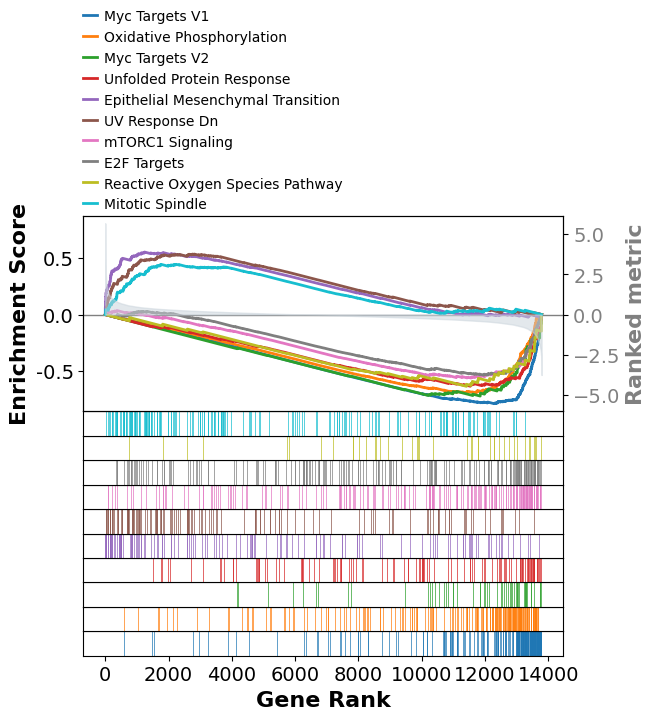

In [159]:
plot_terms_prerank_gsea(prerank_res_hallmark8, cluster_num=4, n_terms=10, title="")

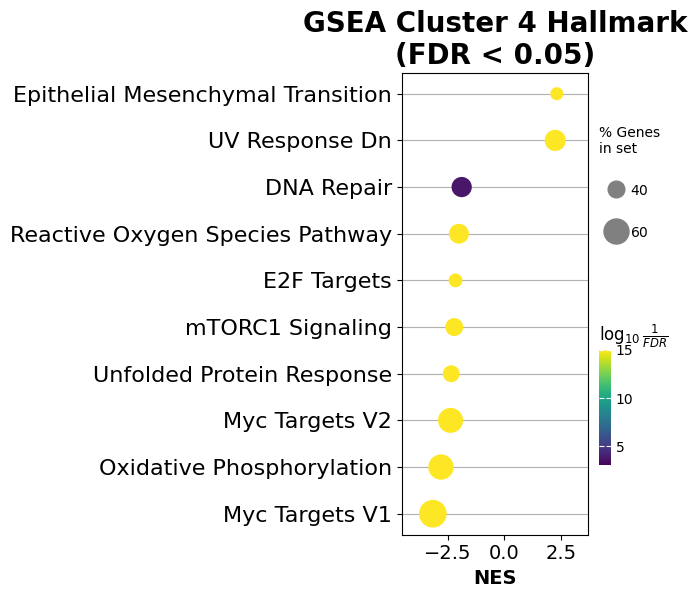

In [14]:
dotplot_terms_prerank_gsea(prerank_res_hallmark8, cluster_num=4, cutoff=0.05, fig_size=(3,6),
                           title="GSEA Cluster 4 Hallmark\n(FDR < 0.05)")

In [15]:
prerank_res_df_hallmark8.head()

Cluster                       Term        ES       NES NOM p-val FDR q-val  \
0        0             Myc Targets V1 -0.784574 -2.999088       0.0       0.0   
1        0  Oxidative Phosphorylation -0.725112 -2.768131       0.0       0.0   
2        0             UV Response Dn  0.509999  2.282448       0.0       0.0   
3        0           mTORC1 Signaling -0.573514 -2.161906       0.0       0.0   
4        0  Unfolded Protein Response -0.601105 -2.133628       0.0       0.0   

  FWER p-val    Tag %  Gene %  \
0        0.0  137/199  12.92%   
1        0.0  107/196  12.70%   
2        0.0   59/128  20.03%   
3        0.0   83/188  18.60%   
4        0.0   46/109  18.59%   

                                          Lead_genes  
0  RPS10;H2AZ1;RPS2;RPS3;RPS6;NPM1;RAN;RPLP0;RPS5...  
1  ATP5MC3;UQCRH;SLC25A6;COX7C;PRDX3;NDUFA4;SLC25...  
2  MAGI2;ADGRL2;PLCB4;IGF1R;CDC42BPA;BCKDHB;MMP16...  
3  PRDX1;PPIA;GAPDH;HSPE1;PSMA3;LDHA;HSPD1;ENO1;S...  
4  RPS14;NPM1;EIF4A1;CKS1B;LSM4;SEC11A;PDIA6;BANF...

In [1]:
def cluster_top10_terms(prerank_res_df, cluster_num, fdr_cutoff):
    """
    Return DataFrame of top 10 enriched terms for cluster cluster_num 
    with greatest absolute NES and FDR < fdr_cutoff.
    """
    top10_term_df = prerank_res_df[(prerank_res_df["Cluster"] == cluster_num) & 
                          (prerank_res_df["FDR q-val"] < fdr_cutoff)].copy()
    top10_term_df.sort_values(by="NES", key=abs, ascending=False, inplace=True)
    top10_term_df = top10_term_df.head(10)
    return top10_term_df

In [2]:
cl4_top10_df = cluster_top10_terms(prerank_res_df_hallmark8, 4, 0.05)
display(cl4_top10_df)

NameError: name 'prerank_res_df_hallmark8' is not defined

In [ ]:
def build_lead_genes_dict(top10_term_df)

All dotplots

Save all Hallmark dotplots with FDR < 0.05

In [ ]:
def plot_all_dotplots(prerank_results_dict, gene_set_lib, folder, gene_set_lib_abbrev):
    clusters = list(prerank_results_dict.keys())
    for i in tqdm(range(len(clusters)), desc="Processing cluster number"):
        cluster = clusters[i]
        title=f"GSEA Cluster {cluster} {gene_set_lib}\n(FDR < 0.05)"
        output_file_name = f"{folder}/gseapy_dotplot_{gene_set_lib_abbrev}_CL{cluster}.png"
        dotplot_terms_prerank_gsea(prerank_results_dict, cluster_num=cluster,
                                   title=title, fig_size=(3,6), cutoff=0.05, 
                                   output_filename=output_file_name)

In [78]:
gseapy_hallmark_folder = "/home/ranwyl/results_tf_project/gseapy_hallmark_figs"
plot_all_dotplots(prerank_res_hallmark8, "Hallmark", gseapy_hallmark_folder, "hallmark")

Processing cluster number: 100%|██████████| 29/29 [00:14<00:00,  1.98it/s]
